In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1t2','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_targets_t1t2_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(657450, 2312)
(657450, 8)
validation
(74368, 2312)
(74368, 8)
test
(91684, 2312)
(91684, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 2312)]            0         


 dense (Dense)               (None, 1024)              2368512   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 3058568 (11.67 MB)


Trainable params: 3058568 (11.67 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/66 [..............................] - ETA: 2:18 - loss: 1.9911 - STD: 0.0609 - MAE: 0.2142

 2/66 [..............................] - ETA: 3s - loss: 1.7542 - STD: 0.0746 - MAE: 0.2002  

 3/66 [>.............................] - ETA: 3s - loss: 1.6182 - STD: 0.1037 - MAE: 0.1857

 4/66 [>.............................] - ETA: 3s - loss: 1.5472 - STD: 0.1310 - MAE: 0.1737

 5/66 [=>............................] - ETA: 3s - loss: 1.5095 - STD: 0.1522 - MAE: 0.1647

 6/66 [=>............................] - ETA: 3s - loss: 1.4881 - STD: 0.1676 - MAE: 0.1581

 7/66 [==>...........................] - ETA: 3s - loss: 1.4742 - STD: 0.1783 - MAE: 0.1537

 8/66 [==>...........................] - ETA: 3s - loss: 1.4623 - STD: 0.1854 - MAE: 0.1507

 9/66 [===>..........................] - ETA: 3s - loss: 1.4530 - STD: 0.1897 - MAE: 0.1488

10/66 [===>..........................] - ETA: 3s - loss: 1.4421 - STD: 0.1920 - MAE: 0.1476

11/66 [====>.........................] - ETA: 3s - loss: 1.4340 - STD: 0.1931 - MAE: 0.1470

12/66 [====>.........................] - ETA: 3s - loss: 1.4258 - STD: 0.1933 - MAE: 0.1467

13/66 [====>.........................] - ETA: 3s - loss: 1.4202 - STD: 0.1932 - MAE: 0.1467

14/66 [=====>........................] - ETA: 3s - loss: 1.4109 - STD: 0.1929 - MAE: 0.1466

15/66 [=====>........................] - ETA: 2s - loss: 1.4063 - STD: 0.1926 - MAE: 0.1466

16/66 [======>.......................] - ETA: 2s - loss: 1.4010 - STD: 0.1923 - MAE: 0.1466

17/66 [======>.......................] - ETA: 2s - loss: 1.3969 - STD: 0.1921 - MAE: 0.1467

18/66 [=======>......................] - ETA: 2s - loss: 1.3923 - STD: 0.1920 - MAE: 0.1466

19/66 [=======>......................] - ETA: 2s - loss: 1.3894 - STD: 0.1920 - MAE: 0.1466

20/66 [========>.....................] - ETA: 2s - loss: 1.3868 - STD: 0.1920 - MAE: 0.1466

21/66 [========>.....................] - ETA: 2s - loss: 1.3831 - STD: 0.1921 - MAE: 0.1464

22/66 [=========>....................] - ETA: 2s - loss: 1.3806 - STD: 0.1921 - MAE: 0.1464

23/66 [=========>....................] - ETA: 2s - loss: 1.3786 - STD: 0.1922 - MAE: 0.1464

24/66 [=========>....................] - ETA: 2s - loss: 1.3755 - STD: 0.1921 - MAE: 0.1463

25/66 [==========>...................] - ETA: 2s - loss: 1.3724 - STD: 0.1921 - MAE: 0.1462

26/66 [==========>...................] - ETA: 2s - loss: 1.3694 - STD: 0.1920 - MAE: 0.1462

27/66 [===========>..................] - ETA: 2s - loss: 1.3672 - STD: 0.1920 - MAE: 0.1461

28/66 [===========>..................] - ETA: 2s - loss: 1.3648 - STD: 0.1919 - MAE: 0.1461

29/66 [============>.................] - ETA: 2s - loss: 1.3630 - STD: 0.1918 - MAE: 0.1461

30/66 [============>.................] - ETA: 2s - loss: 1.3609 - STD: 0.1917 - MAE: 0.1461

31/66 [=============>................] - ETA: 2s - loss: 1.3590 - STD: 0.1916 - MAE: 0.1461

32/66 [=============>................] - ETA: 2s - loss: 1.3570 - STD: 0.1915 - MAE: 0.1461

33/66 [==============>...............] - ETA: 1s - loss: 1.3555 - STD: 0.1915 - MAE: 0.1460

34/66 [==============>...............] - ETA: 1s - loss: 1.3540 - STD: 0.1915 - MAE: 0.1460

35/66 [==============>...............] - ETA: 1s - loss: 1.3528 - STD: 0.1916 - MAE: 0.1460

36/66 [===============>..............] - ETA: 1s - loss: 1.3517 - STD: 0.1916 - MAE: 0.1459

37/66 [===============>..............] - ETA: 1s - loss: 1.3505 - STD: 0.1917 - MAE: 0.1459

38/66 [================>.............] - ETA: 1s - loss: 1.3496 - STD: 0.1917 - MAE: 0.1459

39/66 [================>.............] - ETA: 1s - loss: 1.3488 - STD: 0.1918 - MAE: 0.1458

40/66 [=================>............] - ETA: 1s - loss: 1.3473 - STD: 0.1918 - MAE: 0.1458

41/66 [=================>............] - ETA: 1s - loss: 1.3467 - STD: 0.1919 - MAE: 0.1457

42/66 [==================>...........] - ETA: 1s - loss: 1.3457 - STD: 0.1919 - MAE: 0.1457

43/66 [==================>...........] - ETA: 1s - loss: 1.3449 - STD: 0.1919 - MAE: 0.1457

44/66 [===================>..........] - ETA: 1s - loss: 1.3441 - STD: 0.1919 - MAE: 0.1457

45/66 [===================>..........] - ETA: 1s - loss: 1.3429 - STD: 0.1919 - MAE: 0.1457

46/66 [===================>..........] - ETA: 1s - loss: 1.3423 - STD: 0.1919 - MAE: 0.1457

47/66 [====================>.........] - ETA: 1s - loss: 1.3414 - STD: 0.1919 - MAE: 0.1456

48/66 [====================>.........] - ETA: 1s - loss: 1.3403 - STD: 0.1919 - MAE: 0.1456

49/66 [=====================>........] - ETA: 1s - loss: 1.3397 - STD: 0.1919 - MAE: 0.1456

50/66 [=====================>........] - ETA: 1s - loss: 1.3392 - STD: 0.1920 - MAE: 0.1455

52/66 [======================>.......] - ETA: 1s - loss: 1.3387 - STD: 0.1921 - MAE: 0.1455

53/66 [=======================>......] - ETA: 1s - loss: 1.3383 - STD: 0.1921 - MAE: 0.1455

54/66 [=======================>......] - ETA: 0s - loss: 1.3380 - STD: 0.1921 - MAE: 0.1455

55/66 [========================>.....] - ETA: 0s - loss: 1.3372 - STD: 0.1922 - MAE: 0.1455

56/66 [========================>.....] - ETA: 0s - loss: 1.3367 - STD: 0.1921 - MAE: 0.1454

57/66 [========================>.....] - ETA: 0s - loss: 1.3363 - STD: 0.1921 - MAE: 0.1455

59/66 [=========================>....] - ETA: 0s - loss: 1.3354 - STD: 0.1920 - MAE: 0.1455

60/66 [==========================>...] - ETA: 0s - loss: 1.3350 - STD: 0.1920 - MAE: 0.1455

61/66 [==========================>...] - ETA: 0s - loss: 1.3349 - STD: 0.1920 - MAE: 0.1455

62/66 [===========================>..] - ETA: 0s - loss: 1.3344 - STD: 0.1919 - MAE: 0.1455

64/66 [============================>.] - ETA: 0s - loss: 1.3336 - STD: 0.1919 - MAE: 0.1455

65/66 [============================>.] - ETA: 0s - loss: 1.3331 - STD: 0.1919 - MAE: 0.1455

66/66 [==============================] - ETA: 0s - loss: 1.3327 - STD: 0.1919 - MAE: 0.1455

66/66 [==============================] - 8s 95ms/step - loss: 1.3327 - STD: 0.1919 - MAE: 0.1455 - val_loss: 1.2444 - val_STD: 0.1917 - val_MAE: 0.1419


Epoch 2/10000


 1/66 [..............................] - ETA: 8s - loss: 1.2894 - STD: 0.1917 - MAE: 0.1440

 3/66 [>.............................] - ETA: 3s - loss: 1.3091 - STD: 0.1925 - MAE: 0.1449

 4/66 [>.............................] - ETA: 3s - loss: 1.3029 - STD: 0.1926 - MAE: 0.1445

 5/66 [=>............................] - ETA: 3s - loss: 1.3047 - STD: 0.1928 - MAE: 0.1445

 6/66 [=>............................] - ETA: 3s - loss: 1.3040 - STD: 0.1929 - MAE: 0.1444

 7/66 [==>...........................] - ETA: 3s - loss: 1.3033 - STD: 0.1930 - MAE: 0.1444

 8/66 [==>...........................] - ETA: 3s - loss: 1.3044 - STD: 0.1931 - MAE: 0.1443

 9/66 [===>..........................] - ETA: 3s - loss: 1.3049 - STD: 0.1931 - MAE: 0.1444

10/66 [===>..........................] - ETA: 3s - loss: 1.3063 - STD: 0.1931 - MAE: 0.1444

11/66 [====>.........................] - ETA: 3s - loss: 1.3067 - STD: 0.1931 - MAE: 0.1444

12/66 [====>.........................] - ETA: 3s - loss: 1.3043 - STD: 0.1931 - MAE: 0.1443

13/66 [====>.........................] - ETA: 3s - loss: 1.3046 - STD: 0.1930 - MAE: 0.1444

14/66 [=====>........................] - ETA: 3s - loss: 1.3041 - STD: 0.1930 - MAE: 0.1443

15/66 [=====>........................] - ETA: 3s - loss: 1.3041 - STD: 0.1930 - MAE: 0.1443

16/66 [======>.......................] - ETA: 3s - loss: 1.3037 - STD: 0.1930 - MAE: 0.1443

17/66 [======>.......................] - ETA: 2s - loss: 1.3040 - STD: 0.1931 - MAE: 0.1443

18/66 [=======>......................] - ETA: 2s - loss: 1.3036 - STD: 0.1932 - MAE: 0.1442

19/66 [=======>......................] - ETA: 2s - loss: 1.3038 - STD: 0.1932 - MAE: 0.1442

20/66 [========>.....................] - ETA: 2s - loss: 1.3035 - STD: 0.1932 - MAE: 0.1442

21/66 [========>.....................] - ETA: 2s - loss: 1.3043 - STD: 0.1932 - MAE: 0.1443

22/66 [=========>....................] - ETA: 2s - loss: 1.3051 - STD: 0.1931 - MAE: 0.1443

23/66 [=========>....................] - ETA: 2s - loss: 1.3062 - STD: 0.1930 - MAE: 0.1444

24/66 [=========>....................] - ETA: 2s - loss: 1.3065 - STD: 0.1929 - MAE: 0.1445

25/66 [==========>...................] - ETA: 2s - loss: 1.3060 - STD: 0.1927 - MAE: 0.1446

26/66 [==========>...................] - ETA: 2s - loss: 1.3068 - STD: 0.1925 - MAE: 0.1447

27/66 [===========>..................] - ETA: 2s - loss: 1.3069 - STD: 0.1924 - MAE: 0.1447

28/66 [===========>..................] - ETA: 2s - loss: 1.3076 - STD: 0.1923 - MAE: 0.1448

29/66 [============>.................] - ETA: 2s - loss: 1.3083 - STD: 0.1922 - MAE: 0.1449

30/66 [============>.................] - ETA: 2s - loss: 1.3078 - STD: 0.1922 - MAE: 0.1449

31/66 [=============>................] - ETA: 2s - loss: 1.3079 - STD: 0.1922 - MAE: 0.1449

32/66 [=============>................] - ETA: 2s - loss: 1.3085 - STD: 0.1922 - MAE: 0.1449

33/66 [==============>...............] - ETA: 2s - loss: 1.3091 - STD: 0.1922 - MAE: 0.1449

34/66 [==============>...............] - ETA: 1s - loss: 1.3090 - STD: 0.1922 - MAE: 0.1449

35/66 [==============>...............] - ETA: 1s - loss: 1.3091 - STD: 0.1922 - MAE: 0.1449

36/66 [===============>..............] - ETA: 1s - loss: 1.3092 - STD: 0.1922 - MAE: 0.1450

37/66 [===============>..............] - ETA: 1s - loss: 1.3082 - STD: 0.1921 - MAE: 0.1449

38/66 [================>.............] - ETA: 1s - loss: 1.3086 - STD: 0.1921 - MAE: 0.1450

39/66 [================>.............] - ETA: 1s - loss: 1.3088 - STD: 0.1921 - MAE: 0.1450

40/66 [=================>............] - ETA: 1s - loss: 1.3087 - STD: 0.1921 - MAE: 0.1450

41/66 [=================>............] - ETA: 1s - loss: 1.3086 - STD: 0.1921 - MAE: 0.1450

42/66 [==================>...........] - ETA: 1s - loss: 1.3089 - STD: 0.1920 - MAE: 0.1450

43/66 [==================>...........] - ETA: 1s - loss: 1.3089 - STD: 0.1920 - MAE: 0.1450

44/66 [===================>..........] - ETA: 1s - loss: 1.3088 - STD: 0.1920 - MAE: 0.1450

45/66 [===================>..........] - ETA: 1s - loss: 1.3089 - STD: 0.1920 - MAE: 0.1450

46/66 [===================>..........] - ETA: 1s - loss: 1.3087 - STD: 0.1920 - MAE: 0.1450

47/66 [====================>.........] - ETA: 1s - loss: 1.3089 - STD: 0.1920 - MAE: 0.1450

48/66 [====================>.........] - ETA: 1s - loss: 1.3091 - STD: 0.1920 - MAE: 0.1450

49/66 [=====================>........] - ETA: 1s - loss: 1.3091 - STD: 0.1920 - MAE: 0.1450

50/66 [=====================>........] - ETA: 0s - loss: 1.3091 - STD: 0.1920 - MAE: 0.1450

51/66 [======================>.......] - ETA: 0s - loss: 1.3088 - STD: 0.1920 - MAE: 0.1450

52/66 [======================>.......] - ETA: 0s - loss: 1.3084 - STD: 0.1920 - MAE: 0.1450

53/66 [=======================>......] - ETA: 0s - loss: 1.3085 - STD: 0.1920 - MAE: 0.1450

54/66 [=======================>......] - ETA: 0s - loss: 1.3082 - STD: 0.1920 - MAE: 0.1450

55/66 [========================>.....] - ETA: 0s - loss: 1.3082 - STD: 0.1920 - MAE: 0.1450

56/66 [========================>.....] - ETA: 0s - loss: 1.3081 - STD: 0.1920 - MAE: 0.1450

57/66 [========================>.....] - ETA: 0s - loss: 1.3075 - STD: 0.1920 - MAE: 0.1449

58/66 [=========================>....] - ETA: 0s - loss: 1.3077 - STD: 0.1920 - MAE: 0.1450

59/66 [=========================>....] - ETA: 0s - loss: 1.3075 - STD: 0.1920 - MAE: 0.1449

60/66 [==========================>...] - ETA: 0s - loss: 1.3074 - STD: 0.1920 - MAE: 0.1449

61/66 [==========================>...] - ETA: 0s - loss: 1.3072 - STD: 0.1920 - MAE: 0.1449

62/66 [===========================>..] - ETA: 0s - loss: 1.3073 - STD: 0.1920 - MAE: 0.1450

63/66 [===========================>..] - ETA: 0s - loss: 1.3072 - STD: 0.1920 - MAE: 0.1449

64/66 [============================>.] - ETA: 0s - loss: 1.3069 - STD: 0.1920 - MAE: 0.1449

65/66 [============================>.] - ETA: 0s - loss: 1.3068 - STD: 0.1920 - MAE: 0.1449

66/66 [==============================] - ETA: 0s - loss: 1.3067 - STD: 0.1920 - MAE: 0.1449

66/66 [==============================] - 5s 71ms/step - loss: 1.3067 - STD: 0.1920 - MAE: 0.1449 - val_loss: 1.2335 - val_STD: 0.1927 - val_MAE: 0.1409


Epoch 3/10000


 1/66 [..............................] - ETA: 8s - loss: 1.2988 - STD: 0.1929 - MAE: 0.1441

 2/66 [..............................] - ETA: 4s - loss: 1.2872 - STD: 0.1930 - MAE: 0.1435

 3/66 [>.............................] - ETA: 4s - loss: 1.2910 - STD: 0.1933 - MAE: 0.1436

 4/66 [>.............................] - ETA: 4s - loss: 1.2946 - STD: 0.1932 - MAE: 0.1438

 5/66 [=>............................] - ETA: 3s - loss: 1.2948 - STD: 0.1928 - MAE: 0.1440

 6/66 [=>............................] - ETA: 3s - loss: 1.2956 - STD: 0.1924 - MAE: 0.1441

 7/66 [==>...........................] - ETA: 3s - loss: 1.2932 - STD: 0.1921 - MAE: 0.1441

 8/66 [==>...........................] - ETA: 3s - loss: 1.2923 - STD: 0.1922 - MAE: 0.1440

 9/66 [===>..........................] - ETA: 3s - loss: 1.2937 - STD: 0.1924 - MAE: 0.1440

10/66 [===>..........................] - ETA: 3s - loss: 1.2939 - STD: 0.1923 - MAE: 0.1441

11/66 [====>.........................] - ETA: 3s - loss: 1.2927 - STD: 0.1919 - MAE: 0.1441

12/66 [====>.........................] - ETA: 3s - loss: 1.2918 - STD: 0.1917 - MAE: 0.1442

13/66 [====>.........................] - ETA: 3s - loss: 1.2915 - STD: 0.1917 - MAE: 0.1442

14/66 [=====>........................] - ETA: 3s - loss: 1.2912 - STD: 0.1919 - MAE: 0.1441

15/66 [=====>........................] - ETA: 3s - loss: 1.2888 - STD: 0.1920 - MAE: 0.1439

16/66 [======>.......................] - ETA: 3s - loss: 1.2881 - STD: 0.1920 - MAE: 0.1438

17/66 [======>.......................] - ETA: 3s - loss: 1.2877 - STD: 0.1921 - MAE: 0.1437

18/66 [=======>......................] - ETA: 2s - loss: 1.2863 - STD: 0.1924 - MAE: 0.1436

19/66 [=======>......................] - ETA: 2s - loss: 1.2846 - STD: 0.1925 - MAE: 0.1434

20/66 [========>.....................] - ETA: 2s - loss: 1.2839 - STD: 0.1925 - MAE: 0.1434

21/66 [========>.....................] - ETA: 2s - loss: 1.2831 - STD: 0.1925 - MAE: 0.1433

22/66 [=========>....................] - ETA: 2s - loss: 1.2822 - STD: 0.1927 - MAE: 0.1432

23/66 [=========>....................] - ETA: 2s - loss: 1.2820 - STD: 0.1929 - MAE: 0.1431

24/66 [=========>....................] - ETA: 2s - loss: 1.2809 - STD: 0.1929 - MAE: 0.1431

26/66 [==========>...................] - ETA: 2s - loss: 1.2780 - STD: 0.1932 - MAE: 0.1428

27/66 [===========>..................] - ETA: 2s - loss: 1.2777 - STD: 0.1936 - MAE: 0.1426

28/66 [===========>..................] - ETA: 2s - loss: 1.2768 - STD: 0.1934 - MAE: 0.1426

29/66 [============>.................] - ETA: 2s - loss: 1.2763 - STD: 0.1934 - MAE: 0.1426

30/66 [============>.................] - ETA: 2s - loss: 1.2752 - STD: 0.1936 - MAE: 0.1425

31/66 [=============>................] - ETA: 2s - loss: 1.2747 - STD: 0.1940 - MAE: 0.1423

32/66 [=============>................] - ETA: 2s - loss: 1.2737 - STD: 0.1938 - MAE: 0.1423

33/66 [==============>...............] - ETA: 2s - loss: 1.2732 - STD: 0.1937 - MAE: 0.1423

34/66 [==============>...............] - ETA: 1s - loss: 1.2722 - STD: 0.1939 - MAE: 0.1422

35/66 [==============>...............] - ETA: 1s - loss: 1.2711 - STD: 0.1942 - MAE: 0.1420

36/66 [===============>..............] - ETA: 1s - loss: 1.2702 - STD: 0.1944 - MAE: 0.1419

37/66 [===============>..............] - ETA: 1s - loss: 1.2690 - STD: 0.1943 - MAE: 0.1419

38/66 [================>.............] - ETA: 1s - loss: 1.2685 - STD: 0.1945 - MAE: 0.1418

39/66 [================>.............] - ETA: 1s - loss: 1.2676 - STD: 0.1947 - MAE: 0.1417

40/66 [=================>............] - ETA: 1s - loss: 1.2668 - STD: 0.1948 - MAE: 0.1416

41/66 [=================>............] - ETA: 1s - loss: 1.2654 - STD: 0.1948 - MAE: 0.1415

42/66 [==================>...........] - ETA: 1s - loss: 1.2650 - STD: 0.1952 - MAE: 0.1413

43/66 [==================>...........] - ETA: 1s - loss: 1.2637 - STD: 0.1950 - MAE: 0.1414

44/66 [===================>..........] - ETA: 1s - loss: 1.2626 - STD: 0.1952 - MAE: 0.1413

45/66 [===================>..........] - ETA: 1s - loss: 1.2613 - STD: 0.1956 - MAE: 0.1410

46/66 [===================>..........] - ETA: 1s - loss: 1.2600 - STD: 0.1956 - MAE: 0.1410

47/66 [====================>.........] - ETA: 1s - loss: 1.2594 - STD: 0.1957 - MAE: 0.1409

48/66 [====================>.........] - ETA: 1s - loss: 1.2584 - STD: 0.1960 - MAE: 0.1407

49/66 [=====================>........] - ETA: 1s - loss: 1.2575 - STD: 0.1960 - MAE: 0.1407

50/66 [=====================>........] - ETA: 0s - loss: 1.2567 - STD: 0.1960 - MAE: 0.1406

51/66 [======================>.......] - ETA: 0s - loss: 1.2555 - STD: 0.1963 - MAE: 0.1405

52/66 [======================>.......] - ETA: 0s - loss: 1.2543 - STD: 0.1962 - MAE: 0.1405

53/66 [=======================>......] - ETA: 0s - loss: 1.2532 - STD: 0.1965 - MAE: 0.1403

54/66 [=======================>......] - ETA: 0s - loss: 1.2520 - STD: 0.1966 - MAE: 0.1402

55/66 [========================>.....] - ETA: 0s - loss: 1.2509 - STD: 0.1966 - MAE: 0.1402

56/66 [========================>.....] - ETA: 0s - loss: 1.2502 - STD: 0.1970 - MAE: 0.1400

57/66 [========================>.....] - ETA: 0s - loss: 1.2493 - STD: 0.1969 - MAE: 0.1400

58/66 [=========================>....] - ETA: 0s - loss: 1.2484 - STD: 0.1969 - MAE: 0.1399

60/66 [==========================>...] - ETA: 0s - loss: 1.2467 - STD: 0.1972 - MAE: 0.1397

61/66 [==========================>...] - ETA: 0s - loss: 1.2456 - STD: 0.1972 - MAE: 0.1397

62/66 [===========================>..] - ETA: 0s - loss: 1.2445 - STD: 0.1975 - MAE: 0.1395

63/66 [===========================>..] - ETA: 0s - loss: 1.2437 - STD: 0.1976 - MAE: 0.1395

64/66 [============================>.] - ETA: 0s - loss: 1.2428 - STD: 0.1975 - MAE: 0.1395

65/66 [============================>.] - ETA: 0s - loss: 1.2420 - STD: 0.1978 - MAE: 0.1393

66/66 [==============================] - ETA: 0s - loss: 1.2411 - STD: 0.1979 - MAE: 0.1392

66/66 [==============================] - 5s 70ms/step - loss: 1.2411 - STD: 0.1979 - MAE: 0.1392 - val_loss: 1.1148 - val_STD: 0.1869 - val_MAE: 0.1363


Epoch 4/10000


 1/66 [..............................] - ETA: 8s - loss: 1.1909 - STD: 0.1904 - MAE: 0.1402

 2/66 [..............................] - ETA: 4s - loss: 1.1784 - STD: 0.2011 - MAE: 0.1355

 3/66 [>.............................] - ETA: 3s - loss: 1.1793 - STD: 0.2064 - MAE: 0.1334

 4/66 [>.............................] - ETA: 3s - loss: 1.1813 - STD: 0.2026 - MAE: 0.1350

 5/66 [=>............................] - ETA: 3s - loss: 1.1742 - STD: 0.2027 - MAE: 0.1346

 6/66 [=>............................] - ETA: 3s - loss: 1.1775 - STD: 0.2066 - MAE: 0.1331

 7/66 [==>...........................] - ETA: 3s - loss: 1.1756 - STD: 0.2050 - MAE: 0.1336

 8/66 [==>...........................] - ETA: 3s - loss: 1.1737 - STD: 0.2036 - MAE: 0.1342

 9/66 [===>..........................] - ETA: 3s - loss: 1.1732 - STD: 0.2051 - MAE: 0.1336

10/66 [===>..........................] - ETA: 3s - loss: 1.1714 - STD: 0.2058 - MAE: 0.1332

12/66 [====>.........................] - ETA: 3s - loss: 1.1718 - STD: 0.2045 - MAE: 0.1338

13/66 [====>.........................] - ETA: 3s - loss: 1.1718 - STD: 0.2055 - MAE: 0.1334

14/66 [=====>........................] - ETA: 3s - loss: 1.1699 - STD: 0.2056 - MAE: 0.1333

15/66 [=====>........................] - ETA: 3s - loss: 1.1696 - STD: 0.2050 - MAE: 0.1336

16/66 [======>.......................] - ETA: 3s - loss: 1.1677 - STD: 0.2054 - MAE: 0.1333

17/66 [======>.......................] - ETA: 2s - loss: 1.1678 - STD: 0.2062 - MAE: 0.1330

18/66 [=======>......................] - ETA: 2s - loss: 1.1682 - STD: 0.2057 - MAE: 0.1332

19/66 [=======>......................] - ETA: 2s - loss: 1.1680 - STD: 0.2052 - MAE: 0.1334

20/66 [========>.....................] - ETA: 2s - loss: 1.1675 - STD: 0.2056 - MAE: 0.1333

21/66 [========>.....................] - ETA: 2s - loss: 1.1677 - STD: 0.2060 - MAE: 0.1332

22/66 [=========>....................] - ETA: 2s - loss: 1.1676 - STD: 0.2056 - MAE: 0.1333

23/66 [=========>....................] - ETA: 2s - loss: 1.1665 - STD: 0.2054 - MAE: 0.1334

24/66 [=========>....................] - ETA: 2s - loss: 1.1670 - STD: 0.2059 - MAE: 0.1332

25/66 [==========>...................] - ETA: 2s - loss: 1.1669 - STD: 0.2058 - MAE: 0.1333

26/66 [==========>...................] - ETA: 2s - loss: 1.1669 - STD: 0.2055 - MAE: 0.1334

27/66 [===========>..................] - ETA: 2s - loss: 1.1656 - STD: 0.2057 - MAE: 0.1333

28/66 [===========>..................] - ETA: 2s - loss: 1.1651 - STD: 0.2058 - MAE: 0.1332

29/66 [============>.................] - ETA: 2s - loss: 1.1646 - STD: 0.2055 - MAE: 0.1333

30/66 [============>.................] - ETA: 2s - loss: 1.1641 - STD: 0.2056 - MAE: 0.1333

31/66 [=============>................] - ETA: 2s - loss: 1.1642 - STD: 0.2058 - MAE: 0.1332

32/66 [=============>................] - ETA: 2s - loss: 1.1639 - STD: 0.2057 - MAE: 0.1333

33/66 [==============>...............] - ETA: 2s - loss: 1.1635 - STD: 0.2056 - MAE: 0.1333

34/66 [==============>...............] - ETA: 1s - loss: 1.1633 - STD: 0.2060 - MAE: 0.1332

35/66 [==============>...............] - ETA: 1s - loss: 1.1629 - STD: 0.2058 - MAE: 0.1332

36/66 [===============>..............] - ETA: 1s - loss: 1.1626 - STD: 0.2057 - MAE: 0.1333

37/66 [===============>..............] - ETA: 1s - loss: 1.1622 - STD: 0.2060 - MAE: 0.1332

38/66 [================>.............] - ETA: 1s - loss: 1.1617 - STD: 0.2059 - MAE: 0.1332

39/66 [================>.............] - ETA: 1s - loss: 1.1611 - STD: 0.2057 - MAE: 0.1333

40/66 [=================>............] - ETA: 1s - loss: 1.1609 - STD: 0.2060 - MAE: 0.1332

41/66 [=================>............] - ETA: 1s - loss: 1.1600 - STD: 0.2059 - MAE: 0.1331

42/66 [==================>...........] - ETA: 1s - loss: 1.1599 - STD: 0.2058 - MAE: 0.1332

43/66 [==================>...........] - ETA: 1s - loss: 1.1596 - STD: 0.2060 - MAE: 0.1331

44/66 [===================>..........] - ETA: 1s - loss: 1.1596 - STD: 0.2060 - MAE: 0.1332

45/66 [===================>..........] - ETA: 1s - loss: 1.1591 - STD: 0.2058 - MAE: 0.1332

46/66 [===================>..........] - ETA: 1s - loss: 1.1584 - STD: 0.2059 - MAE: 0.1332

47/66 [====================>.........] - ETA: 1s - loss: 1.1579 - STD: 0.2060 - MAE: 0.1331

48/66 [====================>.........] - ETA: 1s - loss: 1.1576 - STD: 0.2058 - MAE: 0.1332

49/66 [=====================>........] - ETA: 1s - loss: 1.1575 - STD: 0.2058 - MAE: 0.1332

50/66 [=====================>........] - ETA: 0s - loss: 1.1566 - STD: 0.2058 - MAE: 0.1332

51/66 [======================>.......] - ETA: 0s - loss: 1.1561 - STD: 0.2058 - MAE: 0.1332

52/66 [======================>.......] - ETA: 0s - loss: 1.1555 - STD: 0.2059 - MAE: 0.1331

53/66 [=======================>......] - ETA: 0s - loss: 1.1548 - STD: 0.2060 - MAE: 0.1331

54/66 [=======================>......] - ETA: 0s - loss: 1.1540 - STD: 0.2060 - MAE: 0.1330

55/66 [========================>.....] - ETA: 0s - loss: 1.1533 - STD: 0.2060 - MAE: 0.1330

56/66 [========================>.....] - ETA: 0s - loss: 1.1525 - STD: 0.2061 - MAE: 0.1330

57/66 [========================>.....] - ETA: 0s - loss: 1.1520 - STD: 0.2060 - MAE: 0.1330

58/66 [=========================>....] - ETA: 0s - loss: 1.1512 - STD: 0.2062 - MAE: 0.1329

59/66 [=========================>....] - ETA: 0s - loss: 1.1503 - STD: 0.2062 - MAE: 0.1329

60/66 [==========================>...] - ETA: 0s - loss: 1.1499 - STD: 0.2061 - MAE: 0.1329

61/66 [==========================>...] - ETA: 0s - loss: 1.1492 - STD: 0.2063 - MAE: 0.1328

62/66 [===========================>..] - ETA: 0s - loss: 1.1485 - STD: 0.2062 - MAE: 0.1328

63/66 [===========================>..] - ETA: 0s - loss: 1.1479 - STD: 0.2061 - MAE: 0.1328

64/66 [============================>.] - ETA: 0s - loss: 1.1473 - STD: 0.2063 - MAE: 0.1328

65/66 [============================>.] - ETA: 0s - loss: 1.1467 - STD: 0.2062 - MAE: 0.1328

66/66 [==============================] - ETA: 0s - loss: 1.1461 - STD: 0.2063 - MAE: 0.1327

66/66 [==============================] - 5s 70ms/step - loss: 1.1461 - STD: 0.2063 - MAE: 0.1327 - val_loss: 1.0232 - val_STD: 0.2084 - val_MAE: 0.1259


Epoch 5/10000


 1/66 [..............................] - ETA: 8s - loss: 1.1029 - STD: 0.2075 - MAE: 0.1310

 2/66 [..............................] - ETA: 4s - loss: 1.1035 - STD: 0.2017 - MAE: 0.1334

 4/66 [>.............................] - ETA: 3s - loss: 1.0968 - STD: 0.2069 - MAE: 0.1309

 5/66 [=>............................] - ETA: 3s - loss: 1.0942 - STD: 0.2058 - MAE: 0.1312

 6/66 [=>............................] - ETA: 3s - loss: 1.0960 - STD: 0.2083 - MAE: 0.1302

 7/66 [==>...........................] - ETA: 3s - loss: 1.0958 - STD: 0.2069 - MAE: 0.1308

 8/66 [==>...........................] - ETA: 3s - loss: 1.0947 - STD: 0.2064 - MAE: 0.1310

 9/66 [===>..........................] - ETA: 3s - loss: 1.0945 - STD: 0.2070 - MAE: 0.1307

10/66 [===>..........................] - ETA: 3s - loss: 1.0932 - STD: 0.2065 - MAE: 0.1309

11/66 [====>.........................] - ETA: 3s - loss: 1.0908 - STD: 0.2071 - MAE: 0.1305

12/66 [====>.........................] - ETA: 3s - loss: 1.0904 - STD: 0.2078 - MAE: 0.1302

13/66 [====>.........................] - ETA: 3s - loss: 1.0897 - STD: 0.2068 - MAE: 0.1306

14/66 [=====>........................] - ETA: 3s - loss: 1.0893 - STD: 0.2066 - MAE: 0.1306

15/66 [=====>........................] - ETA: 3s - loss: 1.0868 - STD: 0.2071 - MAE: 0.1303

16/66 [======>.......................] - ETA: 3s - loss: 1.0851 - STD: 0.2073 - MAE: 0.1301

17/66 [======>.......................] - ETA: 2s - loss: 1.0823 - STD: 0.2076 - MAE: 0.1299

18/66 [=======>......................] - ETA: 2s - loss: 1.0801 - STD: 0.2076 - MAE: 0.1298

19/66 [=======>......................] - ETA: 2s - loss: 1.0777 - STD: 0.2078 - MAE: 0.1296

20/66 [========>.....................] - ETA: 2s - loss: 1.0769 - STD: 0.2082 - MAE: 0.1293

21/66 [========>.....................] - ETA: 2s - loss: 1.0757 - STD: 0.2080 - MAE: 0.1294

22/66 [=========>....................] - ETA: 2s - loss: 1.0741 - STD: 0.2080 - MAE: 0.1293

23/66 [=========>....................] - ETA: 2s - loss: 1.0717 - STD: 0.2085 - MAE: 0.1290

24/66 [=========>....................] - ETA: 2s - loss: 1.0703 - STD: 0.2088 - MAE: 0.1288

25/66 [==========>...................] - ETA: 2s - loss: 1.0686 - STD: 0.2085 - MAE: 0.1288

26/66 [==========>...................] - ETA: 2s - loss: 1.0667 - STD: 0.2090 - MAE: 0.1285

27/66 [===========>..................] - ETA: 2s - loss: 1.0647 - STD: 0.2094 - MAE: 0.1283

28/66 [===========>..................] - ETA: 2s - loss: 1.0628 - STD: 0.2092 - MAE: 0.1283

29/66 [============>.................] - ETA: 2s - loss: 1.0609 - STD: 0.2096 - MAE: 0.1280

30/66 [============>.................] - ETA: 2s - loss: 1.0592 - STD: 0.2101 - MAE: 0.1277

31/66 [=============>................] - ETA: 2s - loss: 1.0579 - STD: 0.2098 - MAE: 0.1277

32/66 [=============>................] - ETA: 2s - loss: 1.0577 - STD: 0.2102 - MAE: 0.1276

33/66 [==============>...............] - ETA: 2s - loss: 1.0581 - STD: 0.2107 - MAE: 0.1274

34/66 [==============>...............] - ETA: 1s - loss: 1.0567 - STD: 0.2109 - MAE: 0.1272

35/66 [==============>...............] - ETA: 1s - loss: 1.0576 - STD: 0.2108 - MAE: 0.1273

36/66 [===============>..............] - ETA: 1s - loss: 1.0565 - STD: 0.2111 - MAE: 0.1271

37/66 [===============>..............] - ETA: 1s - loss: 1.0565 - STD: 0.2117 - MAE: 0.1269

38/66 [================>.............] - ETA: 1s - loss: 1.0552 - STD: 0.2119 - MAE: 0.1267

39/66 [================>.............] - ETA: 1s - loss: 1.0556 - STD: 0.2115 - MAE: 0.1269

40/66 [=================>............] - ETA: 1s - loss: 1.0540 - STD: 0.2115 - MAE: 0.1269

41/66 [=================>............] - ETA: 1s - loss: 1.0536 - STD: 0.2122 - MAE: 0.1265

42/66 [==================>...........] - ETA: 1s - loss: 1.0529 - STD: 0.2126 - MAE: 0.1264

43/66 [==================>...........] - ETA: 1s - loss: 1.0526 - STD: 0.2122 - MAE: 0.1265

44/66 [===================>..........] - ETA: 1s - loss: 1.0519 - STD: 0.2120 - MAE: 0.1266

45/66 [===================>..........] - ETA: 1s - loss: 1.0508 - STD: 0.2123 - MAE: 0.1264

46/66 [===================>..........] - ETA: 1s - loss: 1.0503 - STD: 0.2128 - MAE: 0.1262

47/66 [====================>.........] - ETA: 1s - loss: 1.0496 - STD: 0.2129 - MAE: 0.1261

48/66 [====================>.........] - ETA: 1s - loss: 1.0489 - STD: 0.2127 - MAE: 0.1262

49/66 [=====================>........] - ETA: 1s - loss: 1.0480 - STD: 0.2126 - MAE: 0.1262

50/66 [=====================>........] - ETA: 0s - loss: 1.0469 - STD: 0.2129 - MAE: 0.1260

51/66 [======================>.......] - ETA: 0s - loss: 1.0459 - STD: 0.2133 - MAE: 0.1258

53/66 [=======================>......] - ETA: 0s - loss: 1.0444 - STD: 0.2131 - MAE: 0.1258

54/66 [=======================>......] - ETA: 0s - loss: 1.0430 - STD: 0.2132 - MAE: 0.1257

55/66 [========================>.....] - ETA: 0s - loss: 1.0424 - STD: 0.2138 - MAE: 0.1254

56/66 [========================>.....] - ETA: 0s - loss: 1.0417 - STD: 0.2139 - MAE: 0.1253

57/66 [========================>.....] - ETA: 0s - loss: 1.0409 - STD: 0.2137 - MAE: 0.1254

58/66 [=========================>....] - ETA: 0s - loss: 1.0400 - STD: 0.2137 - MAE: 0.1253

59/66 [=========================>....] - ETA: 0s - loss: 1.0392 - STD: 0.2139 - MAE: 0.1252

60/66 [==========================>...] - ETA: 0s - loss: 1.0382 - STD: 0.2142 - MAE: 0.1250

61/66 [==========================>...] - ETA: 0s - loss: 1.0375 - STD: 0.2143 - MAE: 0.1250

62/66 [===========================>..] - ETA: 0s - loss: 1.0365 - STD: 0.2142 - MAE: 0.1250

63/66 [===========================>..] - ETA: 0s - loss: 1.0360 - STD: 0.2141 - MAE: 0.1250

64/66 [============================>.] - ETA: 0s - loss: 1.0351 - STD: 0.2145 - MAE: 0.1248

65/66 [============================>.] - ETA: 0s - loss: 1.0343 - STD: 0.2147 - MAE: 0.1247

66/66 [==============================] - ETA: 0s - loss: 1.0333 - STD: 0.2146 - MAE: 0.1247

66/66 [==============================] - 5s 70ms/step - loss: 1.0333 - STD: 0.2146 - MAE: 0.1247 - val_loss: 0.9137 - val_STD: 0.2136 - val_MAE: 0.1179


Epoch 6/10000


 1/66 [..............................] - ETA: 8s - loss: 0.9985 - STD: 0.2128 - MAE: 0.1242

 2/66 [..............................] - ETA: 4s - loss: 0.9843 - STD: 0.2201 - MAE: 0.1203

 4/66 [>.............................] - ETA: 3s - loss: 0.9759 - STD: 0.2227 - MAE: 0.1187

 5/66 [=>............................] - ETA: 3s - loss: 0.9781 - STD: 0.2215 - MAE: 0.1193

 6/66 [=>............................] - ETA: 3s - loss: 0.9788 - STD: 0.2205 - MAE: 0.1198

 7/66 [==>...........................] - ETA: 3s - loss: 0.9775 - STD: 0.2212 - MAE: 0.1194

 8/66 [==>...........................] - ETA: 3s - loss: 0.9783 - STD: 0.2220 - MAE: 0.1191

 9/66 [===>..........................] - ETA: 3s - loss: 0.9776 - STD: 0.2213 - MAE: 0.1194

10/66 [===>..........................] - ETA: 3s - loss: 0.9775 - STD: 0.2203 - MAE: 0.1198

11/66 [====>.........................] - ETA: 3s - loss: 0.9773 - STD: 0.2209 - MAE: 0.1196

12/66 [====>.........................] - ETA: 3s - loss: 0.9769 - STD: 0.2211 - MAE: 0.1195

13/66 [====>.........................] - ETA: 3s - loss: 0.9739 - STD: 0.2211 - MAE: 0.1193

14/66 [=====>........................] - ETA: 3s - loss: 0.9734 - STD: 0.2213 - MAE: 0.1192

15/66 [=====>........................] - ETA: 3s - loss: 0.9723 - STD: 0.2213 - MAE: 0.1191

16/66 [======>.......................] - ETA: 3s - loss: 0.9716 - STD: 0.2215 - MAE: 0.1190

17/66 [======>.......................] - ETA: 2s - loss: 0.9709 - STD: 0.2217 - MAE: 0.1189

18/66 [=======>......................] - ETA: 2s - loss: 0.9699 - STD: 0.2215 - MAE: 0.1189

19/66 [=======>......................] - ETA: 2s - loss: 0.9688 - STD: 0.2217 - MAE: 0.1188

20/66 [========>.....................] - ETA: 2s - loss: 0.9685 - STD: 0.2220 - MAE: 0.1186

21/66 [========>.....................] - ETA: 2s - loss: 0.9676 - STD: 0.2219 - MAE: 0.1186

22/66 [=========>....................] - ETA: 2s - loss: 0.9675 - STD: 0.2218 - MAE: 0.1187

23/66 [=========>....................] - ETA: 2s - loss: 0.9680 - STD: 0.2219 - MAE: 0.1186

24/66 [=========>....................] - ETA: 2s - loss: 0.9688 - STD: 0.2219 - MAE: 0.1187

25/66 [==========>...................] - ETA: 2s - loss: 0.9680 - STD: 0.2218 - MAE: 0.1187

26/66 [==========>...................] - ETA: 2s - loss: 0.9675 - STD: 0.2218 - MAE: 0.1187

27/66 [===========>..................] - ETA: 2s - loss: 0.9673 - STD: 0.2220 - MAE: 0.1186

28/66 [===========>..................] - ETA: 2s - loss: 0.9667 - STD: 0.2222 - MAE: 0.1185

29/66 [============>.................] - ETA: 2s - loss: 0.9664 - STD: 0.2219 - MAE: 0.1186

31/66 [=============>................] - ETA: 2s - loss: 0.9659 - STD: 0.2224 - MAE: 0.1183

32/66 [=============>................] - ETA: 2s - loss: 0.9655 - STD: 0.2223 - MAE: 0.1184

33/66 [==============>...............] - ETA: 2s - loss: 0.9654 - STD: 0.2222 - MAE: 0.1184

34/66 [==============>...............] - ETA: 1s - loss: 0.9656 - STD: 0.2223 - MAE: 0.1184

35/66 [==============>...............] - ETA: 1s - loss: 0.9652 - STD: 0.2225 - MAE: 0.1183

36/66 [===============>..............] - ETA: 1s - loss: 0.9649 - STD: 0.2224 - MAE: 0.1183

37/66 [===============>..............] - ETA: 1s - loss: 0.9645 - STD: 0.2224 - MAE: 0.1183

38/66 [================>.............] - ETA: 1s - loss: 0.9639 - STD: 0.2225 - MAE: 0.1182

39/66 [================>.............] - ETA: 1s - loss: 0.9640 - STD: 0.2227 - MAE: 0.1181

40/66 [=================>............] - ETA: 1s - loss: 0.9640 - STD: 0.2225 - MAE: 0.1182

41/66 [=================>............] - ETA: 1s - loss: 0.9638 - STD: 0.2225 - MAE: 0.1182

42/66 [==================>...........] - ETA: 1s - loss: 0.9631 - STD: 0.2227 - MAE: 0.1181

43/66 [==================>...........] - ETA: 1s - loss: 0.9630 - STD: 0.2227 - MAE: 0.1181

44/66 [===================>..........] - ETA: 1s - loss: 0.9625 - STD: 0.2227 - MAE: 0.1181

45/66 [===================>..........] - ETA: 1s - loss: 0.9621 - STD: 0.2227 - MAE: 0.1180

46/66 [===================>..........] - ETA: 1s - loss: 0.9618 - STD: 0.2228 - MAE: 0.1180

47/66 [====================>.........] - ETA: 1s - loss: 0.9613 - STD: 0.2230 - MAE: 0.1179

48/66 [====================>.........] - ETA: 1s - loss: 0.9612 - STD: 0.2230 - MAE: 0.1179

49/66 [=====================>........] - ETA: 1s - loss: 0.9613 - STD: 0.2229 - MAE: 0.1179

50/66 [=====================>........] - ETA: 0s - loss: 0.9608 - STD: 0.2229 - MAE: 0.1179

51/66 [======================>.......] - ETA: 0s - loss: 0.9605 - STD: 0.2230 - MAE: 0.1179

52/66 [======================>.......] - ETA: 0s - loss: 0.9601 - STD: 0.2230 - MAE: 0.1179

53/66 [=======================>......] - ETA: 0s - loss: 0.9597 - STD: 0.2230 - MAE: 0.1178

54/66 [=======================>......] - ETA: 0s - loss: 0.9596 - STD: 0.2231 - MAE: 0.1178

55/66 [========================>.....] - ETA: 0s - loss: 0.9595 - STD: 0.2232 - MAE: 0.1178

56/66 [========================>.....] - ETA: 0s - loss: 0.9594 - STD: 0.2231 - MAE: 0.1178

57/66 [========================>.....] - ETA: 0s - loss: 0.9589 - STD: 0.2232 - MAE: 0.1177

58/66 [=========================>....] - ETA: 0s - loss: 0.9587 - STD: 0.2233 - MAE: 0.1177

59/66 [=========================>....] - ETA: 0s - loss: 0.9583 - STD: 0.2232 - MAE: 0.1177

60/66 [==========================>...] - ETA: 0s - loss: 0.9583 - STD: 0.2233 - MAE: 0.1177

61/66 [==========================>...] - ETA: 0s - loss: 0.9586 - STD: 0.2233 - MAE: 0.1177

62/66 [===========================>..] - ETA: 0s - loss: 0.9594 - STD: 0.2235 - MAE: 0.1176

63/66 [===========================>..] - ETA: 0s - loss: 0.9596 - STD: 0.2233 - MAE: 0.1177

64/66 [============================>.] - ETA: 0s - loss: 0.9595 - STD: 0.2233 - MAE: 0.1177

65/66 [============================>.] - ETA: 0s - loss: 0.9598 - STD: 0.2234 - MAE: 0.1177

66/66 [==============================] - ETA: 0s - loss: 0.9601 - STD: 0.2234 - MAE: 0.1177

66/66 [==============================] - 5s 71ms/step - loss: 0.9601 - STD: 0.2234 - MAE: 0.1177 - val_loss: 0.8957 - val_STD: 0.2184 - val_MAE: 0.1152


Epoch 7/10000


 1/66 [..............................] - ETA: 8s - loss: 0.9484 - STD: 0.2199 - MAE: 0.1190

 2/66 [..............................] - ETA: 4s - loss: 0.9570 - STD: 0.2237 - MAE: 0.1177

 3/66 [>.............................] - ETA: 3s - loss: 0.9633 - STD: 0.2242 - MAE: 0.1176

 4/66 [>.............................] - ETA: 3s - loss: 0.9577 - STD: 0.2241 - MAE: 0.1174

 5/66 [=>............................] - ETA: 3s - loss: 0.9601 - STD: 0.2247 - MAE: 0.1172

 6/66 [=>............................] - ETA: 3s - loss: 0.9622 - STD: 0.2244 - MAE: 0.1174

 7/66 [==>...........................] - ETA: 3s - loss: 0.9604 - STD: 0.2246 - MAE: 0.1173

 8/66 [==>...........................] - ETA: 3s - loss: 0.9616 - STD: 0.2249 - MAE: 0.1171

 9/66 [===>..........................] - ETA: 3s - loss: 0.9590 - STD: 0.2245 - MAE: 0.1172

10/66 [===>..........................] - ETA: 3s - loss: 0.9575 - STD: 0.2242 - MAE: 0.1173

11/66 [====>.........................] - ETA: 3s - loss: 0.9569 - STD: 0.2251 - MAE: 0.1168

12/66 [====>.........................] - ETA: 3s - loss: 0.9563 - STD: 0.2252 - MAE: 0.1167

14/66 [=====>........................] - ETA: 3s - loss: 0.9552 - STD: 0.2245 - MAE: 0.1170

15/66 [=====>........................] - ETA: 3s - loss: 0.9552 - STD: 0.2254 - MAE: 0.1166

16/66 [======>.......................] - ETA: 3s - loss: 0.9561 - STD: 0.2251 - MAE: 0.1168

17/66 [======>.......................] - ETA: 3s - loss: 0.9549 - STD: 0.2246 - MAE: 0.1170

18/66 [=======>......................] - ETA: 2s - loss: 0.9543 - STD: 0.2251 - MAE: 0.1167

19/66 [=======>......................] - ETA: 2s - loss: 0.9541 - STD: 0.2256 - MAE: 0.1165

20/66 [========>.....................] - ETA: 2s - loss: 0.9530 - STD: 0.2253 - MAE: 0.1165

21/66 [========>.....................] - ETA: 2s - loss: 0.9521 - STD: 0.2251 - MAE: 0.1166

22/66 [=========>....................] - ETA: 2s - loss: 0.9517 - STD: 0.2253 - MAE: 0.1165

23/66 [=========>....................] - ETA: 2s - loss: 0.9511 - STD: 0.2256 - MAE: 0.1164

24/66 [=========>....................] - ETA: 2s - loss: 0.9506 - STD: 0.2255 - MAE: 0.1164

25/66 [==========>...................] - ETA: 2s - loss: 0.9495 - STD: 0.2253 - MAE: 0.1164

27/66 [===========>..................] - ETA: 2s - loss: 0.9488 - STD: 0.2260 - MAE: 0.1160

28/66 [===========>..................] - ETA: 2s - loss: 0.9480 - STD: 0.2258 - MAE: 0.1161

29/66 [============>.................] - ETA: 2s - loss: 0.9482 - STD: 0.2255 - MAE: 0.1162

30/66 [============>.................] - ETA: 2s - loss: 0.9477 - STD: 0.2257 - MAE: 0.1162

31/66 [=============>................] - ETA: 2s - loss: 0.9482 - STD: 0.2259 - MAE: 0.1161

32/66 [=============>................] - ETA: 2s - loss: 0.9479 - STD: 0.2257 - MAE: 0.1162

33/66 [==============>...............] - ETA: 1s - loss: 0.9480 - STD: 0.2254 - MAE: 0.1163

34/66 [==============>...............] - ETA: 1s - loss: 0.9477 - STD: 0.2257 - MAE: 0.1162

35/66 [==============>...............] - ETA: 1s - loss: 0.9471 - STD: 0.2259 - MAE: 0.1161

36/66 [===============>..............] - ETA: 1s - loss: 0.9469 - STD: 0.2258 - MAE: 0.1161

37/66 [===============>..............] - ETA: 1s - loss: 0.9467 - STD: 0.2256 - MAE: 0.1162

38/66 [================>.............] - ETA: 1s - loss: 0.9465 - STD: 0.2258 - MAE: 0.1161

39/66 [================>.............] - ETA: 1s - loss: 0.9461 - STD: 0.2260 - MAE: 0.1160

40/66 [=================>............] - ETA: 1s - loss: 0.9455 - STD: 0.2259 - MAE: 0.1160

41/66 [=================>............] - ETA: 1s - loss: 0.9452 - STD: 0.2258 - MAE: 0.1160

42/66 [==================>...........] - ETA: 1s - loss: 0.9447 - STD: 0.2259 - MAE: 0.1159

43/66 [==================>...........] - ETA: 1s - loss: 0.9442 - STD: 0.2260 - MAE: 0.1159

44/66 [===================>..........] - ETA: 1s - loss: 0.9439 - STD: 0.2260 - MAE: 0.1159

45/66 [===================>..........] - ETA: 1s - loss: 0.9437 - STD: 0.2259 - MAE: 0.1159

46/66 [===================>..........] - ETA: 1s - loss: 0.9433 - STD: 0.2260 - MAE: 0.1158

47/66 [====================>.........] - ETA: 1s - loss: 0.9434 - STD: 0.2261 - MAE: 0.1158

48/66 [====================>.........] - ETA: 1s - loss: 0.9432 - STD: 0.2261 - MAE: 0.1158

49/66 [=====================>........] - ETA: 1s - loss: 0.9433 - STD: 0.2260 - MAE: 0.1158

50/66 [=====================>........] - ETA: 0s - loss: 0.9430 - STD: 0.2260 - MAE: 0.1158

51/66 [======================>.......] - ETA: 0s - loss: 0.9427 - STD: 0.2262 - MAE: 0.1158

52/66 [======================>.......] - ETA: 0s - loss: 0.9426 - STD: 0.2262 - MAE: 0.1158

53/66 [=======================>......] - ETA: 0s - loss: 0.9426 - STD: 0.2261 - MAE: 0.1158

54/66 [=======================>......] - ETA: 0s - loss: 0.9421 - STD: 0.2261 - MAE: 0.1157

55/66 [========================>.....] - ETA: 0s - loss: 0.9415 - STD: 0.2262 - MAE: 0.1157

56/66 [========================>.....] - ETA: 0s - loss: 0.9413 - STD: 0.2262 - MAE: 0.1157

57/66 [========================>.....] - ETA: 0s - loss: 0.9411 - STD: 0.2262 - MAE: 0.1157

58/66 [=========================>....] - ETA: 0s - loss: 0.9407 - STD: 0.2262 - MAE: 0.1156

59/66 [=========================>....] - ETA: 0s - loss: 0.9404 - STD: 0.2263 - MAE: 0.1156

60/66 [==========================>...] - ETA: 0s - loss: 0.9402 - STD: 0.2263 - MAE: 0.1156

61/66 [==========================>...] - ETA: 0s - loss: 0.9402 - STD: 0.2263 - MAE: 0.1156

62/66 [===========================>..] - ETA: 0s - loss: 0.9400 - STD: 0.2263 - MAE: 0.1156

63/66 [===========================>..] - ETA: 0s - loss: 0.9399 - STD: 0.2263 - MAE: 0.1156

64/66 [============================>.] - ETA: 0s - loss: 0.9397 - STD: 0.2264 - MAE: 0.1155

65/66 [============================>.] - ETA: 0s - loss: 0.9394 - STD: 0.2264 - MAE: 0.1155

66/66 [==============================] - ETA: 0s - loss: 0.9391 - STD: 0.2264 - MAE: 0.1155

66/66 [==============================] - 5s 70ms/step - loss: 0.9391 - STD: 0.2264 - MAE: 0.1155 - val_loss: 0.8911 - val_STD: 0.2289 - val_MAE: 0.1104


Epoch 8/10000


 1/66 [..............................] - ETA: 8s - loss: 0.9252 - STD: 0.2306 - MAE: 0.1129

 2/66 [..............................] - ETA: 4s - loss: 0.9282 - STD: 0.2259 - MAE: 0.1152

 3/66 [>.............................] - ETA: 3s - loss: 0.9314 - STD: 0.2272 - MAE: 0.1149

 4/66 [>.............................] - ETA: 3s - loss: 0.9271 - STD: 0.2278 - MAE: 0.1143

 5/66 [=>............................] - ETA: 3s - loss: 0.9258 - STD: 0.2278 - MAE: 0.1142

 6/66 [=>............................] - ETA: 3s - loss: 0.9248 - STD: 0.2276 - MAE: 0.1143

 7/66 [==>...........................] - ETA: 3s - loss: 0.9246 - STD: 0.2276 - MAE: 0.1144

 8/66 [==>...........................] - ETA: 3s - loss: 0.9247 - STD: 0.2278 - MAE: 0.1143

 9/66 [===>..........................] - ETA: 3s - loss: 0.9248 - STD: 0.2275 - MAE: 0.1144

10/66 [===>..........................] - ETA: 3s - loss: 0.9248 - STD: 0.2280 - MAE: 0.1141

11/66 [====>.........................] - ETA: 3s - loss: 0.9272 - STD: 0.2280 - MAE: 0.1142

12/66 [====>.........................] - ETA: 3s - loss: 0.9292 - STD: 0.2276 - MAE: 0.1145

13/66 [====>.........................] - ETA: 3s - loss: 0.9289 - STD: 0.2274 - MAE: 0.1145

14/66 [=====>........................] - ETA: 3s - loss: 0.9279 - STD: 0.2282 - MAE: 0.1142

15/66 [=====>........................] - ETA: 3s - loss: 0.9275 - STD: 0.2278 - MAE: 0.1143

16/66 [======>.......................] - ETA: 3s - loss: 0.9277 - STD: 0.2273 - MAE: 0.1146

17/66 [======>.......................] - ETA: 2s - loss: 0.9290 - STD: 0.2279 - MAE: 0.1144

18/66 [=======>......................] - ETA: 2s - loss: 0.9283 - STD: 0.2276 - MAE: 0.1145

19/66 [=======>......................] - ETA: 2s - loss: 0.9273 - STD: 0.2274 - MAE: 0.1145

20/66 [========>.....................] - ETA: 2s - loss: 0.9270 - STD: 0.2279 - MAE: 0.1143

21/66 [========>.....................] - ETA: 2s - loss: 0.9264 - STD: 0.2279 - MAE: 0.1142

22/66 [=========>....................] - ETA: 2s - loss: 0.9262 - STD: 0.2276 - MAE: 0.1143

24/66 [=========>....................] - ETA: 2s - loss: 0.9260 - STD: 0.2281 - MAE: 0.1141

25/66 [==========>...................] - ETA: 2s - loss: 0.9258 - STD: 0.2279 - MAE: 0.1142

26/66 [==========>...................] - ETA: 2s - loss: 0.9251 - STD: 0.2279 - MAE: 0.1141

27/66 [===========>..................] - ETA: 2s - loss: 0.9247 - STD: 0.2282 - MAE: 0.1140

28/66 [===========>..................] - ETA: 2s - loss: 0.9248 - STD: 0.2282 - MAE: 0.1140

29/66 [============>.................] - ETA: 2s - loss: 0.9245 - STD: 0.2281 - MAE: 0.1141

30/66 [============>.................] - ETA: 2s - loss: 0.9244 - STD: 0.2282 - MAE: 0.1140

31/66 [=============>................] - ETA: 2s - loss: 0.9246 - STD: 0.2284 - MAE: 0.1139

32/66 [=============>................] - ETA: 2s - loss: 0.9250 - STD: 0.2281 - MAE: 0.1141

34/66 [==============>...............] - ETA: 1s - loss: 0.9252 - STD: 0.2282 - MAE: 0.1140

35/66 [==============>...............] - ETA: 1s - loss: 0.9250 - STD: 0.2282 - MAE: 0.1141

36/66 [===============>..............] - ETA: 1s - loss: 0.9253 - STD: 0.2279 - MAE: 0.1142

37/66 [===============>..............] - ETA: 1s - loss: 0.9252 - STD: 0.2281 - MAE: 0.1141

38/66 [================>.............] - ETA: 1s - loss: 0.9257 - STD: 0.2281 - MAE: 0.1141

39/66 [================>.............] - ETA: 1s - loss: 0.9260 - STD: 0.2281 - MAE: 0.1141

40/66 [=================>............] - ETA: 1s - loss: 0.9266 - STD: 0.2280 - MAE: 0.1142

41/66 [=================>............] - ETA: 1s - loss: 0.9266 - STD: 0.2281 - MAE: 0.1142

42/66 [==================>...........] - ETA: 1s - loss: 0.9261 - STD: 0.2281 - MAE: 0.1141

43/66 [==================>...........] - ETA: 1s - loss: 0.9264 - STD: 0.2280 - MAE: 0.1142

44/66 [===================>..........] - ETA: 1s - loss: 0.9264 - STD: 0.2281 - MAE: 0.1142

45/66 [===================>..........] - ETA: 1s - loss: 0.9263 - STD: 0.2281 - MAE: 0.1142

46/66 [===================>..........] - ETA: 1s - loss: 0.9259 - STD: 0.2280 - MAE: 0.1142

47/66 [====================>.........] - ETA: 1s - loss: 0.9257 - STD: 0.2281 - MAE: 0.1141

48/66 [====================>.........] - ETA: 1s - loss: 0.9255 - STD: 0.2281 - MAE: 0.1141

49/66 [=====================>........] - ETA: 1s - loss: 0.9251 - STD: 0.2281 - MAE: 0.1141

50/66 [=====================>........] - ETA: 0s - loss: 0.9249 - STD: 0.2281 - MAE: 0.1141

51/66 [======================>.......] - ETA: 0s - loss: 0.9244 - STD: 0.2282 - MAE: 0.1141

52/66 [======================>.......] - ETA: 0s - loss: 0.9242 - STD: 0.2281 - MAE: 0.1140

53/66 [=======================>......] - ETA: 0s - loss: 0.9238 - STD: 0.2282 - MAE: 0.1140

54/66 [=======================>......] - ETA: 0s - loss: 0.9238 - STD: 0.2283 - MAE: 0.1140

55/66 [========================>.....] - ETA: 0s - loss: 0.9235 - STD: 0.2282 - MAE: 0.1140

56/66 [========================>.....] - ETA: 0s - loss: 0.9231 - STD: 0.2283 - MAE: 0.1139

57/66 [========================>.....] - ETA: 0s - loss: 0.9229 - STD: 0.2284 - MAE: 0.1139

58/66 [=========================>....] - ETA: 0s - loss: 0.9227 - STD: 0.2283 - MAE: 0.1139

59/66 [=========================>....] - ETA: 0s - loss: 0.9229 - STD: 0.2284 - MAE: 0.1139

60/66 [==========================>...] - ETA: 0s - loss: 0.9227 - STD: 0.2284 - MAE: 0.1139

61/66 [==========================>...] - ETA: 0s - loss: 0.9222 - STD: 0.2283 - MAE: 0.1139

62/66 [===========================>..] - ETA: 0s - loss: 0.9224 - STD: 0.2284 - MAE: 0.1138

63/66 [===========================>..] - ETA: 0s - loss: 0.9224 - STD: 0.2284 - MAE: 0.1138

65/66 [============================>.] - ETA: 0s - loss: 0.9224 - STD: 0.2284 - MAE: 0.1138

66/66 [==============================] - ETA: 0s - loss: 0.9224 - STD: 0.2284 - MAE: 0.1138

66/66 [==============================] - 5s 70ms/step - loss: 0.9224 - STD: 0.2284 - MAE: 0.1138 - val_loss: 0.9073 - val_STD: 0.2252 - val_MAE: 0.1130


Epoch 9/10000


 1/66 [..............................] - ETA: 7s - loss: 0.9274 - STD: 0.2270 - MAE: 0.1147

 2/66 [..............................] - ETA: 4s - loss: 0.9197 - STD: 0.2288 - MAE: 0.1134

 3/66 [>.............................] - ETA: 4s - loss: 0.9134 - STD: 0.2294 - MAE: 0.1129

 4/66 [>.............................] - ETA: 4s - loss: 0.9148 - STD: 0.2293 - MAE: 0.1130

 5/66 [=>............................] - ETA: 4s - loss: 0.9109 - STD: 0.2286 - MAE: 0.1131

 6/66 [=>............................] - ETA: 3s - loss: 0.9119 - STD: 0.2295 - MAE: 0.1128

 7/66 [==>...........................] - ETA: 3s - loss: 0.9118 - STD: 0.2291 - MAE: 0.1130

 8/66 [==>...........................] - ETA: 3s - loss: 0.9107 - STD: 0.2284 - MAE: 0.1134

 9/66 [===>..........................] - ETA: 3s - loss: 0.9118 - STD: 0.2294 - MAE: 0.1129

10/66 [===>..........................] - ETA: 3s - loss: 0.9117 - STD: 0.2292 - MAE: 0.1130

12/66 [====>.........................] - ETA: 3s - loss: 0.9112 - STD: 0.2293 - MAE: 0.1128

13/66 [====>.........................] - ETA: 3s - loss: 0.9110 - STD: 0.2294 - MAE: 0.1128

14/66 [=====>........................] - ETA: 3s - loss: 0.9103 - STD: 0.2290 - MAE: 0.1129

15/66 [=====>........................] - ETA: 3s - loss: 0.9098 - STD: 0.2294 - MAE: 0.1128

16/66 [======>.......................] - ETA: 3s - loss: 0.9097 - STD: 0.2292 - MAE: 0.1128

17/66 [======>.......................] - ETA: 3s - loss: 0.9095 - STD: 0.2293 - MAE: 0.1127

18/66 [=======>......................] - ETA: 2s - loss: 0.9088 - STD: 0.2292 - MAE: 0.1128

19/66 [=======>......................] - ETA: 2s - loss: 0.9086 - STD: 0.2294 - MAE: 0.1126

20/66 [========>.....................] - ETA: 2s - loss: 0.9083 - STD: 0.2291 - MAE: 0.1128

21/66 [========>.....................] - ETA: 2s - loss: 0.9085 - STD: 0.2293 - MAE: 0.1127

22/66 [=========>....................] - ETA: 2s - loss: 0.9083 - STD: 0.2293 - MAE: 0.1127

23/66 [=========>....................] - ETA: 2s - loss: 0.9072 - STD: 0.2293 - MAE: 0.1127

24/66 [=========>....................] - ETA: 2s - loss: 0.9070 - STD: 0.2294 - MAE: 0.1126

25/66 [==========>...................] - ETA: 2s - loss: 0.9065 - STD: 0.2293 - MAE: 0.1126

26/66 [==========>...................] - ETA: 2s - loss: 0.9065 - STD: 0.2295 - MAE: 0.1125

27/66 [===========>..................] - ETA: 2s - loss: 0.9065 - STD: 0.2294 - MAE: 0.1126

28/66 [===========>..................] - ETA: 2s - loss: 0.9060 - STD: 0.2294 - MAE: 0.1125

29/66 [============>.................] - ETA: 2s - loss: 0.9055 - STD: 0.2294 - MAE: 0.1125

30/66 [============>.................] - ETA: 2s - loss: 0.9050 - STD: 0.2296 - MAE: 0.1124

31/66 [=============>................] - ETA: 2s - loss: 0.9044 - STD: 0.2294 - MAE: 0.1124

32/66 [=============>................] - ETA: 2s - loss: 0.9043 - STD: 0.2296 - MAE: 0.1123

33/66 [==============>...............] - ETA: 2s - loss: 0.9039 - STD: 0.2295 - MAE: 0.1124

34/66 [==============>...............] - ETA: 1s - loss: 0.9031 - STD: 0.2296 - MAE: 0.1123

35/66 [==============>...............] - ETA: 1s - loss: 0.9034 - STD: 0.2297 - MAE: 0.1122

36/66 [===============>..............] - ETA: 1s - loss: 0.9033 - STD: 0.2294 - MAE: 0.1124

37/66 [===============>..............] - ETA: 1s - loss: 0.9032 - STD: 0.2295 - MAE: 0.1123

38/66 [================>.............] - ETA: 1s - loss: 0.9029 - STD: 0.2296 - MAE: 0.1123

39/66 [================>.............] - ETA: 1s - loss: 0.9026 - STD: 0.2295 - MAE: 0.1123

40/66 [=================>............] - ETA: 1s - loss: 0.9025 - STD: 0.2299 - MAE: 0.1121

41/66 [=================>............] - ETA: 1s - loss: 0.9020 - STD: 0.2295 - MAE: 0.1123

42/66 [==================>...........] - ETA: 1s - loss: 0.9017 - STD: 0.2297 - MAE: 0.1122

43/66 [==================>...........] - ETA: 1s - loss: 0.9011 - STD: 0.2298 - MAE: 0.1121

45/66 [===================>..........] - ETA: 1s - loss: 0.8998 - STD: 0.2298 - MAE: 0.1120

46/66 [===================>..........] - ETA: 1s - loss: 0.8990 - STD: 0.2299 - MAE: 0.1120

47/66 [====================>.........] - ETA: 1s - loss: 0.8984 - STD: 0.2298 - MAE: 0.1120

48/66 [====================>.........] - ETA: 1s - loss: 0.8976 - STD: 0.2300 - MAE: 0.1118

49/66 [=====================>........] - ETA: 1s - loss: 0.8968 - STD: 0.2300 - MAE: 0.1118

50/66 [=====================>........] - ETA: 0s - loss: 0.8962 - STD: 0.2299 - MAE: 0.1118

51/66 [======================>.......] - ETA: 0s - loss: 0.8957 - STD: 0.2301 - MAE: 0.1117

52/66 [======================>.......] - ETA: 0s - loss: 0.8951 - STD: 0.2300 - MAE: 0.1117

53/66 [=======================>......] - ETA: 0s - loss: 0.8945 - STD: 0.2300 - MAE: 0.1117

54/66 [=======================>......] - ETA: 0s - loss: 0.8937 - STD: 0.2301 - MAE: 0.1116

56/66 [========================>.....] - ETA: 0s - loss: 0.8929 - STD: 0.2301 - MAE: 0.1115

57/66 [========================>.....] - ETA: 0s - loss: 0.8922 - STD: 0.2302 - MAE: 0.1115

58/66 [=========================>....] - ETA: 0s - loss: 0.8921 - STD: 0.2302 - MAE: 0.1114

59/66 [=========================>....] - ETA: 0s - loss: 0.8917 - STD: 0.2302 - MAE: 0.1114

60/66 [==========================>...] - ETA: 0s - loss: 0.8914 - STD: 0.2302 - MAE: 0.1114

61/66 [==========================>...] - ETA: 0s - loss: 0.8906 - STD: 0.2304 - MAE: 0.1113

62/66 [===========================>..] - ETA: 0s - loss: 0.8897 - STD: 0.2304 - MAE: 0.1112

63/66 [===========================>..] - ETA: 0s - loss: 0.8888 - STD: 0.2304 - MAE: 0.1112

64/66 [============================>.] - ETA: 0s - loss: 0.8882 - STD: 0.2306 - MAE: 0.1111

65/66 [============================>.] - ETA: 0s - loss: 0.8875 - STD: 0.2305 - MAE: 0.1111

66/66 [==============================] - ETA: 0s - loss: 0.8869 - STD: 0.2306 - MAE: 0.1110

66/66 [==============================] - 5s 70ms/step - loss: 0.8869 - STD: 0.2306 - MAE: 0.1110 - val_loss: 0.8206 - val_STD: 0.2354 - val_MAE: 0.1044


Epoch 10/10000


 1/66 [..............................] - ETA: 8s - loss: 0.8337 - STD: 0.2374 - MAE: 0.1060

 2/66 [..............................] - ETA: 4s - loss: 0.8395 - STD: 0.2339 - MAE: 0.1076

 3/66 [>.............................] - ETA: 3s - loss: 0.8434 - STD: 0.2352 - MAE: 0.1072

 4/66 [>.............................] - ETA: 3s - loss: 0.8400 - STD: 0.2350 - MAE: 0.1073

 5/66 [=>............................] - ETA: 3s - loss: 0.8430 - STD: 0.2342 - MAE: 0.1077

 6/66 [=>............................] - ETA: 3s - loss: 0.8410 - STD: 0.2348 - MAE: 0.1073

 7/66 [==>...........................] - ETA: 3s - loss: 0.8407 - STD: 0.2354 - MAE: 0.1071

 8/66 [==>...........................] - ETA: 3s - loss: 0.8422 - STD: 0.2342 - MAE: 0.1077

 9/66 [===>..........................] - ETA: 3s - loss: 0.8416 - STD: 0.2351 - MAE: 0.1072

10/66 [===>..........................] - ETA: 3s - loss: 0.8412 - STD: 0.2355 - MAE: 0.1071

11/66 [====>.........................] - ETA: 3s - loss: 0.8440 - STD: 0.2344 - MAE: 0.1077

12/66 [====>.........................] - ETA: 3s - loss: 0.8442 - STD: 0.2347 - MAE: 0.1076

13/66 [====>.........................] - ETA: 3s - loss: 0.8446 - STD: 0.2355 - MAE: 0.1073

14/66 [=====>........................] - ETA: 3s - loss: 0.8452 - STD: 0.2347 - MAE: 0.1077

15/66 [=====>........................] - ETA: 3s - loss: 0.8431 - STD: 0.2344 - MAE: 0.1077

16/66 [======>.......................] - ETA: 3s - loss: 0.8431 - STD: 0.2353 - MAE: 0.1073

17/66 [======>.......................] - ETA: 3s - loss: 0.8414 - STD: 0.2350 - MAE: 0.1073

18/66 [=======>......................] - ETA: 2s - loss: 0.8410 - STD: 0.2345 - MAE: 0.1076

19/66 [=======>......................] - ETA: 2s - loss: 0.8407 - STD: 0.2349 - MAE: 0.1074

20/66 [========>.....................] - ETA: 2s - loss: 0.8412 - STD: 0.2349 - MAE: 0.1074

21/66 [========>.....................] - ETA: 2s - loss: 0.8407 - STD: 0.2347 - MAE: 0.1075

22/66 [=========>....................] - ETA: 2s - loss: 0.8410 - STD: 0.2347 - MAE: 0.1075

23/66 [=========>....................] - ETA: 2s - loss: 0.8392 - STD: 0.2349 - MAE: 0.1073

24/66 [=========>....................] - ETA: 2s - loss: 0.8394 - STD: 0.2351 - MAE: 0.1072

25/66 [==========>...................] - ETA: 2s - loss: 0.8390 - STD: 0.2350 - MAE: 0.1072

26/66 [==========>...................] - ETA: 2s - loss: 0.8378 - STD: 0.2352 - MAE: 0.1071

27/66 [===========>..................] - ETA: 2s - loss: 0.8372 - STD: 0.2354 - MAE: 0.1070

28/66 [===========>..................] - ETA: 2s - loss: 0.8371 - STD: 0.2354 - MAE: 0.1070

29/66 [============>.................] - ETA: 2s - loss: 0.8364 - STD: 0.2353 - MAE: 0.1070

30/66 [============>.................] - ETA: 2s - loss: 0.8357 - STD: 0.2354 - MAE: 0.1069

31/66 [=============>................] - ETA: 2s - loss: 0.8359 - STD: 0.2355 - MAE: 0.1069

32/66 [=============>................] - ETA: 2s - loss: 0.8355 - STD: 0.2355 - MAE: 0.1069

33/66 [==============>...............] - ETA: 2s - loss: 0.8345 - STD: 0.2355 - MAE: 0.1068

34/66 [==============>...............] - ETA: 1s - loss: 0.8341 - STD: 0.2355 - MAE: 0.1068

35/66 [==============>...............] - ETA: 1s - loss: 0.8341 - STD: 0.2357 - MAE: 0.1067

36/66 [===============>..............] - ETA: 1s - loss: 0.8339 - STD: 0.2355 - MAE: 0.1068

37/66 [===============>..............] - ETA: 1s - loss: 0.8329 - STD: 0.2355 - MAE: 0.1067

38/66 [================>.............] - ETA: 1s - loss: 0.8327 - STD: 0.2358 - MAE: 0.1066

39/66 [================>.............] - ETA: 1s - loss: 0.8321 - STD: 0.2357 - MAE: 0.1066

40/66 [=================>............] - ETA: 1s - loss: 0.8316 - STD: 0.2356 - MAE: 0.1066

41/66 [=================>............] - ETA: 1s - loss: 0.8311 - STD: 0.2357 - MAE: 0.1066

42/66 [==================>...........] - ETA: 1s - loss: 0.8308 - STD: 0.2359 - MAE: 0.1065

43/66 [==================>...........] - ETA: 1s - loss: 0.8301 - STD: 0.2357 - MAE: 0.1065

44/66 [===================>..........] - ETA: 1s - loss: 0.8294 - STD: 0.2358 - MAE: 0.1065

45/66 [===================>..........] - ETA: 1s - loss: 0.8291 - STD: 0.2360 - MAE: 0.1064

46/66 [===================>..........] - ETA: 1s - loss: 0.8285 - STD: 0.2360 - MAE: 0.1063

47/66 [====================>.........] - ETA: 1s - loss: 0.8285 - STD: 0.2359 - MAE: 0.1064

49/66 [=====================>........] - ETA: 1s - loss: 0.8278 - STD: 0.2361 - MAE: 0.1063

50/66 [=====================>........] - ETA: 0s - loss: 0.8274 - STD: 0.2361 - MAE: 0.1062

51/66 [======================>.......] - ETA: 0s - loss: 0.8273 - STD: 0.2360 - MAE: 0.1063

52/66 [======================>.......] - ETA: 0s - loss: 0.8273 - STD: 0.2361 - MAE: 0.1062

53/66 [=======================>......] - ETA: 0s - loss: 0.8270 - STD: 0.2362 - MAE: 0.1062

55/66 [========================>.....] - ETA: 0s - loss: 0.8264 - STD: 0.2362 - MAE: 0.1061

56/66 [========================>.....] - ETA: 0s - loss: 0.8262 - STD: 0.2363 - MAE: 0.1061

57/66 [========================>.....] - ETA: 0s - loss: 0.8259 - STD: 0.2363 - MAE: 0.1061

58/66 [=========================>....] - ETA: 0s - loss: 0.8254 - STD: 0.2363 - MAE: 0.1060

59/66 [=========================>....] - ETA: 0s - loss: 0.8253 - STD: 0.2363 - MAE: 0.1060

60/66 [==========================>...] - ETA: 0s - loss: 0.8247 - STD: 0.2364 - MAE: 0.1059

61/66 [==========================>...] - ETA: 0s - loss: 0.8243 - STD: 0.2365 - MAE: 0.1059

62/66 [===========================>..] - ETA: 0s - loss: 0.8241 - STD: 0.2364 - MAE: 0.1059

63/66 [===========================>..] - ETA: 0s - loss: 0.8238 - STD: 0.2366 - MAE: 0.1058

64/66 [============================>.] - ETA: 0s - loss: 0.8232 - STD: 0.2366 - MAE: 0.1058

65/66 [============================>.] - ETA: 0s - loss: 0.8232 - STD: 0.2365 - MAE: 0.1058

66/66 [==============================] - ETA: 0s - loss: 0.8227 - STD: 0.2366 - MAE: 0.1058

66/66 [==============================] - 5s 70ms/step - loss: 0.8227 - STD: 0.2366 - MAE: 0.1058 - val_loss: 0.8012 - val_STD: 0.2410 - val_MAE: 0.1015


Epoch 11/10000


 1/66 [..............................] - ETA: 8s - loss: 0.8105 - STD: 0.2406 - MAE: 0.1033

 2/66 [..............................] - ETA: 4s - loss: 0.8082 - STD: 0.2368 - MAE: 0.1050

 3/66 [>.............................] - ETA: 3s - loss: 0.8044 - STD: 0.2372 - MAE: 0.1048

 4/66 [>.............................] - ETA: 3s - loss: 0.8046 - STD: 0.2385 - MAE: 0.1041

 5/66 [=>............................] - ETA: 3s - loss: 0.8059 - STD: 0.2378 - MAE: 0.1046

 6/66 [=>............................] - ETA: 3s - loss: 0.8015 - STD: 0.2372 - MAE: 0.1046

 7/66 [==>...........................] - ETA: 3s - loss: 0.8021 - STD: 0.2382 - MAE: 0.1042

 8/66 [==>...........................] - ETA: 3s - loss: 0.8033 - STD: 0.2381 - MAE: 0.1044

 9/66 [===>..........................] - ETA: 3s - loss: 0.8027 - STD: 0.2377 - MAE: 0.1045

10/66 [===>..........................] - ETA: 3s - loss: 0.8016 - STD: 0.2379 - MAE: 0.1044

11/66 [====>.........................] - ETA: 3s - loss: 0.8016 - STD: 0.2382 - MAE: 0.1043

12/66 [====>.........................] - ETA: 3s - loss: 0.8002 - STD: 0.2379 - MAE: 0.1043

13/66 [====>.........................] - ETA: 3s - loss: 0.8005 - STD: 0.2380 - MAE: 0.1043

14/66 [=====>........................] - ETA: 3s - loss: 0.7995 - STD: 0.2384 - MAE: 0.1040

15/66 [=====>........................] - ETA: 3s - loss: 0.7989 - STD: 0.2383 - MAE: 0.1040

16/66 [======>.......................] - ETA: 3s - loss: 0.7986 - STD: 0.2382 - MAE: 0.1041

17/66 [======>.......................] - ETA: 3s - loss: 0.7981 - STD: 0.2385 - MAE: 0.1039

18/66 [=======>......................] - ETA: 2s - loss: 0.7973 - STD: 0.2386 - MAE: 0.1038

19/66 [=======>......................] - ETA: 2s - loss: 0.7961 - STD: 0.2389 - MAE: 0.1036

20/66 [========>.....................] - ETA: 2s - loss: 0.7955 - STD: 0.2389 - MAE: 0.1035

21/66 [========>.....................] - ETA: 2s - loss: 0.7955 - STD: 0.2389 - MAE: 0.1036

22/66 [=========>....................] - ETA: 2s - loss: 0.7950 - STD: 0.2390 - MAE: 0.1035

23/66 [=========>....................] - ETA: 2s - loss: 0.7945 - STD: 0.2391 - MAE: 0.1034

24/66 [=========>....................] - ETA: 2s - loss: 0.7946 - STD: 0.2389 - MAE: 0.1035

25/66 [==========>...................] - ETA: 2s - loss: 0.7949 - STD: 0.2391 - MAE: 0.1034

26/66 [==========>...................] - ETA: 2s - loss: 0.7954 - STD: 0.2390 - MAE: 0.1035

27/66 [===========>..................] - ETA: 2s - loss: 0.7955 - STD: 0.2388 - MAE: 0.1036

28/66 [===========>..................] - ETA: 2s - loss: 0.7950 - STD: 0.2390 - MAE: 0.1035

29/66 [============>.................] - ETA: 2s - loss: 0.7952 - STD: 0.2389 - MAE: 0.1035

30/66 [============>.................] - ETA: 2s - loss: 0.7953 - STD: 0.2388 - MAE: 0.1036

31/66 [=============>................] - ETA: 2s - loss: 0.7957 - STD: 0.2388 - MAE: 0.1036

32/66 [=============>................] - ETA: 2s - loss: 0.7953 - STD: 0.2390 - MAE: 0.1035

33/66 [==============>...............] - ETA: 2s - loss: 0.7952 - STD: 0.2389 - MAE: 0.1036

34/66 [==============>...............] - ETA: 1s - loss: 0.7955 - STD: 0.2388 - MAE: 0.1036

35/66 [==============>...............] - ETA: 1s - loss: 0.7955 - STD: 0.2390 - MAE: 0.1035

36/66 [===============>..............] - ETA: 1s - loss: 0.7947 - STD: 0.2390 - MAE: 0.1035

37/66 [===============>..............] - ETA: 1s - loss: 0.7949 - STD: 0.2388 - MAE: 0.1036

38/66 [================>.............] - ETA: 1s - loss: 0.7949 - STD: 0.2390 - MAE: 0.1035

39/66 [================>.............] - ETA: 1s - loss: 0.7951 - STD: 0.2392 - MAE: 0.1034

40/66 [=================>............] - ETA: 1s - loss: 0.7949 - STD: 0.2391 - MAE: 0.1034

42/66 [==================>...........] - ETA: 1s - loss: 0.7952 - STD: 0.2393 - MAE: 0.1033

43/66 [==================>...........] - ETA: 1s - loss: 0.7948 - STD: 0.2393 - MAE: 0.1033

45/66 [===================>..........] - ETA: 1s - loss: 0.7952 - STD: 0.2392 - MAE: 0.1034

46/66 [===================>..........] - ETA: 1s - loss: 0.7949 - STD: 0.2393 - MAE: 0.1033

47/66 [====================>.........] - ETA: 1s - loss: 0.7942 - STD: 0.2393 - MAE: 0.1033

48/66 [====================>.........] - ETA: 1s - loss: 0.7943 - STD: 0.2393 - MAE: 0.1033

49/66 [=====================>........] - ETA: 1s - loss: 0.7940 - STD: 0.2393 - MAE: 0.1033

50/66 [=====================>........] - ETA: 0s - loss: 0.7934 - STD: 0.2394 - MAE: 0.1032

51/66 [======================>.......] - ETA: 0s - loss: 0.7932 - STD: 0.2394 - MAE: 0.1032

52/66 [======================>.......] - ETA: 0s - loss: 0.7930 - STD: 0.2393 - MAE: 0.1033

53/66 [=======================>......] - ETA: 0s - loss: 0.7927 - STD: 0.2394 - MAE: 0.1032

54/66 [=======================>......] - ETA: 0s - loss: 0.7923 - STD: 0.2395 - MAE: 0.1031

55/66 [========================>.....] - ETA: 0s - loss: 0.7922 - STD: 0.2394 - MAE: 0.1032

56/66 [========================>.....] - ETA: 0s - loss: 0.7921 - STD: 0.2395 - MAE: 0.1031

57/66 [========================>.....] - ETA: 0s - loss: 0.7917 - STD: 0.2395 - MAE: 0.1031

58/66 [=========================>....] - ETA: 0s - loss: 0.7915 - STD: 0.2395 - MAE: 0.1031

59/66 [=========================>....] - ETA: 0s - loss: 0.7912 - STD: 0.2396 - MAE: 0.1030

60/66 [==========================>...] - ETA: 0s - loss: 0.7909 - STD: 0.2395 - MAE: 0.1030

61/66 [==========================>...] - ETA: 0s - loss: 0.7907 - STD: 0.2396 - MAE: 0.1030

62/66 [===========================>..] - ETA: 0s - loss: 0.7904 - STD: 0.2396 - MAE: 0.1030

63/66 [===========================>..] - ETA: 0s - loss: 0.7901 - STD: 0.2396 - MAE: 0.1030

64/66 [============================>.] - ETA: 0s - loss: 0.7900 - STD: 0.2397 - MAE: 0.1029

66/66 [==============================] - ETA: 0s - loss: 0.7896 - STD: 0.2396 - MAE: 0.1029

66/66 [==============================] - 5s 70ms/step - loss: 0.7896 - STD: 0.2396 - MAE: 0.1029 - val_loss: 0.7847 - val_STD: 0.2468 - val_MAE: 0.0979


Epoch 12/10000


 1/66 [..............................] - ETA: 9s - loss: 0.7997 - STD: 0.2466 - MAE: 0.1004

 2/66 [..............................] - ETA: 3s - loss: 0.7947 - STD: 0.2417 - MAE: 0.1021

 3/66 [>.............................] - ETA: 3s - loss: 0.7842 - STD: 0.2415 - MAE: 0.1017

 4/66 [>.............................] - ETA: 3s - loss: 0.7803 - STD: 0.2427 - MAE: 0.1010

 6/66 [=>............................] - ETA: 3s - loss: 0.7810 - STD: 0.2411 - MAE: 0.1018

 7/66 [==>...........................] - ETA: 3s - loss: 0.7799 - STD: 0.2413 - MAE: 0.1017

 8/66 [==>...........................] - ETA: 3s - loss: 0.7797 - STD: 0.2413 - MAE: 0.1017

 9/66 [===>..........................] - ETA: 3s - loss: 0.7785 - STD: 0.2414 - MAE: 0.1016

10/66 [===>..........................] - ETA: 3s - loss: 0.7772 - STD: 0.2409 - MAE: 0.1017

11/66 [====>.........................] - ETA: 3s - loss: 0.7759 - STD: 0.2415 - MAE: 0.1014

12/66 [====>.........................] - ETA: 3s - loss: 0.7757 - STD: 0.2416 - MAE: 0.1014

13/66 [====>.........................] - ETA: 3s - loss: 0.7758 - STD: 0.2413 - MAE: 0.1015

14/66 [=====>........................] - ETA: 3s - loss: 0.7767 - STD: 0.2415 - MAE: 0.1015

15/66 [=====>........................] - ETA: 3s - loss: 0.7774 - STD: 0.2413 - MAE: 0.1016

16/66 [======>.......................] - ETA: 2s - loss: 0.7768 - STD: 0.2413 - MAE: 0.1016

17/66 [======>.......................] - ETA: 2s - loss: 0.7760 - STD: 0.2412 - MAE: 0.1016

18/66 [=======>......................] - ETA: 2s - loss: 0.7770 - STD: 0.2412 - MAE: 0.1016

19/66 [=======>......................] - ETA: 2s - loss: 0.7777 - STD: 0.2412 - MAE: 0.1016

20/66 [========>.....................] - ETA: 2s - loss: 0.7783 - STD: 0.2408 - MAE: 0.1019

21/66 [========>.....................] - ETA: 2s - loss: 0.7791 - STD: 0.2414 - MAE: 0.1017

22/66 [=========>....................] - ETA: 2s - loss: 0.7806 - STD: 0.2410 - MAE: 0.1019

23/66 [=========>....................] - ETA: 2s - loss: 0.7813 - STD: 0.2410 - MAE: 0.1020

24/66 [=========>....................] - ETA: 2s - loss: 0.7805 - STD: 0.2411 - MAE: 0.1019

25/66 [==========>...................] - ETA: 2s - loss: 0.7807 - STD: 0.2411 - MAE: 0.1019

26/66 [==========>...................] - ETA: 2s - loss: 0.7805 - STD: 0.2411 - MAE: 0.1018

27/66 [===========>..................] - ETA: 2s - loss: 0.7808 - STD: 0.2410 - MAE: 0.1019

28/66 [===========>..................] - ETA: 2s - loss: 0.7811 - STD: 0.2410 - MAE: 0.1019

29/66 [============>.................] - ETA: 2s - loss: 0.7811 - STD: 0.2412 - MAE: 0.1018

30/66 [============>.................] - ETA: 2s - loss: 0.7808 - STD: 0.2410 - MAE: 0.1019

31/66 [=============>................] - ETA: 2s - loss: 0.7799 - STD: 0.2411 - MAE: 0.1018

32/66 [=============>................] - ETA: 2s - loss: 0.7795 - STD: 0.2413 - MAE: 0.1017

33/66 [==============>...............] - ETA: 2s - loss: 0.7795 - STD: 0.2412 - MAE: 0.1017

34/66 [==============>...............] - ETA: 1s - loss: 0.7794 - STD: 0.2412 - MAE: 0.1017

35/66 [==============>...............] - ETA: 1s - loss: 0.7793 - STD: 0.2412 - MAE: 0.1017

36/66 [===============>..............] - ETA: 1s - loss: 0.7792 - STD: 0.2413 - MAE: 0.1017

37/66 [===============>..............] - ETA: 1s - loss: 0.7791 - STD: 0.2412 - MAE: 0.1017

38/66 [================>.............] - ETA: 1s - loss: 0.7785 - STD: 0.2412 - MAE: 0.1017

39/66 [================>.............] - ETA: 1s - loss: 0.7781 - STD: 0.2414 - MAE: 0.1015

40/66 [=================>............] - ETA: 1s - loss: 0.7780 - STD: 0.2413 - MAE: 0.1016

41/66 [=================>............] - ETA: 1s - loss: 0.7780 - STD: 0.2413 - MAE: 0.1016

42/66 [==================>...........] - ETA: 1s - loss: 0.7779 - STD: 0.2413 - MAE: 0.1016

43/66 [==================>...........] - ETA: 1s - loss: 0.7776 - STD: 0.2414 - MAE: 0.1015

44/66 [===================>..........] - ETA: 1s - loss: 0.7775 - STD: 0.2414 - MAE: 0.1015

45/66 [===================>..........] - ETA: 1s - loss: 0.7776 - STD: 0.2413 - MAE: 0.1016

46/66 [===================>..........] - ETA: 1s - loss: 0.7771 - STD: 0.2415 - MAE: 0.1014

47/66 [====================>.........] - ETA: 1s - loss: 0.7770 - STD: 0.2416 - MAE: 0.1014

48/66 [====================>.........] - ETA: 1s - loss: 0.7772 - STD: 0.2413 - MAE: 0.1015

49/66 [=====================>........] - ETA: 1s - loss: 0.7776 - STD: 0.2415 - MAE: 0.1015

50/66 [=====================>........] - ETA: 0s - loss: 0.7776 - STD: 0.2415 - MAE: 0.1015

51/66 [======================>.......] - ETA: 0s - loss: 0.7774 - STD: 0.2415 - MAE: 0.1015

52/66 [======================>.......] - ETA: 0s - loss: 0.7777 - STD: 0.2416 - MAE: 0.1015

53/66 [=======================>......] - ETA: 0s - loss: 0.7777 - STD: 0.2414 - MAE: 0.1015

54/66 [=======================>......] - ETA: 0s - loss: 0.7779 - STD: 0.2415 - MAE: 0.1015

55/66 [========================>.....] - ETA: 0s - loss: 0.7777 - STD: 0.2416 - MAE: 0.1015

56/66 [========================>.....] - ETA: 0s - loss: 0.7778 - STD: 0.2415 - MAE: 0.1015

57/66 [========================>.....] - ETA: 0s - loss: 0.7779 - STD: 0.2414 - MAE: 0.1016

58/66 [=========================>....] - ETA: 0s - loss: 0.7781 - STD: 0.2416 - MAE: 0.1015

59/66 [=========================>....] - ETA: 0s - loss: 0.7778 - STD: 0.2415 - MAE: 0.1015

60/66 [==========================>...] - ETA: 0s - loss: 0.7774 - STD: 0.2414 - MAE: 0.1015

61/66 [==========================>...] - ETA: 0s - loss: 0.7770 - STD: 0.2415 - MAE: 0.1015

62/66 [===========================>..] - ETA: 0s - loss: 0.7769 - STD: 0.2415 - MAE: 0.1015

63/66 [===========================>..] - ETA: 0s - loss: 0.7766 - STD: 0.2414 - MAE: 0.1015

64/66 [============================>.] - ETA: 0s - loss: 0.7765 - STD: 0.2415 - MAE: 0.1015

65/66 [============================>.] - ETA: 0s - loss: 0.7767 - STD: 0.2415 - MAE: 0.1015

66/66 [==============================] - ETA: 0s - loss: 0.7765 - STD: 0.2415 - MAE: 0.1014

66/66 [==============================] - 5s 69ms/step - loss: 0.7765 - STD: 0.2415 - MAE: 0.1014 - val_loss: 0.7899 - val_STD: 0.2453 - val_MAE: 0.0994


Epoch 13/10000


 1/66 [..............................] - ETA: 8s - loss: 0.7995 - STD: 0.2454 - MAE: 0.1011

 2/66 [..............................] - ETA: 4s - loss: 0.7848 - STD: 0.2418 - MAE: 0.1018

 3/66 [>.............................] - ETA: 4s - loss: 0.7773 - STD: 0.2418 - MAE: 0.1014

 4/66 [>.............................] - ETA: 3s - loss: 0.7742 - STD: 0.2436 - MAE: 0.1003

 5/66 [=>............................] - ETA: 3s - loss: 0.7718 - STD: 0.2427 - MAE: 0.1006

 6/66 [=>............................] - ETA: 3s - loss: 0.7713 - STD: 0.2417 - MAE: 0.1011

 7/66 [==>...........................] - ETA: 3s - loss: 0.7703 - STD: 0.2428 - MAE: 0.1004

 8/66 [==>...........................] - ETA: 3s - loss: 0.7706 - STD: 0.2429 - MAE: 0.1004

 9/66 [===>..........................] - ETA: 3s - loss: 0.7707 - STD: 0.2420 - MAE: 0.1008

10/66 [===>..........................] - ETA: 3s - loss: 0.7692 - STD: 0.2422 - MAE: 0.1007

11/66 [====>.........................] - ETA: 3s - loss: 0.7695 - STD: 0.2427 - MAE: 0.1005

12/66 [====>.........................] - ETA: 3s - loss: 0.7712 - STD: 0.2422 - MAE: 0.1008

13/66 [====>.........................] - ETA: 3s - loss: 0.7701 - STD: 0.2422 - MAE: 0.1008

14/66 [=====>........................] - ETA: 3s - loss: 0.7702 - STD: 0.2422 - MAE: 0.1008

15/66 [=====>........................] - ETA: 3s - loss: 0.7718 - STD: 0.2419 - MAE: 0.1010

16/66 [======>.......................] - ETA: 3s - loss: 0.7705 - STD: 0.2421 - MAE: 0.1009

17/66 [======>.......................] - ETA: 3s - loss: 0.7700 - STD: 0.2422 - MAE: 0.1008

18/66 [=======>......................] - ETA: 2s - loss: 0.7694 - STD: 0.2419 - MAE: 0.1009

19/66 [=======>......................] - ETA: 2s - loss: 0.7696 - STD: 0.2423 - MAE: 0.1007

20/66 [========>.....................] - ETA: 2s - loss: 0.7689 - STD: 0.2423 - MAE: 0.1007

21/66 [========>.....................] - ETA: 2s - loss: 0.7693 - STD: 0.2421 - MAE: 0.1008

22/66 [=========>....................] - ETA: 2s - loss: 0.7694 - STD: 0.2425 - MAE: 0.1006

23/66 [=========>....................] - ETA: 2s - loss: 0.7697 - STD: 0.2425 - MAE: 0.1006

24/66 [=========>....................] - ETA: 2s - loss: 0.7688 - STD: 0.2422 - MAE: 0.1007

25/66 [==========>...................] - ETA: 2s - loss: 0.7687 - STD: 0.2425 - MAE: 0.1006

26/66 [==========>...................] - ETA: 2s - loss: 0.7684 - STD: 0.2425 - MAE: 0.1005

27/66 [===========>..................] - ETA: 2s - loss: 0.7681 - STD: 0.2422 - MAE: 0.1007

28/66 [===========>..................] - ETA: 2s - loss: 0.7682 - STD: 0.2424 - MAE: 0.1006

29/66 [============>.................] - ETA: 2s - loss: 0.7679 - STD: 0.2425 - MAE: 0.1005

30/66 [============>.................] - ETA: 2s - loss: 0.7680 - STD: 0.2423 - MAE: 0.1006

31/66 [=============>................] - ETA: 2s - loss: 0.7682 - STD: 0.2424 - MAE: 0.1006

32/66 [=============>................] - ETA: 2s - loss: 0.7683 - STD: 0.2424 - MAE: 0.1006

33/66 [==============>...............] - ETA: 2s - loss: 0.7695 - STD: 0.2425 - MAE: 0.1006

34/66 [==============>...............] - ETA: 1s - loss: 0.7691 - STD: 0.2426 - MAE: 0.1005

35/66 [==============>...............] - ETA: 1s - loss: 0.7689 - STD: 0.2425 - MAE: 0.1005

36/66 [===============>..............] - ETA: 1s - loss: 0.7694 - STD: 0.2424 - MAE: 0.1006

37/66 [===============>..............] - ETA: 1s - loss: 0.7696 - STD: 0.2426 - MAE: 0.1005

38/66 [================>.............] - ETA: 1s - loss: 0.7692 - STD: 0.2426 - MAE: 0.1005

39/66 [================>.............] - ETA: 1s - loss: 0.7693 - STD: 0.2424 - MAE: 0.1006

41/66 [=================>............] - ETA: 1s - loss: 0.7694 - STD: 0.2428 - MAE: 0.1005

42/66 [==================>...........] - ETA: 1s - loss: 0.7695 - STD: 0.2425 - MAE: 0.1006

43/66 [==================>...........] - ETA: 1s - loss: 0.7696 - STD: 0.2424 - MAE: 0.1007

44/66 [===================>..........] - ETA: 1s - loss: 0.7694 - STD: 0.2426 - MAE: 0.1005

45/66 [===================>..........] - ETA: 1s - loss: 0.7692 - STD: 0.2427 - MAE: 0.1005

46/66 [===================>..........] - ETA: 1s - loss: 0.7689 - STD: 0.2426 - MAE: 0.1005

47/66 [====================>.........] - ETA: 1s - loss: 0.7695 - STD: 0.2426 - MAE: 0.1006

48/66 [====================>.........] - ETA: 1s - loss: 0.7697 - STD: 0.2425 - MAE: 0.1006

49/66 [=====================>........] - ETA: 1s - loss: 0.7697 - STD: 0.2424 - MAE: 0.1007

50/66 [=====================>........] - ETA: 0s - loss: 0.7695 - STD: 0.2427 - MAE: 0.1005

51/66 [======================>.......] - ETA: 0s - loss: 0.7693 - STD: 0.2426 - MAE: 0.1006

52/66 [======================>.......] - ETA: 0s - loss: 0.7696 - STD: 0.2424 - MAE: 0.1007

53/66 [=======================>......] - ETA: 0s - loss: 0.7694 - STD: 0.2426 - MAE: 0.1006

54/66 [=======================>......] - ETA: 0s - loss: 0.7691 - STD: 0.2427 - MAE: 0.1005

55/66 [========================>.....] - ETA: 0s - loss: 0.7690 - STD: 0.2425 - MAE: 0.1006

56/66 [========================>.....] - ETA: 0s - loss: 0.7692 - STD: 0.2425 - MAE: 0.1006

57/66 [========================>.....] - ETA: 0s - loss: 0.7689 - STD: 0.2426 - MAE: 0.1006

58/66 [=========================>....] - ETA: 0s - loss: 0.7688 - STD: 0.2425 - MAE: 0.1006

59/66 [=========================>....] - ETA: 0s - loss: 0.7687 - STD: 0.2424 - MAE: 0.1006

60/66 [==========================>...] - ETA: 0s - loss: 0.7688 - STD: 0.2425 - MAE: 0.1006

61/66 [==========================>...] - ETA: 0s - loss: 0.7690 - STD: 0.2425 - MAE: 0.1006

62/66 [===========================>..] - ETA: 0s - loss: 0.7687 - STD: 0.2425 - MAE: 0.1006

63/66 [===========================>..] - ETA: 0s - loss: 0.7685 - STD: 0.2426 - MAE: 0.1006

64/66 [============================>.] - ETA: 0s - loss: 0.7684 - STD: 0.2426 - MAE: 0.1006

65/66 [============================>.] - ETA: 0s - loss: 0.7687 - STD: 0.2425 - MAE: 0.1006

66/66 [==============================] - ETA: 0s - loss: 0.7684 - STD: 0.2425 - MAE: 0.1006

66/66 [==============================] - 5s 69ms/step - loss: 0.7684 - STD: 0.2425 - MAE: 0.1006 - val_loss: 0.7881 - val_STD: 0.2484 - val_MAE: 0.0980


Epoch 14/10000


 1/66 [..............................] - ETA: 8s - loss: 0.7699 - STD: 0.2494 - MAE: 0.0977

 2/66 [..............................] - ETA: 3s - loss: 0.7709 - STD: 0.2424 - MAE: 0.1009

 3/66 [>.............................] - ETA: 3s - loss: 0.7674 - STD: 0.2413 - MAE: 0.1012

 4/66 [>.............................] - ETA: 3s - loss: 0.7716 - STD: 0.2434 - MAE: 0.1005

 5/66 [=>............................] - ETA: 3s - loss: 0.7679 - STD: 0.2431 - MAE: 0.1004

 6/66 [=>............................] - ETA: 3s - loss: 0.7632 - STD: 0.2424 - MAE: 0.1003

 7/66 [==>...........................] - ETA: 3s - loss: 0.7634 - STD: 0.2432 - MAE: 0.1000

 8/66 [==>...........................] - ETA: 3s - loss: 0.7624 - STD: 0.2435 - MAE: 0.0998

10/66 [===>..........................] - ETA: 3s - loss: 0.7616 - STD: 0.2425 - MAE: 0.1002

11/66 [====>.........................] - ETA: 3s - loss: 0.7605 - STD: 0.2430 - MAE: 0.0999

12/66 [====>.........................] - ETA: 3s - loss: 0.7615 - STD: 0.2432 - MAE: 0.0999

13/66 [====>.........................] - ETA: 3s - loss: 0.7622 - STD: 0.2426 - MAE: 0.1002

14/66 [=====>........................] - ETA: 3s - loss: 0.7607 - STD: 0.2427 - MAE: 0.1001

15/66 [=====>........................] - ETA: 3s - loss: 0.7616 - STD: 0.2429 - MAE: 0.1001

16/66 [======>.......................] - ETA: 3s - loss: 0.7612 - STD: 0.2426 - MAE: 0.1002

17/66 [======>.......................] - ETA: 2s - loss: 0.7610 - STD: 0.2426 - MAE: 0.1002

18/66 [=======>......................] - ETA: 2s - loss: 0.7617 - STD: 0.2428 - MAE: 0.1002

19/66 [=======>......................] - ETA: 2s - loss: 0.7621 - STD: 0.2428 - MAE: 0.1002

20/66 [========>.....................] - ETA: 2s - loss: 0.7607 - STD: 0.2427 - MAE: 0.1001

21/66 [========>.....................] - ETA: 2s - loss: 0.7620 - STD: 0.2429 - MAE: 0.1001

22/66 [=========>....................] - ETA: 2s - loss: 0.7638 - STD: 0.2429 - MAE: 0.1002

23/66 [=========>....................] - ETA: 2s - loss: 0.7639 - STD: 0.2427 - MAE: 0.1003

24/66 [=========>....................] - ETA: 2s - loss: 0.7635 - STD: 0.2430 - MAE: 0.1001

25/66 [==========>...................] - ETA: 2s - loss: 0.7635 - STD: 0.2431 - MAE: 0.1001

26/66 [==========>...................] - ETA: 2s - loss: 0.7641 - STD: 0.2428 - MAE: 0.1003

27/66 [===========>..................] - ETA: 2s - loss: 0.7643 - STD: 0.2431 - MAE: 0.1002

28/66 [===========>..................] - ETA: 2s - loss: 0.7635 - STD: 0.2433 - MAE: 0.1000

29/66 [============>.................] - ETA: 2s - loss: 0.7642 - STD: 0.2431 - MAE: 0.1002

30/66 [============>.................] - ETA: 2s - loss: 0.7635 - STD: 0.2431 - MAE: 0.1002

31/66 [=============>................] - ETA: 2s - loss: 0.7631 - STD: 0.2433 - MAE: 0.1000

32/66 [=============>................] - ETA: 2s - loss: 0.7629 - STD: 0.2433 - MAE: 0.1000

33/66 [==============>...............] - ETA: 2s - loss: 0.7630 - STD: 0.2431 - MAE: 0.1001

34/66 [==============>...............] - ETA: 1s - loss: 0.7633 - STD: 0.2431 - MAE: 0.1001

35/66 [==============>...............] - ETA: 1s - loss: 0.7629 - STD: 0.2431 - MAE: 0.1001

36/66 [===============>..............] - ETA: 1s - loss: 0.7633 - STD: 0.2431 - MAE: 0.1001

37/66 [===============>..............] - ETA: 1s - loss: 0.7627 - STD: 0.2431 - MAE: 0.1001

38/66 [================>.............] - ETA: 1s - loss: 0.7624 - STD: 0.2431 - MAE: 0.1001

39/66 [================>.............] - ETA: 1s - loss: 0.7624 - STD: 0.2430 - MAE: 0.1001

40/66 [=================>............] - ETA: 1s - loss: 0.7621 - STD: 0.2430 - MAE: 0.1001

41/66 [=================>............] - ETA: 1s - loss: 0.7624 - STD: 0.2431 - MAE: 0.1000

42/66 [==================>...........] - ETA: 1s - loss: 0.7621 - STD: 0.2430 - MAE: 0.1001

43/66 [==================>...........] - ETA: 1s - loss: 0.7618 - STD: 0.2429 - MAE: 0.1001

44/66 [===================>..........] - ETA: 1s - loss: 0.7618 - STD: 0.2430 - MAE: 0.1000

45/66 [===================>..........] - ETA: 1s - loss: 0.7614 - STD: 0.2431 - MAE: 0.1000

46/66 [===================>..........] - ETA: 1s - loss: 0.7613 - STD: 0.2430 - MAE: 0.1000

47/66 [====================>.........] - ETA: 1s - loss: 0.7610 - STD: 0.2430 - MAE: 0.1000

48/66 [====================>.........] - ETA: 1s - loss: 0.7610 - STD: 0.2431 - MAE: 0.1000

49/66 [=====================>........] - ETA: 1s - loss: 0.7604 - STD: 0.2431 - MAE: 0.0999

50/66 [=====================>........] - ETA: 0s - loss: 0.7600 - STD: 0.2431 - MAE: 0.0999

51/66 [======================>.......] - ETA: 0s - loss: 0.7596 - STD: 0.2430 - MAE: 0.0999

52/66 [======================>.......] - ETA: 0s - loss: 0.7594 - STD: 0.2431 - MAE: 0.0999

53/66 [=======================>......] - ETA: 0s - loss: 0.7592 - STD: 0.2431 - MAE: 0.0999

54/66 [=======================>......] - ETA: 0s - loss: 0.7591 - STD: 0.2431 - MAE: 0.0999

55/66 [========================>.....] - ETA: 0s - loss: 0.7588 - STD: 0.2431 - MAE: 0.0998

56/66 [========================>.....] - ETA: 0s - loss: 0.7586 - STD: 0.2432 - MAE: 0.0998

57/66 [========================>.....] - ETA: 0s - loss: 0.7582 - STD: 0.2432 - MAE: 0.0998

58/66 [=========================>....] - ETA: 0s - loss: 0.7578 - STD: 0.2432 - MAE: 0.0997

59/66 [=========================>....] - ETA: 0s - loss: 0.7576 - STD: 0.2433 - MAE: 0.0997

61/66 [==========================>...] - ETA: 0s - loss: 0.7575 - STD: 0.2433 - MAE: 0.0997

62/66 [===========================>..] - ETA: 0s - loss: 0.7572 - STD: 0.2433 - MAE: 0.0997

63/66 [===========================>..] - ETA: 0s - loss: 0.7568 - STD: 0.2433 - MAE: 0.0996

64/66 [============================>.] - ETA: 0s - loss: 0.7568 - STD: 0.2434 - MAE: 0.0996

65/66 [============================>.] - ETA: 0s - loss: 0.7567 - STD: 0.2434 - MAE: 0.0996

66/66 [==============================] - ETA: 0s - loss: 0.7566 - STD: 0.2433 - MAE: 0.0996

66/66 [==============================] - 5s 70ms/step - loss: 0.7566 - STD: 0.2433 - MAE: 0.0996 - val_loss: 0.7650 - val_STD: 0.2439 - val_MAE: 0.0986


Epoch 15/10000


 1/66 [..............................] - ETA: 8s - loss: 0.7413 - STD: 0.2464 - MAE: 0.0969

 2/66 [..............................] - ETA: 4s - loss: 0.7504 - STD: 0.2463 - MAE: 0.0975

 3/66 [>.............................] - ETA: 4s - loss: 0.7551 - STD: 0.2451 - MAE: 0.0984

 4/66 [>.............................] - ETA: 3s - loss: 0.7536 - STD: 0.2442 - MAE: 0.0988

 5/66 [=>............................] - ETA: 3s - loss: 0.7534 - STD: 0.2446 - MAE: 0.0986

 6/66 [=>............................] - ETA: 3s - loss: 0.7566 - STD: 0.2445 - MAE: 0.0988

 7/66 [==>...........................] - ETA: 3s - loss: 0.7565 - STD: 0.2441 - MAE: 0.0990

 9/66 [===>..........................] - ETA: 3s - loss: 0.7530 - STD: 0.2447 - MAE: 0.0987

10/66 [===>..........................] - ETA: 3s - loss: 0.7541 - STD: 0.2445 - MAE: 0.0989

11/66 [====>.........................] - ETA: 3s - loss: 0.7529 - STD: 0.2445 - MAE: 0.0988

12/66 [====>.........................] - ETA: 3s - loss: 0.7506 - STD: 0.2446 - MAE: 0.0986

13/66 [====>.........................] - ETA: 3s - loss: 0.7518 - STD: 0.2449 - MAE: 0.0985

14/66 [=====>........................] - ETA: 3s - loss: 0.7522 - STD: 0.2448 - MAE: 0.0986

15/66 [=====>........................] - ETA: 3s - loss: 0.7524 - STD: 0.2443 - MAE: 0.0988

16/66 [======>.......................] - ETA: 3s - loss: 0.7522 - STD: 0.2448 - MAE: 0.0986

17/66 [======>.......................] - ETA: 2s - loss: 0.7520 - STD: 0.2449 - MAE: 0.0986

18/66 [=======>......................] - ETA: 2s - loss: 0.7523 - STD: 0.2445 - MAE: 0.0988

19/66 [=======>......................] - ETA: 2s - loss: 0.7522 - STD: 0.2446 - MAE: 0.0987

20/66 [========>.....................] - ETA: 2s - loss: 0.7519 - STD: 0.2448 - MAE: 0.0986

22/66 [=========>....................] - ETA: 2s - loss: 0.7518 - STD: 0.2448 - MAE: 0.0986

23/66 [=========>....................] - ETA: 2s - loss: 0.7509 - STD: 0.2447 - MAE: 0.0986

25/66 [==========>...................] - ETA: 2s - loss: 0.7515 - STD: 0.2447 - MAE: 0.0987

26/66 [==========>...................] - ETA: 2s - loss: 0.7507 - STD: 0.2446 - MAE: 0.0987

27/66 [===========>..................] - ETA: 2s - loss: 0.7505 - STD: 0.2443 - MAE: 0.0988

28/66 [===========>..................] - ETA: 2s - loss: 0.7504 - STD: 0.2446 - MAE: 0.0987

29/66 [============>.................] - ETA: 2s - loss: 0.7506 - STD: 0.2446 - MAE: 0.0987

30/66 [============>.................] - ETA: 2s - loss: 0.7506 - STD: 0.2443 - MAE: 0.0988

31/66 [=============>................] - ETA: 2s - loss: 0.7506 - STD: 0.2443 - MAE: 0.0989

32/66 [=============>................] - ETA: 2s - loss: 0.7507 - STD: 0.2444 - MAE: 0.0988

33/66 [==============>...............] - ETA: 1s - loss: 0.7505 - STD: 0.2444 - MAE: 0.0988

34/66 [==============>...............] - ETA: 1s - loss: 0.7504 - STD: 0.2443 - MAE: 0.0988

35/66 [==============>...............] - ETA: 1s - loss: 0.7504 - STD: 0.2443 - MAE: 0.0988

36/66 [===============>..............] - ETA: 1s - loss: 0.7503 - STD: 0.2444 - MAE: 0.0988

37/66 [===============>..............] - ETA: 1s - loss: 0.7509 - STD: 0.2444 - MAE: 0.0988

38/66 [================>.............] - ETA: 1s - loss: 0.7510 - STD: 0.2443 - MAE: 0.0989

39/66 [================>.............] - ETA: 1s - loss: 0.7504 - STD: 0.2444 - MAE: 0.0988

40/66 [=================>............] - ETA: 1s - loss: 0.7505 - STD: 0.2444 - MAE: 0.0988

41/66 [=================>............] - ETA: 1s - loss: 0.7505 - STD: 0.2443 - MAE: 0.0988

42/66 [==================>...........] - ETA: 1s - loss: 0.7506 - STD: 0.2444 - MAE: 0.0988

43/66 [==================>...........] - ETA: 1s - loss: 0.7503 - STD: 0.2444 - MAE: 0.0988

44/66 [===================>..........] - ETA: 1s - loss: 0.7504 - STD: 0.2443 - MAE: 0.0989

45/66 [===================>..........] - ETA: 1s - loss: 0.7504 - STD: 0.2444 - MAE: 0.0988

46/66 [===================>..........] - ETA: 1s - loss: 0.7500 - STD: 0.2443 - MAE: 0.0988

47/66 [====================>.........] - ETA: 1s - loss: 0.7497 - STD: 0.2442 - MAE: 0.0989

48/66 [====================>.........] - ETA: 1s - loss: 0.7495 - STD: 0.2444 - MAE: 0.0988

49/66 [=====================>........] - ETA: 1s - loss: 0.7492 - STD: 0.2444 - MAE: 0.0988

50/66 [=====================>........] - ETA: 0s - loss: 0.7490 - STD: 0.2442 - MAE: 0.0988

51/66 [======================>.......] - ETA: 0s - loss: 0.7487 - STD: 0.2444 - MAE: 0.0987

52/66 [======================>.......] - ETA: 0s - loss: 0.7486 - STD: 0.2444 - MAE: 0.0987

53/66 [=======================>......] - ETA: 0s - loss: 0.7485 - STD: 0.2443 - MAE: 0.0987

54/66 [=======================>......] - ETA: 0s - loss: 0.7483 - STD: 0.2444 - MAE: 0.0987

55/66 [========================>.....] - ETA: 0s - loss: 0.7482 - STD: 0.2444 - MAE: 0.0987

56/66 [========================>.....] - ETA: 0s - loss: 0.7480 - STD: 0.2444 - MAE: 0.0987

57/66 [========================>.....] - ETA: 0s - loss: 0.7478 - STD: 0.2445 - MAE: 0.0986

58/66 [=========================>....] - ETA: 0s - loss: 0.7477 - STD: 0.2445 - MAE: 0.0986

59/66 [=========================>....] - ETA: 0s - loss: 0.7476 - STD: 0.2444 - MAE: 0.0986

60/66 [==========================>...] - ETA: 0s - loss: 0.7475 - STD: 0.2445 - MAE: 0.0986

61/66 [==========================>...] - ETA: 0s - loss: 0.7474 - STD: 0.2445 - MAE: 0.0986

62/66 [===========================>..] - ETA: 0s - loss: 0.7475 - STD: 0.2445 - MAE: 0.0986

63/66 [===========================>..] - ETA: 0s - loss: 0.7471 - STD: 0.2445 - MAE: 0.0985

64/66 [============================>.] - ETA: 0s - loss: 0.7470 - STD: 0.2445 - MAE: 0.0986

65/66 [============================>.] - ETA: 0s - loss: 0.7469 - STD: 0.2445 - MAE: 0.0985

66/66 [==============================] - ETA: 0s - loss: 0.7471 - STD: 0.2446 - MAE: 0.0985

66/66 [==============================] - 5s 68ms/step - loss: 0.7471 - STD: 0.2446 - MAE: 0.0985 - val_loss: 0.7685 - val_STD: 0.2419 - val_MAE: 0.1000


Epoch 16/10000


 1/66 [..............................] - ETA: 8s - loss: 0.7318 - STD: 0.2443 - MAE: 0.0978

 2/66 [..............................] - ETA: 4s - loss: 0.7409 - STD: 0.2436 - MAE: 0.0987

 3/66 [>.............................] - ETA: 3s - loss: 0.7422 - STD: 0.2460 - MAE: 0.0977

 4/66 [>.............................] - ETA: 3s - loss: 0.7414 - STD: 0.2452 - MAE: 0.0980

 5/66 [=>............................] - ETA: 3s - loss: 0.7423 - STD: 0.2440 - MAE: 0.0987

 6/66 [=>............................] - ETA: 3s - loss: 0.7409 - STD: 0.2452 - MAE: 0.0980

 7/66 [==>...........................] - ETA: 3s - loss: 0.7380 - STD: 0.2449 - MAE: 0.0979

 8/66 [==>...........................] - ETA: 3s - loss: 0.7366 - STD: 0.2449 - MAE: 0.0979

 9/66 [===>..........................] - ETA: 3s - loss: 0.7375 - STD: 0.2448 - MAE: 0.0980

10/66 [===>..........................] - ETA: 3s - loss: 0.7366 - STD: 0.2444 - MAE: 0.0982

11/66 [====>.........................] - ETA: 3s - loss: 0.7355 - STD: 0.2450 - MAE: 0.0978

13/66 [====>.........................] - ETA: 3s - loss: 0.7354 - STD: 0.2446 - MAE: 0.0980

14/66 [=====>........................] - ETA: 3s - loss: 0.7348 - STD: 0.2452 - MAE: 0.0977

15/66 [=====>........................] - ETA: 3s - loss: 0.7355 - STD: 0.2451 - MAE: 0.0977

16/66 [======>.......................] - ETA: 3s - loss: 0.7351 - STD: 0.2449 - MAE: 0.0978

17/66 [======>.......................] - ETA: 2s - loss: 0.7349 - STD: 0.2451 - MAE: 0.0977

18/66 [=======>......................] - ETA: 2s - loss: 0.7338 - STD: 0.2452 - MAE: 0.0976

19/66 [=======>......................] - ETA: 2s - loss: 0.7341 - STD: 0.2453 - MAE: 0.0975

21/66 [========>.....................] - ETA: 2s - loss: 0.7336 - STD: 0.2451 - MAE: 0.0976

22/66 [=========>....................] - ETA: 2s - loss: 0.7341 - STD: 0.2454 - MAE: 0.0975

23/66 [=========>....................] - ETA: 2s - loss: 0.7341 - STD: 0.2453 - MAE: 0.0975

24/66 [=========>....................] - ETA: 2s - loss: 0.7344 - STD: 0.2450 - MAE: 0.0977

25/66 [==========>...................] - ETA: 2s - loss: 0.7338 - STD: 0.2453 - MAE: 0.0975

27/66 [===========>..................] - ETA: 2s - loss: 0.7342 - STD: 0.2452 - MAE: 0.0976

28/66 [===========>..................] - ETA: 2s - loss: 0.7346 - STD: 0.2452 - MAE: 0.0976

29/66 [============>.................] - ETA: 2s - loss: 0.7352 - STD: 0.2452 - MAE: 0.0977

30/66 [============>.................] - ETA: 2s - loss: 0.7349 - STD: 0.2453 - MAE: 0.0976

31/66 [=============>................] - ETA: 2s - loss: 0.7350 - STD: 0.2453 - MAE: 0.0976

32/66 [=============>................] - ETA: 2s - loss: 0.7354 - STD: 0.2451 - MAE: 0.0977

33/66 [==============>...............] - ETA: 1s - loss: 0.7362 - STD: 0.2454 - MAE: 0.0976

34/66 [==============>...............] - ETA: 1s - loss: 0.7371 - STD: 0.2452 - MAE: 0.0978

35/66 [==============>...............] - ETA: 1s - loss: 0.7373 - STD: 0.2451 - MAE: 0.0978

36/66 [===============>..............] - ETA: 1s - loss: 0.7366 - STD: 0.2453 - MAE: 0.0977

37/66 [===============>..............] - ETA: 1s - loss: 0.7361 - STD: 0.2453 - MAE: 0.0977

38/66 [================>.............] - ETA: 1s - loss: 0.7356 - STD: 0.2453 - MAE: 0.0976

39/66 [================>.............] - ETA: 1s - loss: 0.7356 - STD: 0.2454 - MAE: 0.0976

40/66 [=================>............] - ETA: 1s - loss: 0.7353 - STD: 0.2453 - MAE: 0.0976

41/66 [=================>............] - ETA: 1s - loss: 0.7348 - STD: 0.2454 - MAE: 0.0975

42/66 [==================>...........] - ETA: 1s - loss: 0.7347 - STD: 0.2455 - MAE: 0.0975

43/66 [==================>...........] - ETA: 1s - loss: 0.7342 - STD: 0.2454 - MAE: 0.0975

44/66 [===================>..........] - ETA: 1s - loss: 0.7340 - STD: 0.2454 - MAE: 0.0974

45/66 [===================>..........] - ETA: 1s - loss: 0.7339 - STD: 0.2455 - MAE: 0.0974

46/66 [===================>..........] - ETA: 1s - loss: 0.7340 - STD: 0.2455 - MAE: 0.0974

47/66 [====================>.........] - ETA: 1s - loss: 0.7342 - STD: 0.2455 - MAE: 0.0975

48/66 [====================>.........] - ETA: 1s - loss: 0.7350 - STD: 0.2455 - MAE: 0.0975

49/66 [=====================>........] - ETA: 1s - loss: 0.7364 - STD: 0.2455 - MAE: 0.0975

50/66 [=====================>........] - ETA: 0s - loss: 0.7364 - STD: 0.2454 - MAE: 0.0976

51/66 [======================>.......] - ETA: 0s - loss: 0.7363 - STD: 0.2454 - MAE: 0.0976

52/66 [======================>.......] - ETA: 0s - loss: 0.7366 - STD: 0.2454 - MAE: 0.0976

53/66 [=======================>......] - ETA: 0s - loss: 0.7365 - STD: 0.2454 - MAE: 0.0976

54/66 [=======================>......] - ETA: 0s - loss: 0.7366 - STD: 0.2455 - MAE: 0.0976

55/66 [========================>.....] - ETA: 0s - loss: 0.7366 - STD: 0.2454 - MAE: 0.0976

56/66 [========================>.....] - ETA: 0s - loss: 0.7369 - STD: 0.2454 - MAE: 0.0976

57/66 [========================>.....] - ETA: 0s - loss: 0.7369 - STD: 0.2455 - MAE: 0.0976

58/66 [=========================>....] - ETA: 0s - loss: 0.7369 - STD: 0.2454 - MAE: 0.0976

59/66 [=========================>....] - ETA: 0s - loss: 0.7367 - STD: 0.2455 - MAE: 0.0976

60/66 [==========================>...] - ETA: 0s - loss: 0.7366 - STD: 0.2454 - MAE: 0.0976

61/66 [==========================>...] - ETA: 0s - loss: 0.7364 - STD: 0.2454 - MAE: 0.0976

62/66 [===========================>..] - ETA: 0s - loss: 0.7364 - STD: 0.2455 - MAE: 0.0976

63/66 [===========================>..] - ETA: 0s - loss: 0.7362 - STD: 0.2454 - MAE: 0.0976

64/66 [============================>.] - ETA: 0s - loss: 0.7361 - STD: 0.2455 - MAE: 0.0975

65/66 [============================>.] - ETA: 0s - loss: 0.7360 - STD: 0.2456 - MAE: 0.0975

66/66 [==============================] - ETA: 0s - loss: 0.7359 - STD: 0.2455 - MAE: 0.0975

66/66 [==============================] - 5s 68ms/step - loss: 0.7359 - STD: 0.2455 - MAE: 0.0975 - val_loss: 0.7682 - val_STD: 0.2476 - val_MAE: 0.0976


Epoch 17/10000


 1/66 [..............................] - ETA: 8s - loss: 0.7404 - STD: 0.2490 - MAE: 0.0964

 2/66 [..............................] - ETA: 3s - loss: 0.7269 - STD: 0.2473 - MAE: 0.0962

 3/66 [>.............................] - ETA: 3s - loss: 0.7273 - STD: 0.2467 - MAE: 0.0965

 4/66 [>.............................] - ETA: 3s - loss: 0.7255 - STD: 0.2473 - MAE: 0.0961

 5/66 [=>............................] - ETA: 3s - loss: 0.7257 - STD: 0.2467 - MAE: 0.0963

 6/66 [=>............................] - ETA: 3s - loss: 0.7265 - STD: 0.2463 - MAE: 0.0966

 7/66 [==>...........................] - ETA: 3s - loss: 0.7236 - STD: 0.2468 - MAE: 0.0962

 8/66 [==>...........................] - ETA: 3s - loss: 0.7249 - STD: 0.2465 - MAE: 0.0965

 9/66 [===>..........................] - ETA: 3s - loss: 0.7242 - STD: 0.2461 - MAE: 0.0966

10/66 [===>..........................] - ETA: 3s - loss: 0.7245 - STD: 0.2472 - MAE: 0.0961

11/66 [====>.........................] - ETA: 3s - loss: 0.7258 - STD: 0.2463 - MAE: 0.0966

12/66 [====>.........................] - ETA: 3s - loss: 0.7275 - STD: 0.2465 - MAE: 0.0967

13/66 [====>.........................] - ETA: 3s - loss: 0.7274 - STD: 0.2469 - MAE: 0.0964

14/66 [=====>........................] - ETA: 3s - loss: 0.7278 - STD: 0.2463 - MAE: 0.0968

15/66 [=====>........................] - ETA: 3s - loss: 0.7282 - STD: 0.2465 - MAE: 0.0967

16/66 [======>.......................] - ETA: 3s - loss: 0.7294 - STD: 0.2466 - MAE: 0.0967

17/66 [======>.......................] - ETA: 3s - loss: 0.7309 - STD: 0.2463 - MAE: 0.0969

18/66 [=======>......................] - ETA: 2s - loss: 0.7322 - STD: 0.2464 - MAE: 0.0969

19/66 [=======>......................] - ETA: 2s - loss: 0.7315 - STD: 0.2462 - MAE: 0.0970

20/66 [========>.....................] - ETA: 2s - loss: 0.7323 - STD: 0.2460 - MAE: 0.0972

21/66 [========>.....................] - ETA: 2s - loss: 0.7322 - STD: 0.2464 - MAE: 0.0970

22/66 [=========>....................] - ETA: 2s - loss: 0.7319 - STD: 0.2462 - MAE: 0.0971

23/66 [=========>....................] - ETA: 2s - loss: 0.7320 - STD: 0.2459 - MAE: 0.0972

24/66 [=========>....................] - ETA: 2s - loss: 0.7323 - STD: 0.2464 - MAE: 0.0970

25/66 [==========>...................] - ETA: 2s - loss: 0.7329 - STD: 0.2462 - MAE: 0.0971

26/66 [==========>...................] - ETA: 2s - loss: 0.7338 - STD: 0.2458 - MAE: 0.0974

27/66 [===========>..................] - ETA: 2s - loss: 0.7343 - STD: 0.2462 - MAE: 0.0972

28/66 [===========>..................] - ETA: 2s - loss: 0.7343 - STD: 0.2463 - MAE: 0.0972

29/66 [============>.................] - ETA: 2s - loss: 0.7352 - STD: 0.2459 - MAE: 0.0974

30/66 [============>.................] - ETA: 2s - loss: 0.7357 - STD: 0.2459 - MAE: 0.0974

32/66 [=============>................] - ETA: 2s - loss: 0.7369 - STD: 0.2461 - MAE: 0.0974

33/66 [==============>...............] - ETA: 2s - loss: 0.7369 - STD: 0.2459 - MAE: 0.0975

34/66 [==============>...............] - ETA: 1s - loss: 0.7376 - STD: 0.2461 - MAE: 0.0975

35/66 [==============>...............] - ETA: 1s - loss: 0.7384 - STD: 0.2461 - MAE: 0.0975

37/66 [===============>..............] - ETA: 1s - loss: 0.7376 - STD: 0.2461 - MAE: 0.0974

38/66 [================>.............] - ETA: 1s - loss: 0.7379 - STD: 0.2462 - MAE: 0.0974

39/66 [================>.............] - ETA: 1s - loss: 0.7383 - STD: 0.2460 - MAE: 0.0975

40/66 [=================>............] - ETA: 1s - loss: 0.7379 - STD: 0.2461 - MAE: 0.0974

41/66 [=================>............] - ETA: 1s - loss: 0.7386 - STD: 0.2463 - MAE: 0.0974

43/66 [==================>...........] - ETA: 1s - loss: 0.7390 - STD: 0.2460 - MAE: 0.0975

44/66 [===================>..........] - ETA: 1s - loss: 0.7392 - STD: 0.2462 - MAE: 0.0975

45/66 [===================>..........] - ETA: 1s - loss: 0.7391 - STD: 0.2462 - MAE: 0.0974

46/66 [===================>..........] - ETA: 1s - loss: 0.7394 - STD: 0.2460 - MAE: 0.0975

47/66 [====================>.........] - ETA: 1s - loss: 0.7392 - STD: 0.2459 - MAE: 0.0976

48/66 [====================>.........] - ETA: 1s - loss: 0.7390 - STD: 0.2462 - MAE: 0.0975

49/66 [=====================>........] - ETA: 1s - loss: 0.7389 - STD: 0.2461 - MAE: 0.0975

50/66 [=====================>........] - ETA: 0s - loss: 0.7390 - STD: 0.2459 - MAE: 0.0976

51/66 [======================>.......] - ETA: 0s - loss: 0.7391 - STD: 0.2460 - MAE: 0.0976

52/66 [======================>.......] - ETA: 0s - loss: 0.7391 - STD: 0.2461 - MAE: 0.0975

53/66 [=======================>......] - ETA: 0s - loss: 0.7390 - STD: 0.2460 - MAE: 0.0976

54/66 [=======================>......] - ETA: 0s - loss: 0.7391 - STD: 0.2458 - MAE: 0.0976

55/66 [========================>.....] - ETA: 0s - loss: 0.7389 - STD: 0.2459 - MAE: 0.0976

56/66 [========================>.....] - ETA: 0s - loss: 0.7386 - STD: 0.2460 - MAE: 0.0975

57/66 [========================>.....] - ETA: 0s - loss: 0.7384 - STD: 0.2459 - MAE: 0.0976

58/66 [=========================>....] - ETA: 0s - loss: 0.7382 - STD: 0.2458 - MAE: 0.0976

59/66 [=========================>....] - ETA: 0s - loss: 0.7378 - STD: 0.2459 - MAE: 0.0975

60/66 [==========================>...] - ETA: 0s - loss: 0.7376 - STD: 0.2459 - MAE: 0.0975

61/66 [==========================>...] - ETA: 0s - loss: 0.7372 - STD: 0.2459 - MAE: 0.0975

62/66 [===========================>..] - ETA: 0s - loss: 0.7370 - STD: 0.2458 - MAE: 0.0975

64/66 [============================>.] - ETA: 0s - loss: 0.7368 - STD: 0.2459 - MAE: 0.0975

65/66 [============================>.] - ETA: 0s - loss: 0.7366 - STD: 0.2459 - MAE: 0.0975

66/66 [==============================] - ETA: 0s - loss: 0.7365 - STD: 0.2459 - MAE: 0.0975

66/66 [==============================] - 5s 70ms/step - loss: 0.7365 - STD: 0.2459 - MAE: 0.0975 - val_loss: 0.7554 - val_STD: 0.2438 - val_MAE: 0.0983


Epoch 18/10000


 1/66 [..............................] - ETA: 8s - loss: 0.7273 - STD: 0.2464 - MAE: 0.0963

 2/66 [..............................] - ETA: 4s - loss: 0.7274 - STD: 0.2462 - MAE: 0.0967

 3/66 [>.............................] - ETA: 4s - loss: 0.7331 - STD: 0.2452 - MAE: 0.0976

 4/66 [>.............................] - ETA: 4s - loss: 0.7313 - STD: 0.2459 - MAE: 0.0971

 5/66 [=>............................] - ETA: 4s - loss: 0.7316 - STD: 0.2455 - MAE: 0.0974

 6/66 [=>............................] - ETA: 3s - loss: 0.7297 - STD: 0.2457 - MAE: 0.0971

 7/66 [==>...........................] - ETA: 3s - loss: 0.7289 - STD: 0.2461 - MAE: 0.0969

 8/66 [==>...........................] - ETA: 3s - loss: 0.7276 - STD: 0.2461 - MAE: 0.0968

 9/66 [===>..........................] - ETA: 3s - loss: 0.7243 - STD: 0.2460 - MAE: 0.0967

10/66 [===>..........................] - ETA: 3s - loss: 0.7254 - STD: 0.2463 - MAE: 0.0967

11/66 [====>.........................] - ETA: 3s - loss: 0.7256 - STD: 0.2460 - MAE: 0.0968

12/66 [====>.........................] - ETA: 3s - loss: 0.7239 - STD: 0.2463 - MAE: 0.0966

13/66 [====>.........................] - ETA: 3s - loss: 0.7226 - STD: 0.2466 - MAE: 0.0964

14/66 [=====>........................] - ETA: 3s - loss: 0.7229 - STD: 0.2465 - MAE: 0.0965

15/66 [=====>........................] - ETA: 3s - loss: 0.7221 - STD: 0.2462 - MAE: 0.0965

16/66 [======>.......................] - ETA: 3s - loss: 0.7228 - STD: 0.2466 - MAE: 0.0964

17/66 [======>.......................] - ETA: 3s - loss: 0.7226 - STD: 0.2465 - MAE: 0.0964

18/66 [=======>......................] - ETA: 3s - loss: 0.7220 - STD: 0.2463 - MAE: 0.0965

19/66 [=======>......................] - ETA: 2s - loss: 0.7213 - STD: 0.2465 - MAE: 0.0963

20/66 [========>.....................] - ETA: 2s - loss: 0.7216 - STD: 0.2466 - MAE: 0.0963

21/66 [========>.....................] - ETA: 2s - loss: 0.7218 - STD: 0.2464 - MAE: 0.0964

22/66 [=========>....................] - ETA: 2s - loss: 0.7213 - STD: 0.2465 - MAE: 0.0963

23/66 [=========>....................] - ETA: 2s - loss: 0.7215 - STD: 0.2466 - MAE: 0.0963

24/66 [=========>....................] - ETA: 2s - loss: 0.7214 - STD: 0.2464 - MAE: 0.0964

25/66 [==========>...................] - ETA: 2s - loss: 0.7214 - STD: 0.2465 - MAE: 0.0963

26/66 [==========>...................] - ETA: 2s - loss: 0.7211 - STD: 0.2466 - MAE: 0.0962

27/66 [===========>..................] - ETA: 2s - loss: 0.7212 - STD: 0.2466 - MAE: 0.0963

28/66 [===========>..................] - ETA: 2s - loss: 0.7213 - STD: 0.2466 - MAE: 0.0963

29/66 [============>.................] - ETA: 2s - loss: 0.7213 - STD: 0.2467 - MAE: 0.0962

30/66 [============>.................] - ETA: 2s - loss: 0.7213 - STD: 0.2467 - MAE: 0.0962

31/66 [=============>................] - ETA: 2s - loss: 0.7211 - STD: 0.2466 - MAE: 0.0962

32/66 [=============>................] - ETA: 2s - loss: 0.7208 - STD: 0.2467 - MAE: 0.0962

33/66 [==============>...............] - ETA: 2s - loss: 0.7203 - STD: 0.2467 - MAE: 0.0962

34/66 [==============>...............] - ETA: 1s - loss: 0.7202 - STD: 0.2467 - MAE: 0.0961

35/66 [==============>...............] - ETA: 1s - loss: 0.7206 - STD: 0.2468 - MAE: 0.0961

36/66 [===============>..............] - ETA: 1s - loss: 0.7205 - STD: 0.2467 - MAE: 0.0962

37/66 [===============>..............] - ETA: 1s - loss: 0.7203 - STD: 0.2467 - MAE: 0.0962

38/66 [================>.............] - ETA: 1s - loss: 0.7207 - STD: 0.2469 - MAE: 0.0961

39/66 [================>.............] - ETA: 1s - loss: 0.7208 - STD: 0.2468 - MAE: 0.0961

40/66 [=================>............] - ETA: 1s - loss: 0.7210 - STD: 0.2468 - MAE: 0.0962

41/66 [=================>............] - ETA: 1s - loss: 0.7208 - STD: 0.2469 - MAE: 0.0961

42/66 [==================>...........] - ETA: 1s - loss: 0.7212 - STD: 0.2469 - MAE: 0.0961

43/66 [==================>...........] - ETA: 1s - loss: 0.7215 - STD: 0.2467 - MAE: 0.0962

44/66 [===================>..........] - ETA: 1s - loss: 0.7215 - STD: 0.2468 - MAE: 0.0962

45/66 [===================>..........] - ETA: 1s - loss: 0.7222 - STD: 0.2469 - MAE: 0.0962

46/66 [===================>..........] - ETA: 1s - loss: 0.7229 - STD: 0.2467 - MAE: 0.0963

47/66 [====================>.........] - ETA: 1s - loss: 0.7224 - STD: 0.2467 - MAE: 0.0963

48/66 [====================>.........] - ETA: 1s - loss: 0.7224 - STD: 0.2469 - MAE: 0.0962

49/66 [=====================>........] - ETA: 1s - loss: 0.7229 - STD: 0.2467 - MAE: 0.0963

50/66 [=====================>........] - ETA: 0s - loss: 0.7228 - STD: 0.2467 - MAE: 0.0963

51/66 [======================>.......] - ETA: 0s - loss: 0.7224 - STD: 0.2468 - MAE: 0.0963

52/66 [======================>.......] - ETA: 0s - loss: 0.7224 - STD: 0.2468 - MAE: 0.0963

53/66 [=======================>......] - ETA: 0s - loss: 0.7224 - STD: 0.2467 - MAE: 0.0963

54/66 [=======================>......] - ETA: 0s - loss: 0.7224 - STD: 0.2467 - MAE: 0.0963

55/66 [========================>.....] - ETA: 0s - loss: 0.7223 - STD: 0.2467 - MAE: 0.0963

56/66 [========================>.....] - ETA: 0s - loss: 0.7220 - STD: 0.2467 - MAE: 0.0963

57/66 [========================>.....] - ETA: 0s - loss: 0.7218 - STD: 0.2467 - MAE: 0.0962

58/66 [=========================>....] - ETA: 0s - loss: 0.7216 - STD: 0.2468 - MAE: 0.0962

59/66 [=========================>....] - ETA: 0s - loss: 0.7214 - STD: 0.2468 - MAE: 0.0962

60/66 [==========================>...] - ETA: 0s - loss: 0.7214 - STD: 0.2468 - MAE: 0.0962

61/66 [==========================>...] - ETA: 0s - loss: 0.7213 - STD: 0.2468 - MAE: 0.0962

63/66 [===========================>..] - ETA: 0s - loss: 0.7211 - STD: 0.2468 - MAE: 0.0962

64/66 [============================>.] - ETA: 0s - loss: 0.7208 - STD: 0.2468 - MAE: 0.0961

65/66 [============================>.] - ETA: 0s - loss: 0.7209 - STD: 0.2468 - MAE: 0.0962

66/66 [==============================] - ETA: 0s - loss: 0.7207 - STD: 0.2467 - MAE: 0.0962

66/66 [==============================] - 5s 70ms/step - loss: 0.7207 - STD: 0.2467 - MAE: 0.0962 - val_loss: 0.7504 - val_STD: 0.2500 - val_MAE: 0.0956


Epoch 19/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7056 - STD: 0.2530 - MAE: 0.0923

 2/66 [..............................] - ETA: 4s - loss: 0.7022 - STD: 0.2502 - MAE: 0.0936

 3/66 [>.............................] - ETA: 4s - loss: 0.7118 - STD: 0.2479 - MAE: 0.0952

 4/66 [>.............................] - ETA: 4s - loss: 0.7174 - STD: 0.2493 - MAE: 0.0949

 5/66 [=>............................] - ETA: 3s - loss: 0.7142 - STD: 0.2488 - MAE: 0.0949

 6/66 [=>............................] - ETA: 3s - loss: 0.7134 - STD: 0.2480 - MAE: 0.0953

 7/66 [==>...........................] - ETA: 3s - loss: 0.7135 - STD: 0.2485 - MAE: 0.0950

 8/66 [==>...........................] - ETA: 3s - loss: 0.7118 - STD: 0.2489 - MAE: 0.0947

 9/66 [===>..........................] - ETA: 3s - loss: 0.7113 - STD: 0.2480 - MAE: 0.0951

10/66 [===>..........................] - ETA: 3s - loss: 0.7106 - STD: 0.2482 - MAE: 0.0949

11/66 [====>.........................] - ETA: 3s - loss: 0.7113 - STD: 0.2487 - MAE: 0.0947

12/66 [====>.........................] - ETA: 3s - loss: 0.7115 - STD: 0.2483 - MAE: 0.0950

13/66 [====>.........................] - ETA: 3s - loss: 0.7116 - STD: 0.2483 - MAE: 0.0949

14/66 [=====>........................] - ETA: 3s - loss: 0.7119 - STD: 0.2485 - MAE: 0.0949

15/66 [=====>........................] - ETA: 3s - loss: 0.7129 - STD: 0.2481 - MAE: 0.0951

16/66 [======>.......................] - ETA: 3s - loss: 0.7135 - STD: 0.2483 - MAE: 0.0951

17/66 [======>.......................] - ETA: 3s - loss: 0.7126 - STD: 0.2482 - MAE: 0.0951

18/66 [=======>......................] - ETA: 3s - loss: 0.7120 - STD: 0.2480 - MAE: 0.0951

19/66 [=======>......................] - ETA: 2s - loss: 0.7118 - STD: 0.2483 - MAE: 0.0950

20/66 [========>.....................] - ETA: 2s - loss: 0.7111 - STD: 0.2483 - MAE: 0.0949

21/66 [========>.....................] - ETA: 2s - loss: 0.7110 - STD: 0.2480 - MAE: 0.0951

22/66 [=========>....................] - ETA: 2s - loss: 0.7105 - STD: 0.2483 - MAE: 0.0949

23/66 [=========>....................] - ETA: 2s - loss: 0.7103 - STD: 0.2484 - MAE: 0.0949

24/66 [=========>....................] - ETA: 2s - loss: 0.7101 - STD: 0.2480 - MAE: 0.0950

25/66 [==========>...................] - ETA: 2s - loss: 0.7101 - STD: 0.2481 - MAE: 0.0950

26/66 [==========>...................] - ETA: 2s - loss: 0.7099 - STD: 0.2482 - MAE: 0.0950

27/66 [===========>..................] - ETA: 2s - loss: 0.7099 - STD: 0.2479 - MAE: 0.0951

28/66 [===========>..................] - ETA: 2s - loss: 0.7102 - STD: 0.2478 - MAE: 0.0951

29/66 [============>.................] - ETA: 2s - loss: 0.7101 - STD: 0.2480 - MAE: 0.0951

30/66 [============>.................] - ETA: 2s - loss: 0.7101 - STD: 0.2479 - MAE: 0.0951

31/66 [=============>................] - ETA: 2s - loss: 0.7096 - STD: 0.2477 - MAE: 0.0951

32/66 [=============>................] - ETA: 2s - loss: 0.7096 - STD: 0.2479 - MAE: 0.0951

33/66 [==============>...............] - ETA: 2s - loss: 0.7097 - STD: 0.2478 - MAE: 0.0951

34/66 [==============>...............] - ETA: 1s - loss: 0.7105 - STD: 0.2478 - MAE: 0.0952

35/66 [==============>...............] - ETA: 1s - loss: 0.7112 - STD: 0.2480 - MAE: 0.0951

36/66 [===============>..............] - ETA: 1s - loss: 0.7108 - STD: 0.2479 - MAE: 0.0952

37/66 [===============>..............] - ETA: 1s - loss: 0.7108 - STD: 0.2479 - MAE: 0.0951

38/66 [================>.............] - ETA: 1s - loss: 0.7111 - STD: 0.2480 - MAE: 0.0951

39/66 [================>.............] - ETA: 1s - loss: 0.7113 - STD: 0.2480 - MAE: 0.0951

40/66 [=================>............] - ETA: 1s - loss: 0.7112 - STD: 0.2479 - MAE: 0.0951

41/66 [=================>............] - ETA: 1s - loss: 0.7110 - STD: 0.2480 - MAE: 0.0951

42/66 [==================>...........] - ETA: 1s - loss: 0.7111 - STD: 0.2479 - MAE: 0.0951

43/66 [==================>...........] - ETA: 1s - loss: 0.7119 - STD: 0.2478 - MAE: 0.0952

44/66 [===================>..........] - ETA: 1s - loss: 0.7122 - STD: 0.2479 - MAE: 0.0952

45/66 [===================>..........] - ETA: 1s - loss: 0.7120 - STD: 0.2480 - MAE: 0.0951

46/66 [===================>..........] - ETA: 1s - loss: 0.7119 - STD: 0.2479 - MAE: 0.0952

47/66 [====================>.........] - ETA: 1s - loss: 0.7116 - STD: 0.2479 - MAE: 0.0952

48/66 [====================>.........] - ETA: 1s - loss: 0.7113 - STD: 0.2480 - MAE: 0.0951

49/66 [=====================>........] - ETA: 1s - loss: 0.7116 - STD: 0.2479 - MAE: 0.0952

50/66 [=====================>........] - ETA: 0s - loss: 0.7116 - STD: 0.2479 - MAE: 0.0952

51/66 [======================>.......] - ETA: 0s - loss: 0.7120 - STD: 0.2480 - MAE: 0.0951

53/66 [=======================>......] - ETA: 0s - loss: 0.7117 - STD: 0.2479 - MAE: 0.0952

54/66 [=======================>......] - ETA: 0s - loss: 0.7115 - STD: 0.2480 - MAE: 0.0951

55/66 [========================>.....] - ETA: 0s - loss: 0.7114 - STD: 0.2480 - MAE: 0.0951

56/66 [========================>.....] - ETA: 0s - loss: 0.7115 - STD: 0.2479 - MAE: 0.0952

57/66 [========================>.....] - ETA: 0s - loss: 0.7116 - STD: 0.2480 - MAE: 0.0951

58/66 [=========================>....] - ETA: 0s - loss: 0.7116 - STD: 0.2480 - MAE: 0.0952

59/66 [=========================>....] - ETA: 0s - loss: 0.7116 - STD: 0.2479 - MAE: 0.0952

60/66 [==========================>...] - ETA: 0s - loss: 0.7114 - STD: 0.2479 - MAE: 0.0952

61/66 [==========================>...] - ETA: 0s - loss: 0.7114 - STD: 0.2480 - MAE: 0.0952

63/66 [===========================>..] - ETA: 0s - loss: 0.7113 - STD: 0.2478 - MAE: 0.0952

64/66 [============================>.] - ETA: 0s - loss: 0.7114 - STD: 0.2479 - MAE: 0.0952

65/66 [============================>.] - ETA: 0s - loss: 0.7114 - STD: 0.2479 - MAE: 0.0952

66/66 [==============================] - ETA: 0s - loss: 0.7113 - STD: 0.2478 - MAE: 0.0952

66/66 [==============================] - 5s 71ms/step - loss: 0.7113 - STD: 0.2478 - MAE: 0.0952 - val_loss: 0.7476 - val_STD: 0.2482 - val_MAE: 0.0966


Epoch 20/10000


 1/66 [..............................] - ETA: 7s - loss: 0.7109 - STD: 0.2503 - MAE: 0.0941

 2/66 [..............................] - ETA: 4s - loss: 0.7081 - STD: 0.2484 - MAE: 0.0950

 3/66 [>.............................] - ETA: 4s - loss: 0.7107 - STD: 0.2475 - MAE: 0.0956

 4/66 [>.............................] - ETA: 4s - loss: 0.7091 - STD: 0.2481 - MAE: 0.0952

 5/66 [=>............................] - ETA: 4s - loss: 0.7084 - STD: 0.2474 - MAE: 0.0955

 6/66 [=>............................] - ETA: 3s - loss: 0.7111 - STD: 0.2471 - MAE: 0.0957

 7/66 [==>...........................] - ETA: 3s - loss: 0.7132 - STD: 0.2473 - MAE: 0.0957

 8/66 [==>...........................] - ETA: 3s - loss: 0.7142 - STD: 0.2473 - MAE: 0.0958

 9/66 [===>..........................] - ETA: 3s - loss: 0.7128 - STD: 0.2473 - MAE: 0.0956

10/66 [===>..........................] - ETA: 3s - loss: 0.7100 - STD: 0.2471 - MAE: 0.0955

11/66 [====>.........................] - ETA: 3s - loss: 0.7095 - STD: 0.2474 - MAE: 0.0954

12/66 [====>.........................] - ETA: 3s - loss: 0.7087 - STD: 0.2474 - MAE: 0.0953

13/66 [====>.........................] - ETA: 3s - loss: 0.7085 - STD: 0.2473 - MAE: 0.0954

14/66 [=====>........................] - ETA: 3s - loss: 0.7078 - STD: 0.2473 - MAE: 0.0954

15/66 [=====>........................] - ETA: 3s - loss: 0.7073 - STD: 0.2475 - MAE: 0.0952

16/66 [======>.......................] - ETA: 3s - loss: 0.7072 - STD: 0.2477 - MAE: 0.0951

17/66 [======>.......................] - ETA: 3s - loss: 0.7073 - STD: 0.2476 - MAE: 0.0952

18/66 [=======>......................] - ETA: 3s - loss: 0.7076 - STD: 0.2477 - MAE: 0.0951

19/66 [=======>......................] - ETA: 2s - loss: 0.7068 - STD: 0.2480 - MAE: 0.0949

20/66 [========>.....................] - ETA: 2s - loss: 0.7065 - STD: 0.2479 - MAE: 0.0950

21/66 [========>.....................] - ETA: 2s - loss: 0.7065 - STD: 0.2479 - MAE: 0.0949

22/66 [=========>....................] - ETA: 2s - loss: 0.7068 - STD: 0.2481 - MAE: 0.0948

23/66 [=========>....................] - ETA: 2s - loss: 0.7061 - STD: 0.2480 - MAE: 0.0949

24/66 [=========>....................] - ETA: 2s - loss: 0.7056 - STD: 0.2479 - MAE: 0.0949

25/66 [==========>...................] - ETA: 2s - loss: 0.7057 - STD: 0.2482 - MAE: 0.0948

26/66 [==========>...................] - ETA: 2s - loss: 0.7054 - STD: 0.2481 - MAE: 0.0948

27/66 [===========>..................] - ETA: 2s - loss: 0.7049 - STD: 0.2481 - MAE: 0.0948

28/66 [===========>..................] - ETA: 2s - loss: 0.7043 - STD: 0.2482 - MAE: 0.0947

29/66 [============>.................] - ETA: 2s - loss: 0.7037 - STD: 0.2482 - MAE: 0.0946

30/66 [============>.................] - ETA: 2s - loss: 0.7031 - STD: 0.2482 - MAE: 0.0946

31/66 [=============>................] - ETA: 2s - loss: 0.7023 - STD: 0.2484 - MAE: 0.0944

32/66 [=============>................] - ETA: 2s - loss: 0.7020 - STD: 0.2484 - MAE: 0.0944

33/66 [==============>...............] - ETA: 2s - loss: 0.7017 - STD: 0.2484 - MAE: 0.0944

34/66 [==============>...............] - ETA: 2s - loss: 0.7019 - STD: 0.2485 - MAE: 0.0944

35/66 [==============>...............] - ETA: 1s - loss: 0.7018 - STD: 0.2484 - MAE: 0.0944

37/66 [===============>..............] - ETA: 1s - loss: 0.7014 - STD: 0.2484 - MAE: 0.0944

38/66 [================>.............] - ETA: 1s - loss: 0.7013 - STD: 0.2484 - MAE: 0.0944

39/66 [================>.............] - ETA: 1s - loss: 0.7011 - STD: 0.2484 - MAE: 0.0944

40/66 [=================>............] - ETA: 1s - loss: 0.7009 - STD: 0.2484 - MAE: 0.0944

41/66 [=================>............] - ETA: 1s - loss: 0.7006 - STD: 0.2484 - MAE: 0.0943

42/66 [==================>...........] - ETA: 1s - loss: 0.7007 - STD: 0.2485 - MAE: 0.0943

43/66 [==================>...........] - ETA: 1s - loss: 0.7006 - STD: 0.2484 - MAE: 0.0943

44/66 [===================>..........] - ETA: 1s - loss: 0.7011 - STD: 0.2485 - MAE: 0.0943

45/66 [===================>..........] - ETA: 1s - loss: 0.7008 - STD: 0.2485 - MAE: 0.0943

46/66 [===================>..........] - ETA: 1s - loss: 0.7004 - STD: 0.2484 - MAE: 0.0943

47/66 [====================>.........] - ETA: 1s - loss: 0.7001 - STD: 0.2485 - MAE: 0.0942

48/66 [====================>.........] - ETA: 1s - loss: 0.7003 - STD: 0.2485 - MAE: 0.0942

49/66 [=====================>........] - ETA: 1s - loss: 0.7008 - STD: 0.2485 - MAE: 0.0943

50/66 [=====================>........] - ETA: 0s - loss: 0.7011 - STD: 0.2486 - MAE: 0.0943

51/66 [======================>.......] - ETA: 0s - loss: 0.7014 - STD: 0.2486 - MAE: 0.0943

52/66 [======================>.......] - ETA: 0s - loss: 0.7014 - STD: 0.2485 - MAE: 0.0943

53/66 [=======================>......] - ETA: 0s - loss: 0.7010 - STD: 0.2486 - MAE: 0.0943

54/66 [=======================>......] - ETA: 0s - loss: 0.7006 - STD: 0.2487 - MAE: 0.0942

55/66 [========================>.....] - ETA: 0s - loss: 0.7003 - STD: 0.2486 - MAE: 0.0942

56/66 [========================>.....] - ETA: 0s - loss: 0.7001 - STD: 0.2487 - MAE: 0.0942

57/66 [========================>.....] - ETA: 0s - loss: 0.7000 - STD: 0.2487 - MAE: 0.0941

58/66 [=========================>....] - ETA: 0s - loss: 0.6999 - STD: 0.2487 - MAE: 0.0942

59/66 [=========================>....] - ETA: 0s - loss: 0.6998 - STD: 0.2487 - MAE: 0.0941

60/66 [==========================>...] - ETA: 0s - loss: 0.6997 - STD: 0.2487 - MAE: 0.0941

61/66 [==========================>...] - ETA: 0s - loss: 0.6998 - STD: 0.2487 - MAE: 0.0941

63/66 [===========================>..] - ETA: 0s - loss: 0.6993 - STD: 0.2488 - MAE: 0.0941

64/66 [============================>.] - ETA: 0s - loss: 0.6992 - STD: 0.2487 - MAE: 0.0941

65/66 [============================>.] - ETA: 0s - loss: 0.6991 - STD: 0.2488 - MAE: 0.0941

66/66 [==============================] - ETA: 0s - loss: 0.6993 - STD: 0.2488 - MAE: 0.0941

66/66 [==============================] - 5s 70ms/step - loss: 0.6993 - STD: 0.2488 - MAE: 0.0941 - val_loss: 0.7793 - val_STD: 0.2391 - val_MAE: 0.1032


Epoch 21/10000


 1/66 [..............................] - ETA: 8s - loss: 0.6983 - STD: 0.2424 - MAE: 0.0974

 2/66 [..............................] - ETA: 4s - loss: 0.6943 - STD: 0.2499 - MAE: 0.0936

 3/66 [>.............................] - ETA: 3s - loss: 0.6911 - STD: 0.2491 - MAE: 0.0937

 4/66 [>.............................] - ETA: 3s - loss: 0.6924 - STD: 0.2482 - MAE: 0.0941

 5/66 [=>............................] - ETA: 3s - loss: 0.6920 - STD: 0.2489 - MAE: 0.0937

 6/66 [=>............................] - ETA: 3s - loss: 0.6923 - STD: 0.2489 - MAE: 0.0937

 7/66 [==>...........................] - ETA: 3s - loss: 0.6931 - STD: 0.2482 - MAE: 0.0941

 8/66 [==>...........................] - ETA: 3s - loss: 0.6908 - STD: 0.2486 - MAE: 0.0937

 9/66 [===>..........................] - ETA: 3s - loss: 0.6913 - STD: 0.2488 - MAE: 0.0937

10/66 [===>..........................] - ETA: 3s - loss: 0.6912 - STD: 0.2486 - MAE: 0.0938

11/66 [====>.........................] - ETA: 3s - loss: 0.6918 - STD: 0.2487 - MAE: 0.0938

12/66 [====>.........................] - ETA: 3s - loss: 0.6922 - STD: 0.2487 - MAE: 0.0938

13/66 [====>.........................] - ETA: 3s - loss: 0.6915 - STD: 0.2486 - MAE: 0.0938

14/66 [=====>........................] - ETA: 3s - loss: 0.6915 - STD: 0.2486 - MAE: 0.0938

15/66 [=====>........................] - ETA: 3s - loss: 0.6917 - STD: 0.2488 - MAE: 0.0938

16/66 [======>.......................] - ETA: 3s - loss: 0.6921 - STD: 0.2488 - MAE: 0.0938

17/66 [======>.......................] - ETA: 3s - loss: 0.6914 - STD: 0.2488 - MAE: 0.0937

18/66 [=======>......................] - ETA: 2s - loss: 0.6901 - STD: 0.2490 - MAE: 0.0936

19/66 [=======>......................] - ETA: 2s - loss: 0.6899 - STD: 0.2488 - MAE: 0.0936

20/66 [========>.....................] - ETA: 2s - loss: 0.6899 - STD: 0.2489 - MAE: 0.0936

21/66 [========>.....................] - ETA: 2s - loss: 0.6901 - STD: 0.2490 - MAE: 0.0936

22/66 [=========>....................] - ETA: 2s - loss: 0.6910 - STD: 0.2489 - MAE: 0.0937

23/66 [=========>....................] - ETA: 2s - loss: 0.6914 - STD: 0.2490 - MAE: 0.0936

24/66 [=========>....................] - ETA: 2s - loss: 0.6916 - STD: 0.2491 - MAE: 0.0936

25/66 [==========>...................] - ETA: 2s - loss: 0.6918 - STD: 0.2490 - MAE: 0.0937

26/66 [==========>...................] - ETA: 2s - loss: 0.6918 - STD: 0.2490 - MAE: 0.0937

27/66 [===========>..................] - ETA: 2s - loss: 0.6915 - STD: 0.2491 - MAE: 0.0936

28/66 [===========>..................] - ETA: 2s - loss: 0.6921 - STD: 0.2491 - MAE: 0.0936

29/66 [============>.................] - ETA: 2s - loss: 0.6926 - STD: 0.2490 - MAE: 0.0937

30/66 [============>.................] - ETA: 2s - loss: 0.6935 - STD: 0.2493 - MAE: 0.0936

31/66 [=============>................] - ETA: 2s - loss: 0.6944 - STD: 0.2491 - MAE: 0.0938

32/66 [=============>................] - ETA: 2s - loss: 0.6941 - STD: 0.2493 - MAE: 0.0936

33/66 [==============>...............] - ETA: 2s - loss: 0.6943 - STD: 0.2494 - MAE: 0.0936

34/66 [==============>...............] - ETA: 1s - loss: 0.6947 - STD: 0.2492 - MAE: 0.0937

35/66 [==============>...............] - ETA: 1s - loss: 0.6945 - STD: 0.2494 - MAE: 0.0936

36/66 [===============>..............] - ETA: 1s - loss: 0.6941 - STD: 0.2495 - MAE: 0.0936

37/66 [===============>..............] - ETA: 1s - loss: 0.6940 - STD: 0.2494 - MAE: 0.0936

38/66 [================>.............] - ETA: 1s - loss: 0.6937 - STD: 0.2494 - MAE: 0.0936

39/66 [================>.............] - ETA: 1s - loss: 0.6931 - STD: 0.2494 - MAE: 0.0935

40/66 [=================>............] - ETA: 1s - loss: 0.6930 - STD: 0.2494 - MAE: 0.0936

41/66 [=================>............] - ETA: 1s - loss: 0.6929 - STD: 0.2494 - MAE: 0.0935

42/66 [==================>...........] - ETA: 1s - loss: 0.6933 - STD: 0.2494 - MAE: 0.0936

43/66 [==================>...........] - ETA: 1s - loss: 0.6932 - STD: 0.2493 - MAE: 0.0936

44/66 [===================>..........] - ETA: 1s - loss: 0.6933 - STD: 0.2494 - MAE: 0.0935

45/66 [===================>..........] - ETA: 1s - loss: 0.6930 - STD: 0.2494 - MAE: 0.0935

46/66 [===================>..........] - ETA: 1s - loss: 0.6931 - STD: 0.2494 - MAE: 0.0936

47/66 [====================>.........] - ETA: 1s - loss: 0.6933 - STD: 0.2495 - MAE: 0.0935

48/66 [====================>.........] - ETA: 1s - loss: 0.6930 - STD: 0.2494 - MAE: 0.0935

49/66 [=====================>........] - ETA: 1s - loss: 0.6931 - STD: 0.2494 - MAE: 0.0936

50/66 [=====================>........] - ETA: 0s - loss: 0.6932 - STD: 0.2495 - MAE: 0.0935

51/66 [======================>.......] - ETA: 0s - loss: 0.6931 - STD: 0.2494 - MAE: 0.0935

52/66 [======================>.......] - ETA: 0s - loss: 0.6930 - STD: 0.2495 - MAE: 0.0935

53/66 [=======================>......] - ETA: 0s - loss: 0.6929 - STD: 0.2496 - MAE: 0.0934

55/66 [========================>.....] - ETA: 0s - loss: 0.6925 - STD: 0.2495 - MAE: 0.0935

56/66 [========================>.....] - ETA: 0s - loss: 0.6926 - STD: 0.2496 - MAE: 0.0934

57/66 [========================>.....] - ETA: 0s - loss: 0.6926 - STD: 0.2495 - MAE: 0.0935

58/66 [=========================>....] - ETA: 0s - loss: 0.6924 - STD: 0.2495 - MAE: 0.0935

59/66 [=========================>....] - ETA: 0s - loss: 0.6927 - STD: 0.2496 - MAE: 0.0934

60/66 [==========================>...] - ETA: 0s - loss: 0.6929 - STD: 0.2494 - MAE: 0.0935

61/66 [==========================>...] - ETA: 0s - loss: 0.6926 - STD: 0.2494 - MAE: 0.0935

62/66 [===========================>..] - ETA: 0s - loss: 0.6927 - STD: 0.2497 - MAE: 0.0934

63/66 [===========================>..] - ETA: 0s - loss: 0.6929 - STD: 0.2495 - MAE: 0.0935

64/66 [============================>.] - ETA: 0s - loss: 0.6926 - STD: 0.2495 - MAE: 0.0935

65/66 [============================>.] - ETA: 0s - loss: 0.6927 - STD: 0.2498 - MAE: 0.0934

66/66 [==============================] - ETA: 0s - loss: 0.6924 - STD: 0.2497 - MAE: 0.0934

66/66 [==============================] - 5s 69ms/step - loss: 0.6924 - STD: 0.2497 - MAE: 0.0934 - val_loss: 0.7935 - val_STD: 0.2398 - val_MAE: 0.1044


Epoch 22/10000


 1/66 [..............................] - ETA: 8s - loss: 0.7062 - STD: 0.2426 - MAE: 0.0978

 2/66 [..............................] - ETA: 4s - loss: 0.7018 - STD: 0.2510 - MAE: 0.0935

 3/66 [>.............................] - ETA: 3s - loss: 0.6974 - STD: 0.2505 - MAE: 0.0934

 4/66 [>.............................] - ETA: 3s - loss: 0.6918 - STD: 0.2496 - MAE: 0.0935

 5/66 [=>............................] - ETA: 3s - loss: 0.6895 - STD: 0.2502 - MAE: 0.0930

 6/66 [=>............................] - ETA: 3s - loss: 0.6914 - STD: 0.2501 - MAE: 0.0932

 8/66 [==>...........................] - ETA: 3s - loss: 0.6884 - STD: 0.2494 - MAE: 0.0933

 9/66 [===>..........................] - ETA: 3s - loss: 0.6877 - STD: 0.2498 - MAE: 0.0931

10/66 [===>..........................] - ETA: 3s - loss: 0.6878 - STD: 0.2502 - MAE: 0.0929

11/66 [====>.........................] - ETA: 3s - loss: 0.6882 - STD: 0.2497 - MAE: 0.0932

12/66 [====>.........................] - ETA: 3s - loss: 0.6878 - STD: 0.2500 - MAE: 0.0930

13/66 [====>.........................] - ETA: 3s - loss: 0.6869 - STD: 0.2500 - MAE: 0.0930

14/66 [=====>........................] - ETA: 3s - loss: 0.6872 - STD: 0.2498 - MAE: 0.0931

15/66 [=====>........................] - ETA: 3s - loss: 0.6874 - STD: 0.2501 - MAE: 0.0930

16/66 [======>.......................] - ETA: 3s - loss: 0.6869 - STD: 0.2501 - MAE: 0.0929

17/66 [======>.......................] - ETA: 2s - loss: 0.6877 - STD: 0.2499 - MAE: 0.0930

18/66 [=======>......................] - ETA: 2s - loss: 0.6867 - STD: 0.2501 - MAE: 0.0928

19/66 [=======>......................] - ETA: 2s - loss: 0.6860 - STD: 0.2501 - MAE: 0.0928

20/66 [========>.....................] - ETA: 2s - loss: 0.6856 - STD: 0.2500 - MAE: 0.0929

21/66 [========>.....................] - ETA: 2s - loss: 0.6859 - STD: 0.2502 - MAE: 0.0928

22/66 [=========>....................] - ETA: 2s - loss: 0.6865 - STD: 0.2502 - MAE: 0.0928

23/66 [=========>....................] - ETA: 2s - loss: 0.6858 - STD: 0.2502 - MAE: 0.0928

24/66 [=========>....................] - ETA: 2s - loss: 0.6861 - STD: 0.2501 - MAE: 0.0928

25/66 [==========>...................] - ETA: 2s - loss: 0.6857 - STD: 0.2501 - MAE: 0.0928

26/66 [==========>...................] - ETA: 2s - loss: 0.6854 - STD: 0.2502 - MAE: 0.0928

27/66 [===========>..................] - ETA: 2s - loss: 0.6855 - STD: 0.2502 - MAE: 0.0927

28/66 [===========>..................] - ETA: 2s - loss: 0.6851 - STD: 0.2502 - MAE: 0.0927

29/66 [============>.................] - ETA: 2s - loss: 0.6845 - STD: 0.2503 - MAE: 0.0927

30/66 [============>.................] - ETA: 2s - loss: 0.6847 - STD: 0.2502 - MAE: 0.0927

31/66 [=============>................] - ETA: 2s - loss: 0.6844 - STD: 0.2501 - MAE: 0.0927

32/66 [=============>................] - ETA: 2s - loss: 0.6844 - STD: 0.2502 - MAE: 0.0927

33/66 [==============>...............] - ETA: 2s - loss: 0.6841 - STD: 0.2503 - MAE: 0.0926

34/66 [==============>...............] - ETA: 1s - loss: 0.6839 - STD: 0.2502 - MAE: 0.0927

35/66 [==============>...............] - ETA: 1s - loss: 0.6843 - STD: 0.2503 - MAE: 0.0926

36/66 [===============>..............] - ETA: 1s - loss: 0.6842 - STD: 0.2503 - MAE: 0.0926

37/66 [===============>..............] - ETA: 1s - loss: 0.6841 - STD: 0.2503 - MAE: 0.0927

38/66 [================>.............] - ETA: 1s - loss: 0.6847 - STD: 0.2503 - MAE: 0.0927

39/66 [================>.............] - ETA: 1s - loss: 0.6850 - STD: 0.2503 - MAE: 0.0927

40/66 [=================>............] - ETA: 1s - loss: 0.6851 - STD: 0.2504 - MAE: 0.0927

41/66 [=================>............] - ETA: 1s - loss: 0.6850 - STD: 0.2503 - MAE: 0.0927

42/66 [==================>...........] - ETA: 1s - loss: 0.6849 - STD: 0.2502 - MAE: 0.0927

43/66 [==================>...........] - ETA: 1s - loss: 0.6849 - STD: 0.2503 - MAE: 0.0927

44/66 [===================>..........] - ETA: 1s - loss: 0.6851 - STD: 0.2503 - MAE: 0.0927

45/66 [===================>..........] - ETA: 1s - loss: 0.6853 - STD: 0.2502 - MAE: 0.0927

46/66 [===================>..........] - ETA: 1s - loss: 0.6853 - STD: 0.2504 - MAE: 0.0927

47/66 [====================>.........] - ETA: 1s - loss: 0.6853 - STD: 0.2503 - MAE: 0.0927

48/66 [====================>.........] - ETA: 1s - loss: 0.6851 - STD: 0.2503 - MAE: 0.0927

49/66 [=====================>........] - ETA: 1s - loss: 0.6856 - STD: 0.2504 - MAE: 0.0927

50/66 [=====================>........] - ETA: 0s - loss: 0.6856 - STD: 0.2503 - MAE: 0.0927

51/66 [======================>.......] - ETA: 0s - loss: 0.6854 - STD: 0.2503 - MAE: 0.0927

52/66 [======================>.......] - ETA: 0s - loss: 0.6853 - STD: 0.2504 - MAE: 0.0926

53/66 [=======================>......] - ETA: 0s - loss: 0.6849 - STD: 0.2504 - MAE: 0.0926

55/66 [========================>.....] - ETA: 0s - loss: 0.6854 - STD: 0.2505 - MAE: 0.0926

56/66 [========================>.....] - ETA: 0s - loss: 0.6858 - STD: 0.2504 - MAE: 0.0927

57/66 [========================>.....] - ETA: 0s - loss: 0.6864 - STD: 0.2504 - MAE: 0.0927

58/66 [=========================>....] - ETA: 0s - loss: 0.6866 - STD: 0.2504 - MAE: 0.0927

59/66 [=========================>....] - ETA: 0s - loss: 0.6867 - STD: 0.2504 - MAE: 0.0927

60/66 [==========================>...] - ETA: 0s - loss: 0.6872 - STD: 0.2504 - MAE: 0.0927

61/66 [==========================>...] - ETA: 0s - loss: 0.6877 - STD: 0.2503 - MAE: 0.0928

62/66 [===========================>..] - ETA: 0s - loss: 0.6878 - STD: 0.2503 - MAE: 0.0928

63/66 [===========================>..] - ETA: 0s - loss: 0.6876 - STD: 0.2504 - MAE: 0.0928

64/66 [============================>.] - ETA: 0s - loss: 0.6878 - STD: 0.2503 - MAE: 0.0928

65/66 [============================>.] - ETA: 0s - loss: 0.6878 - STD: 0.2503 - MAE: 0.0928

66/66 [==============================] - ETA: 0s - loss: 0.6876 - STD: 0.2504 - MAE: 0.0928

66/66 [==============================] - 5s 68ms/step - loss: 0.6876 - STD: 0.2504 - MAE: 0.0928 - val_loss: 0.7610 - val_STD: 0.2492 - val_MAE: 0.0962


Epoch 23/10000


 1/66 [..............................] - ETA: 8s - loss: 0.6834 - STD: 0.2521 - MAE: 0.0919

 2/66 [..............................] - ETA: 4s - loss: 0.6841 - STD: 0.2494 - MAE: 0.0933

 3/66 [>.............................] - ETA: 4s - loss: 0.6829 - STD: 0.2499 - MAE: 0.0931

 4/66 [>.............................] - ETA: 4s - loss: 0.6780 - STD: 0.2511 - MAE: 0.0921

 5/66 [=>............................] - ETA: 3s - loss: 0.6795 - STD: 0.2501 - MAE: 0.0925

 6/66 [=>............................] - ETA: 3s - loss: 0.6799 - STD: 0.2503 - MAE: 0.0924

 7/66 [==>...........................] - ETA: 3s - loss: 0.6795 - STD: 0.2506 - MAE: 0.0923

 9/66 [===>..........................] - ETA: 3s - loss: 0.6784 - STD: 0.2507 - MAE: 0.0921

10/66 [===>..........................] - ETA: 3s - loss: 0.6762 - STD: 0.2506 - MAE: 0.0920

11/66 [====>.........................] - ETA: 3s - loss: 0.6764 - STD: 0.2504 - MAE: 0.0921

12/66 [====>.........................] - ETA: 3s - loss: 0.6753 - STD: 0.2506 - MAE: 0.0920

13/66 [====>.........................] - ETA: 3s - loss: 0.6761 - STD: 0.2506 - MAE: 0.0921

14/66 [=====>........................] - ETA: 3s - loss: 0.6767 - STD: 0.2504 - MAE: 0.0922

15/66 [=====>........................] - ETA: 3s - loss: 0.6773 - STD: 0.2506 - MAE: 0.0922

16/66 [======>.......................] - ETA: 3s - loss: 0.6776 - STD: 0.2504 - MAE: 0.0923

17/66 [======>.......................] - ETA: 3s - loss: 0.6771 - STD: 0.2504 - MAE: 0.0922

18/66 [=======>......................] - ETA: 2s - loss: 0.6773 - STD: 0.2505 - MAE: 0.0922

20/66 [========>.....................] - ETA: 2s - loss: 0.6764 - STD: 0.2505 - MAE: 0.0922

21/66 [========>.....................] - ETA: 2s - loss: 0.6755 - STD: 0.2505 - MAE: 0.0921

22/66 [=========>....................] - ETA: 2s - loss: 0.6757 - STD: 0.2505 - MAE: 0.0921

23/66 [=========>....................] - ETA: 2s - loss: 0.6756 - STD: 0.2507 - MAE: 0.0920

24/66 [=========>....................] - ETA: 2s - loss: 0.6752 - STD: 0.2506 - MAE: 0.0920

25/66 [==========>...................] - ETA: 2s - loss: 0.6751 - STD: 0.2507 - MAE: 0.0920

26/66 [==========>...................] - ETA: 2s - loss: 0.6752 - STD: 0.2506 - MAE: 0.0920

27/66 [===========>..................] - ETA: 2s - loss: 0.6754 - STD: 0.2508 - MAE: 0.0919

28/66 [===========>..................] - ETA: 2s - loss: 0.6752 - STD: 0.2507 - MAE: 0.0919

29/66 [============>.................] - ETA: 2s - loss: 0.6750 - STD: 0.2507 - MAE: 0.0919

30/66 [============>.................] - ETA: 2s - loss: 0.6753 - STD: 0.2508 - MAE: 0.0919

31/66 [=============>................] - ETA: 2s - loss: 0.6755 - STD: 0.2507 - MAE: 0.0919

32/66 [=============>................] - ETA: 2s - loss: 0.6752 - STD: 0.2507 - MAE: 0.0919

33/66 [==============>...............] - ETA: 2s - loss: 0.6753 - STD: 0.2508 - MAE: 0.0919

34/66 [==============>...............] - ETA: 1s - loss: 0.6755 - STD: 0.2506 - MAE: 0.0920

35/66 [==============>...............] - ETA: 1s - loss: 0.6756 - STD: 0.2508 - MAE: 0.0919

36/66 [===============>..............] - ETA: 1s - loss: 0.6757 - STD: 0.2507 - MAE: 0.0920

37/66 [===============>..............] - ETA: 1s - loss: 0.6754 - STD: 0.2507 - MAE: 0.0919

39/66 [================>.............] - ETA: 1s - loss: 0.6759 - STD: 0.2507 - MAE: 0.0920

40/66 [=================>............] - ETA: 1s - loss: 0.6765 - STD: 0.2507 - MAE: 0.0920

41/66 [=================>............] - ETA: 1s - loss: 0.6767 - STD: 0.2509 - MAE: 0.0920

42/66 [==================>...........] - ETA: 1s - loss: 0.6765 - STD: 0.2508 - MAE: 0.0920

43/66 [==================>...........] - ETA: 1s - loss: 0.6762 - STD: 0.2508 - MAE: 0.0920

44/66 [===================>..........] - ETA: 1s - loss: 0.6762 - STD: 0.2508 - MAE: 0.0920

45/66 [===================>..........] - ETA: 1s - loss: 0.6762 - STD: 0.2508 - MAE: 0.0920

46/66 [===================>..........] - ETA: 1s - loss: 0.6760 - STD: 0.2508 - MAE: 0.0920

47/66 [====================>.........] - ETA: 1s - loss: 0.6760 - STD: 0.2509 - MAE: 0.0919

48/66 [====================>.........] - ETA: 1s - loss: 0.6760 - STD: 0.2508 - MAE: 0.0919

49/66 [=====================>........] - ETA: 1s - loss: 0.6757 - STD: 0.2508 - MAE: 0.0919

50/66 [=====================>........] - ETA: 0s - loss: 0.6755 - STD: 0.2509 - MAE: 0.0919

51/66 [======================>.......] - ETA: 0s - loss: 0.6755 - STD: 0.2509 - MAE: 0.0919

52/66 [======================>.......] - ETA: 0s - loss: 0.6751 - STD: 0.2509 - MAE: 0.0919

53/66 [=======================>......] - ETA: 0s - loss: 0.6753 - STD: 0.2510 - MAE: 0.0918

54/66 [=======================>......] - ETA: 0s - loss: 0.6754 - STD: 0.2509 - MAE: 0.0919

55/66 [========================>.....] - ETA: 0s - loss: 0.6757 - STD: 0.2509 - MAE: 0.0919

56/66 [========================>.....] - ETA: 0s - loss: 0.6758 - STD: 0.2509 - MAE: 0.0919

57/66 [========================>.....] - ETA: 0s - loss: 0.6759 - STD: 0.2510 - MAE: 0.0919

58/66 [=========================>....] - ETA: 0s - loss: 0.6756 - STD: 0.2510 - MAE: 0.0918

59/66 [=========================>....] - ETA: 0s - loss: 0.6753 - STD: 0.2510 - MAE: 0.0918

60/66 [==========================>...] - ETA: 0s - loss: 0.6750 - STD: 0.2511 - MAE: 0.0918

61/66 [==========================>...] - ETA: 0s - loss: 0.6749 - STD: 0.2510 - MAE: 0.0918

62/66 [===========================>..] - ETA: 0s - loss: 0.6751 - STD: 0.2511 - MAE: 0.0918

63/66 [===========================>..] - ETA: 0s - loss: 0.6752 - STD: 0.2511 - MAE: 0.0918

64/66 [============================>.] - ETA: 0s - loss: 0.6752 - STD: 0.2510 - MAE: 0.0918

65/66 [============================>.] - ETA: 0s - loss: 0.6752 - STD: 0.2511 - MAE: 0.0918

66/66 [==============================] - ETA: 0s - loss: 0.6748 - STD: 0.2511 - MAE: 0.0918

66/66 [==============================] - 5s 69ms/step - loss: 0.6748 - STD: 0.2511 - MAE: 0.0918 - val_loss: 0.7549 - val_STD: 0.2470 - val_MAE: 0.0974


Epoch 24/10000


 1/66 [..............................] - ETA: 8s - loss: 0.6809 - STD: 0.2495 - MAE: 0.0928

 2/66 [..............................] - ETA: 4s - loss: 0.6952 - STD: 0.2538 - MAE: 0.0914

 3/66 [>.............................] - ETA: 4s - loss: 0.6942 - STD: 0.2511 - MAE: 0.0927

 4/66 [>.............................] - ETA: 4s - loss: 0.6919 - STD: 0.2510 - MAE: 0.0926

 5/66 [=>............................] - ETA: 3s - loss: 0.6855 - STD: 0.2514 - MAE: 0.0921

 6/66 [=>............................] - ETA: 3s - loss: 0.6835 - STD: 0.2513 - MAE: 0.0921

 7/66 [==>...........................] - ETA: 3s - loss: 0.6807 - STD: 0.2514 - MAE: 0.0919

 8/66 [==>...........................] - ETA: 3s - loss: 0.6778 - STD: 0.2517 - MAE: 0.0916

 9/66 [===>..........................] - ETA: 3s - loss: 0.6758 - STD: 0.2515 - MAE: 0.0916

10/66 [===>..........................] - ETA: 3s - loss: 0.6732 - STD: 0.2518 - MAE: 0.0913

11/66 [====>.........................] - ETA: 3s - loss: 0.6711 - STD: 0.2519 - MAE: 0.0912

12/66 [====>.........................] - ETA: 3s - loss: 0.6708 - STD: 0.2518 - MAE: 0.0912

13/66 [====>.........................] - ETA: 3s - loss: 0.6689 - STD: 0.2518 - MAE: 0.0910

14/66 [=====>........................] - ETA: 3s - loss: 0.6691 - STD: 0.2520 - MAE: 0.0909

15/66 [=====>........................] - ETA: 3s - loss: 0.6694 - STD: 0.2520 - MAE: 0.0910

16/66 [======>.......................] - ETA: 3s - loss: 0.6695 - STD: 0.2518 - MAE: 0.0911

17/66 [======>.......................] - ETA: 3s - loss: 0.6698 - STD: 0.2518 - MAE: 0.0911

18/66 [=======>......................] - ETA: 2s - loss: 0.6711 - STD: 0.2519 - MAE: 0.0911

20/66 [========>.....................] - ETA: 2s - loss: 0.6701 - STD: 0.2519 - MAE: 0.0911

21/66 [========>.....................] - ETA: 2s - loss: 0.6703 - STD: 0.2518 - MAE: 0.0911

22/66 [=========>....................] - ETA: 2s - loss: 0.6703 - STD: 0.2519 - MAE: 0.0911

23/66 [=========>....................] - ETA: 2s - loss: 0.6705 - STD: 0.2519 - MAE: 0.0911

24/66 [=========>....................] - ETA: 2s - loss: 0.6699 - STD: 0.2519 - MAE: 0.0911

25/66 [==========>...................] - ETA: 2s - loss: 0.6692 - STD: 0.2519 - MAE: 0.0910

26/66 [==========>...................] - ETA: 2s - loss: 0.6690 - STD: 0.2519 - MAE: 0.0910

27/66 [===========>..................] - ETA: 2s - loss: 0.6688 - STD: 0.2519 - MAE: 0.0910

28/66 [===========>..................] - ETA: 2s - loss: 0.6685 - STD: 0.2519 - MAE: 0.0910

29/66 [============>.................] - ETA: 2s - loss: 0.6684 - STD: 0.2519 - MAE: 0.0909

30/66 [============>.................] - ETA: 2s - loss: 0.6688 - STD: 0.2520 - MAE: 0.0909

31/66 [=============>................] - ETA: 2s - loss: 0.6692 - STD: 0.2519 - MAE: 0.0910

32/66 [=============>................] - ETA: 2s - loss: 0.6690 - STD: 0.2520 - MAE: 0.0909

33/66 [==============>...............] - ETA: 2s - loss: 0.6688 - STD: 0.2520 - MAE: 0.0909

34/66 [==============>...............] - ETA: 1s - loss: 0.6687 - STD: 0.2520 - MAE: 0.0909

35/66 [==============>...............] - ETA: 1s - loss: 0.6692 - STD: 0.2520 - MAE: 0.0910

36/66 [===============>..............] - ETA: 1s - loss: 0.6689 - STD: 0.2519 - MAE: 0.0910

37/66 [===============>..............] - ETA: 1s - loss: 0.6686 - STD: 0.2519 - MAE: 0.0910

38/66 [================>.............] - ETA: 1s - loss: 0.6689 - STD: 0.2520 - MAE: 0.0910

39/66 [================>.............] - ETA: 1s - loss: 0.6694 - STD: 0.2519 - MAE: 0.0910

40/66 [=================>............] - ETA: 1s - loss: 0.6696 - STD: 0.2519 - MAE: 0.0911

41/66 [=================>............] - ETA: 1s - loss: 0.6693 - STD: 0.2519 - MAE: 0.0910

43/66 [==================>...........] - ETA: 1s - loss: 0.6689 - STD: 0.2519 - MAE: 0.0910

44/66 [===================>..........] - ETA: 1s - loss: 0.6692 - STD: 0.2520 - MAE: 0.0910

45/66 [===================>..........] - ETA: 1s - loss: 0.6693 - STD: 0.2518 - MAE: 0.0911

46/66 [===================>..........] - ETA: 1s - loss: 0.6691 - STD: 0.2519 - MAE: 0.0910

47/66 [====================>.........] - ETA: 1s - loss: 0.6691 - STD: 0.2519 - MAE: 0.0910

48/66 [====================>.........] - ETA: 1s - loss: 0.6687 - STD: 0.2519 - MAE: 0.0910

49/66 [=====================>........] - ETA: 1s - loss: 0.6691 - STD: 0.2521 - MAE: 0.0909

50/66 [=====================>........] - ETA: 0s - loss: 0.6700 - STD: 0.2519 - MAE: 0.0911

51/66 [======================>.......] - ETA: 0s - loss: 0.6711 - STD: 0.2521 - MAE: 0.0910

52/66 [======================>.......] - ETA: 0s - loss: 0.6713 - STD: 0.2520 - MAE: 0.0911

53/66 [=======================>......] - ETA: 0s - loss: 0.6715 - STD: 0.2520 - MAE: 0.0911

54/66 [=======================>......] - ETA: 0s - loss: 0.6715 - STD: 0.2522 - MAE: 0.0910

55/66 [========================>.....] - ETA: 0s - loss: 0.6720 - STD: 0.2520 - MAE: 0.0911

56/66 [========================>.....] - ETA: 0s - loss: 0.6723 - STD: 0.2520 - MAE: 0.0911

57/66 [========================>.....] - ETA: 0s - loss: 0.6725 - STD: 0.2522 - MAE: 0.0911

58/66 [=========================>....] - ETA: 0s - loss: 0.6723 - STD: 0.2521 - MAE: 0.0911

59/66 [=========================>....] - ETA: 0s - loss: 0.6725 - STD: 0.2521 - MAE: 0.0911

60/66 [==========================>...] - ETA: 0s - loss: 0.6728 - STD: 0.2523 - MAE: 0.0911

61/66 [==========================>...] - ETA: 0s - loss: 0.6728 - STD: 0.2521 - MAE: 0.0912

62/66 [===========================>..] - ETA: 0s - loss: 0.6728 - STD: 0.2521 - MAE: 0.0912

63/66 [===========================>..] - ETA: 0s - loss: 0.6730 - STD: 0.2522 - MAE: 0.0911

64/66 [============================>.] - ETA: 0s - loss: 0.6731 - STD: 0.2521 - MAE: 0.0912

65/66 [============================>.] - ETA: 0s - loss: 0.6732 - STD: 0.2521 - MAE: 0.0912

66/66 [==============================] - ETA: 0s - loss: 0.6731 - STD: 0.2522 - MAE: 0.0911

66/66 [==============================] - 5s 69ms/step - loss: 0.6731 - STD: 0.2522 - MAE: 0.0911 - val_loss: 0.7842 - val_STD: 0.2416 - val_MAE: 0.1031


Epoch 25/10000


 1/66 [..............................] - ETA: 7s - loss: 0.6787 - STD: 0.2441 - MAE: 0.0957

 2/66 [..............................] - ETA: 3s - loss: 0.6813 - STD: 0.2444 - MAE: 0.0955

 3/66 [>.............................] - ETA: 3s - loss: 0.6776 - STD: 0.2498 - MAE: 0.0927

 4/66 [>.............................] - ETA: 3s - loss: 0.6697 - STD: 0.2502 - MAE: 0.0919

 5/66 [=>............................] - ETA: 3s - loss: 0.6705 - STD: 0.2498 - MAE: 0.0923

 6/66 [=>............................] - ETA: 3s - loss: 0.6692 - STD: 0.2508 - MAE: 0.0917

 7/66 [==>...........................] - ETA: 3s - loss: 0.6714 - STD: 0.2513 - MAE: 0.0915

 8/66 [==>...........................] - ETA: 3s - loss: 0.6704 - STD: 0.2507 - MAE: 0.0918

 9/66 [===>..........................] - ETA: 3s - loss: 0.6697 - STD: 0.2506 - MAE: 0.0918

10/66 [===>..........................] - ETA: 3s - loss: 0.6694 - STD: 0.2513 - MAE: 0.0914

11/66 [====>.........................] - ETA: 3s - loss: 0.6673 - STD: 0.2515 - MAE: 0.0912

12/66 [====>.........................] - ETA: 3s - loss: 0.6665 - STD: 0.2512 - MAE: 0.0913

13/66 [====>.........................] - ETA: 3s - loss: 0.6655 - STD: 0.2516 - MAE: 0.0910

14/66 [=====>........................] - ETA: 3s - loss: 0.6666 - STD: 0.2519 - MAE: 0.0909

15/66 [=====>........................] - ETA: 3s - loss: 0.6673 - STD: 0.2513 - MAE: 0.0913

16/66 [======>.......................] - ETA: 3s - loss: 0.6672 - STD: 0.2514 - MAE: 0.0913

17/66 [======>.......................] - ETA: 3s - loss: 0.6669 - STD: 0.2518 - MAE: 0.0910

18/66 [=======>......................] - ETA: 3s - loss: 0.6666 - STD: 0.2516 - MAE: 0.0911

19/66 [=======>......................] - ETA: 2s - loss: 0.6661 - STD: 0.2514 - MAE: 0.0912

20/66 [========>.....................] - ETA: 2s - loss: 0.6661 - STD: 0.2517 - MAE: 0.0910

21/66 [========>.....................] - ETA: 2s - loss: 0.6660 - STD: 0.2519 - MAE: 0.0909

22/66 [=========>....................] - ETA: 2s - loss: 0.6669 - STD: 0.2516 - MAE: 0.0912

23/66 [=========>....................] - ETA: 2s - loss: 0.6669 - STD: 0.2517 - MAE: 0.0911

24/66 [=========>....................] - ETA: 2s - loss: 0.6665 - STD: 0.2519 - MAE: 0.0910

25/66 [==========>...................] - ETA: 2s - loss: 0.6661 - STD: 0.2517 - MAE: 0.0911

26/66 [==========>...................] - ETA: 2s - loss: 0.6654 - STD: 0.2517 - MAE: 0.0910

27/66 [===========>..................] - ETA: 2s - loss: 0.6654 - STD: 0.2520 - MAE: 0.0909

28/66 [===========>..................] - ETA: 2s - loss: 0.6647 - STD: 0.2519 - MAE: 0.0909

29/66 [============>.................] - ETA: 2s - loss: 0.6644 - STD: 0.2517 - MAE: 0.0909

30/66 [============>.................] - ETA: 2s - loss: 0.6641 - STD: 0.2518 - MAE: 0.0909

31/66 [=============>................] - ETA: 2s - loss: 0.6644 - STD: 0.2519 - MAE: 0.0908

32/66 [=============>................] - ETA: 2s - loss: 0.6643 - STD: 0.2518 - MAE: 0.0909

33/66 [==============>...............] - ETA: 2s - loss: 0.6645 - STD: 0.2519 - MAE: 0.0908

34/66 [==============>...............] - ETA: 2s - loss: 0.6648 - STD: 0.2519 - MAE: 0.0908

35/66 [==============>...............] - ETA: 1s - loss: 0.6646 - STD: 0.2519 - MAE: 0.0908

36/66 [===============>..............] - ETA: 1s - loss: 0.6643 - STD: 0.2520 - MAE: 0.0908

37/66 [===============>..............] - ETA: 1s - loss: 0.6644 - STD: 0.2520 - MAE: 0.0908

38/66 [================>.............] - ETA: 1s - loss: 0.6643 - STD: 0.2520 - MAE: 0.0908

39/66 [================>.............] - ETA: 1s - loss: 0.6642 - STD: 0.2520 - MAE: 0.0908

41/66 [=================>............] - ETA: 1s - loss: 0.6650 - STD: 0.2521 - MAE: 0.0908

42/66 [==================>...........] - ETA: 1s - loss: 0.6648 - STD: 0.2521 - MAE: 0.0908

43/66 [==================>...........] - ETA: 1s - loss: 0.6653 - STD: 0.2520 - MAE: 0.0908

44/66 [===================>..........] - ETA: 1s - loss: 0.6654 - STD: 0.2520 - MAE: 0.0908

45/66 [===================>..........] - ETA: 1s - loss: 0.6656 - STD: 0.2521 - MAE: 0.0908

46/66 [===================>..........] - ETA: 1s - loss: 0.6655 - STD: 0.2520 - MAE: 0.0908

47/66 [====================>.........] - ETA: 1s - loss: 0.6652 - STD: 0.2520 - MAE: 0.0908

48/66 [====================>.........] - ETA: 1s - loss: 0.6649 - STD: 0.2522 - MAE: 0.0907

49/66 [=====================>........] - ETA: 1s - loss: 0.6645 - STD: 0.2521 - MAE: 0.0907

50/66 [=====================>........] - ETA: 0s - loss: 0.6646 - STD: 0.2521 - MAE: 0.0907

51/66 [======================>.......] - ETA: 0s - loss: 0.6647 - STD: 0.2522 - MAE: 0.0907

52/66 [======================>.......] - ETA: 0s - loss: 0.6645 - STD: 0.2521 - MAE: 0.0907

53/66 [=======================>......] - ETA: 0s - loss: 0.6647 - STD: 0.2522 - MAE: 0.0907

54/66 [=======================>......] - ETA: 0s - loss: 0.6650 - STD: 0.2521 - MAE: 0.0908

55/66 [========================>.....] - ETA: 0s - loss: 0.6652 - STD: 0.2521 - MAE: 0.0907

56/66 [========================>.....] - ETA: 0s - loss: 0.6652 - STD: 0.2521 - MAE: 0.0907

57/66 [========================>.....] - ETA: 0s - loss: 0.6651 - STD: 0.2521 - MAE: 0.0908

58/66 [=========================>....] - ETA: 0s - loss: 0.6658 - STD: 0.2522 - MAE: 0.0907

60/66 [==========================>...] - ETA: 0s - loss: 0.6662 - STD: 0.2521 - MAE: 0.0909

61/66 [==========================>...] - ETA: 0s - loss: 0.6662 - STD: 0.2522 - MAE: 0.0908

62/66 [===========================>..] - ETA: 0s - loss: 0.6665 - STD: 0.2522 - MAE: 0.0909

63/66 [===========================>..] - ETA: 0s - loss: 0.6671 - STD: 0.2521 - MAE: 0.0909

64/66 [============================>.] - ETA: 0s - loss: 0.6675 - STD: 0.2522 - MAE: 0.0909

65/66 [============================>.] - ETA: 0s - loss: 0.6674 - STD: 0.2522 - MAE: 0.0909

66/66 [==============================] - ETA: 0s - loss: 0.6673 - STD: 0.2522 - MAE: 0.0909

66/66 [==============================] - 5s 69ms/step - loss: 0.6673 - STD: 0.2522 - MAE: 0.0909 - val_loss: 0.7766 - val_STD: 0.2508 - val_MAE: 0.0961


Epoch 26/10000


 1/66 [..............................] - ETA: 7s - loss: 0.6905 - STD: 0.2540 - MAE: 0.0909

 2/66 [..............................] - ETA: 4s - loss: 0.6828 - STD: 0.2541 - MAE: 0.0904

 3/66 [>.............................] - ETA: 3s - loss: 0.6736 - STD: 0.2532 - MAE: 0.0904

 4/66 [>.............................] - ETA: 3s - loss: 0.6773 - STD: 0.2527 - MAE: 0.0910

 5/66 [=>............................] - ETA: 3s - loss: 0.6791 - STD: 0.2527 - MAE: 0.0910

 6/66 [=>............................] - ETA: 3s - loss: 0.6751 - STD: 0.2522 - MAE: 0.0911

 7/66 [==>...........................] - ETA: 3s - loss: 0.6742 - STD: 0.2521 - MAE: 0.0912

 8/66 [==>...........................] - ETA: 3s - loss: 0.6735 - STD: 0.2522 - MAE: 0.0910

 9/66 [===>..........................] - ETA: 3s - loss: 0.6703 - STD: 0.2523 - MAE: 0.0908

10/66 [===>..........................] - ETA: 3s - loss: 0.6693 - STD: 0.2522 - MAE: 0.0908

11/66 [====>.........................] - ETA: 3s - loss: 0.6670 - STD: 0.2522 - MAE: 0.0907

12/66 [====>.........................] - ETA: 3s - loss: 0.6657 - STD: 0.2525 - MAE: 0.0904

13/66 [====>.........................] - ETA: 3s - loss: 0.6649 - STD: 0.2526 - MAE: 0.0904

14/66 [=====>........................] - ETA: 3s - loss: 0.6634 - STD: 0.2524 - MAE: 0.0904

15/66 [=====>........................] - ETA: 3s - loss: 0.6632 - STD: 0.2525 - MAE: 0.0904

16/66 [======>.......................] - ETA: 3s - loss: 0.6631 - STD: 0.2526 - MAE: 0.0903

17/66 [======>.......................] - ETA: 2s - loss: 0.6628 - STD: 0.2523 - MAE: 0.0905

18/66 [=======>......................] - ETA: 2s - loss: 0.6625 - STD: 0.2524 - MAE: 0.0904

19/66 [=======>......................] - ETA: 2s - loss: 0.6612 - STD: 0.2525 - MAE: 0.0903

20/66 [========>.....................] - ETA: 2s - loss: 0.6610 - STD: 0.2523 - MAE: 0.0904

21/66 [========>.....................] - ETA: 2s - loss: 0.6609 - STD: 0.2525 - MAE: 0.0903

22/66 [=========>....................] - ETA: 2s - loss: 0.6598 - STD: 0.2525 - MAE: 0.0902

23/66 [=========>....................] - ETA: 2s - loss: 0.6594 - STD: 0.2525 - MAE: 0.0902

24/66 [=========>....................] - ETA: 2s - loss: 0.6599 - STD: 0.2526 - MAE: 0.0902

25/66 [==========>...................] - ETA: 2s - loss: 0.6597 - STD: 0.2524 - MAE: 0.0903

26/66 [==========>...................] - ETA: 2s - loss: 0.6585 - STD: 0.2524 - MAE: 0.0902

27/66 [===========>..................] - ETA: 2s - loss: 0.6585 - STD: 0.2526 - MAE: 0.0901

28/66 [===========>..................] - ETA: 2s - loss: 0.6581 - STD: 0.2524 - MAE: 0.0902

30/66 [============>.................] - ETA: 2s - loss: 0.6583 - STD: 0.2526 - MAE: 0.0901

31/66 [=============>................] - ETA: 2s - loss: 0.6585 - STD: 0.2525 - MAE: 0.0902

32/66 [=============>................] - ETA: 2s - loss: 0.6581 - STD: 0.2526 - MAE: 0.0902

33/66 [==============>...............] - ETA: 1s - loss: 0.6574 - STD: 0.2526 - MAE: 0.0901

34/66 [==============>...............] - ETA: 1s - loss: 0.6574 - STD: 0.2527 - MAE: 0.0900

35/66 [==============>...............] - ETA: 1s - loss: 0.6572 - STD: 0.2526 - MAE: 0.0901

36/66 [===============>..............] - ETA: 1s - loss: 0.6572 - STD: 0.2527 - MAE: 0.0900

37/66 [===============>..............] - ETA: 1s - loss: 0.6567 - STD: 0.2527 - MAE: 0.0900

38/66 [================>.............] - ETA: 1s - loss: 0.6566 - STD: 0.2527 - MAE: 0.0900

39/66 [================>.............] - ETA: 1s - loss: 0.6571 - STD: 0.2527 - MAE: 0.0900

40/66 [=================>............] - ETA: 1s - loss: 0.6570 - STD: 0.2528 - MAE: 0.0900

41/66 [=================>............] - ETA: 1s - loss: 0.6566 - STD: 0.2527 - MAE: 0.0900

43/66 [==================>...........] - ETA: 1s - loss: 0.6562 - STD: 0.2527 - MAE: 0.0900

44/66 [===================>..........] - ETA: 1s - loss: 0.6560 - STD: 0.2528 - MAE: 0.0899

45/66 [===================>..........] - ETA: 1s - loss: 0.6558 - STD: 0.2528 - MAE: 0.0899

46/66 [===================>..........] - ETA: 1s - loss: 0.6555 - STD: 0.2528 - MAE: 0.0899

47/66 [====================>.........] - ETA: 1s - loss: 0.6555 - STD: 0.2528 - MAE: 0.0899

48/66 [====================>.........] - ETA: 1s - loss: 0.6556 - STD: 0.2528 - MAE: 0.0899

49/66 [=====================>........] - ETA: 1s - loss: 0.6553 - STD: 0.2528 - MAE: 0.0899

50/66 [=====================>........] - ETA: 0s - loss: 0.6552 - STD: 0.2529 - MAE: 0.0898

51/66 [======================>.......] - ETA: 0s - loss: 0.6555 - STD: 0.2528 - MAE: 0.0899

52/66 [======================>.......] - ETA: 0s - loss: 0.6559 - STD: 0.2529 - MAE: 0.0899

54/66 [=======================>......] - ETA: 0s - loss: 0.6556 - STD: 0.2528 - MAE: 0.0899

55/66 [========================>.....] - ETA: 0s - loss: 0.6560 - STD: 0.2529 - MAE: 0.0899

56/66 [========================>.....] - ETA: 0s - loss: 0.6563 - STD: 0.2529 - MAE: 0.0899

57/66 [========================>.....] - ETA: 0s - loss: 0.6566 - STD: 0.2528 - MAE: 0.0899

58/66 [=========================>....] - ETA: 0s - loss: 0.6563 - STD: 0.2529 - MAE: 0.0899

59/66 [=========================>....] - ETA: 0s - loss: 0.6565 - STD: 0.2529 - MAE: 0.0899

60/66 [==========================>...] - ETA: 0s - loss: 0.6565 - STD: 0.2529 - MAE: 0.0899

61/66 [==========================>...] - ETA: 0s - loss: 0.6564 - STD: 0.2530 - MAE: 0.0898

62/66 [===========================>..] - ETA: 0s - loss: 0.6565 - STD: 0.2529 - MAE: 0.0899

63/66 [===========================>..] - ETA: 0s - loss: 0.6566 - STD: 0.2530 - MAE: 0.0898

64/66 [============================>.] - ETA: 0s - loss: 0.6567 - STD: 0.2530 - MAE: 0.0899

65/66 [============================>.] - ETA: 0s - loss: 0.6566 - STD: 0.2530 - MAE: 0.0898

66/66 [==============================] - ETA: 0s - loss: 0.6565 - STD: 0.2531 - MAE: 0.0898

66/66 [==============================] - 5s 68ms/step - loss: 0.6565 - STD: 0.2531 - MAE: 0.0898 - val_loss: 0.7846 - val_STD: 0.2437 - val_MAE: 0.1012


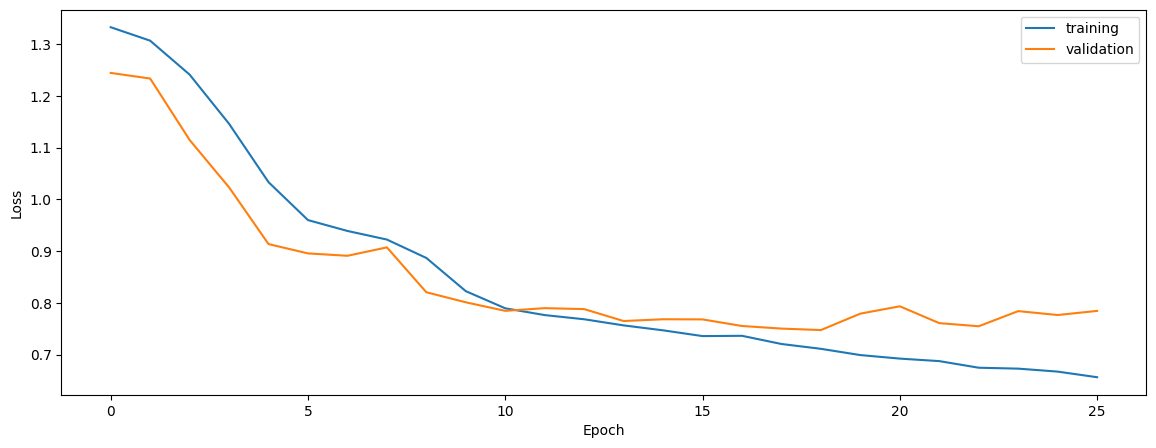

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


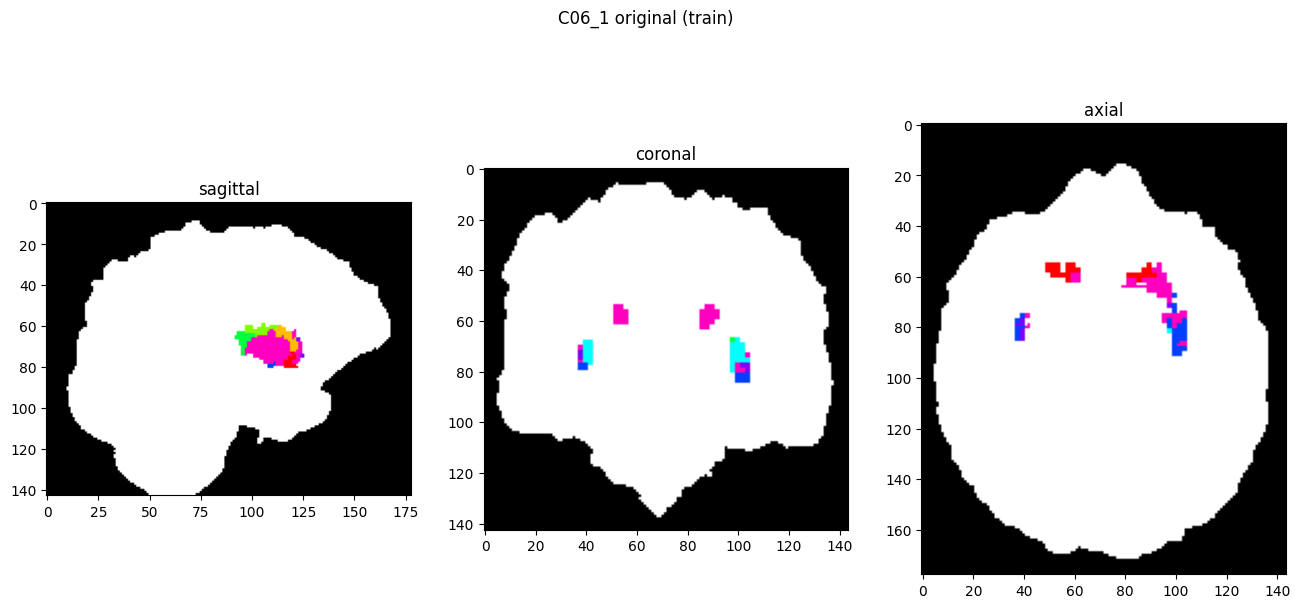

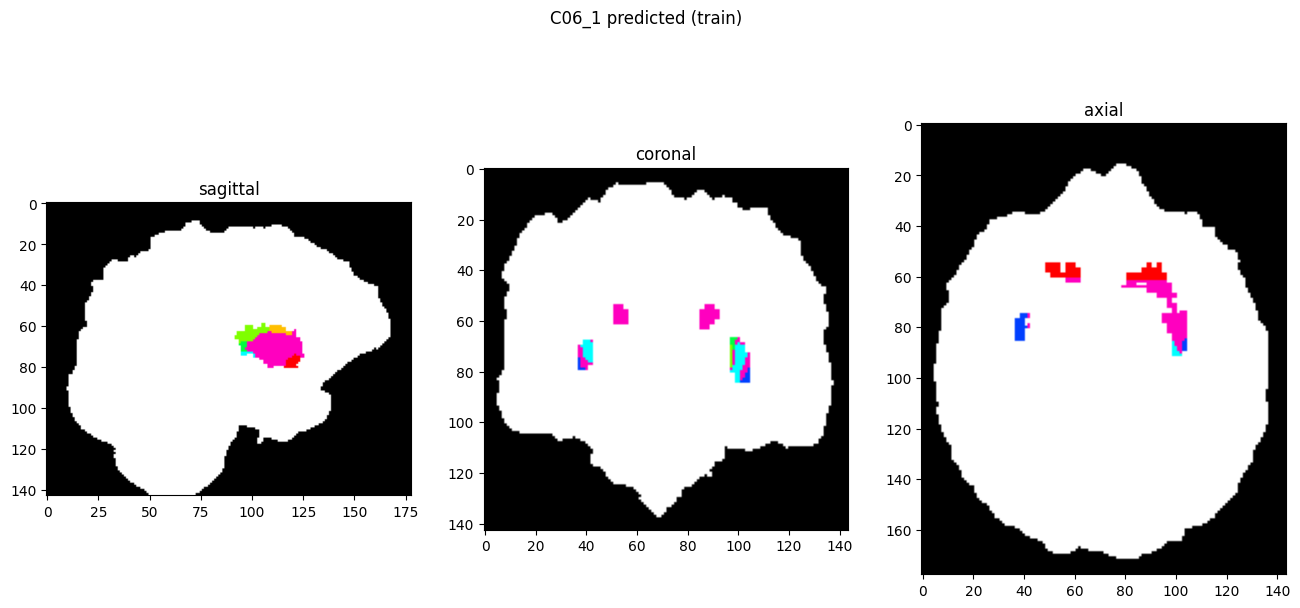

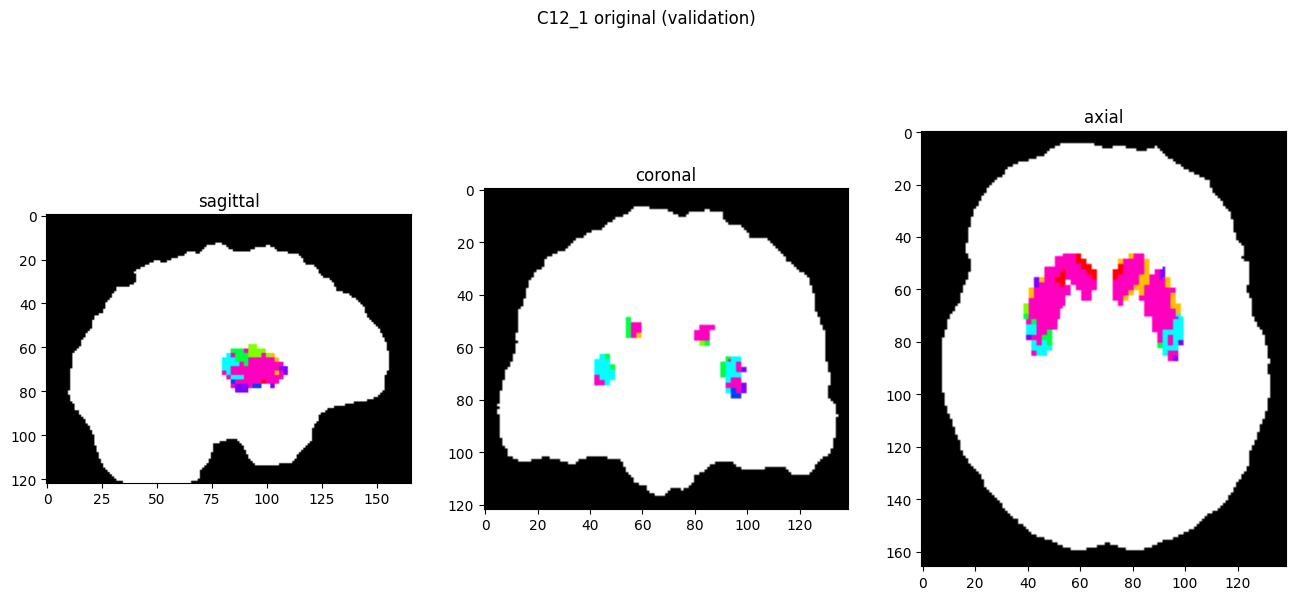

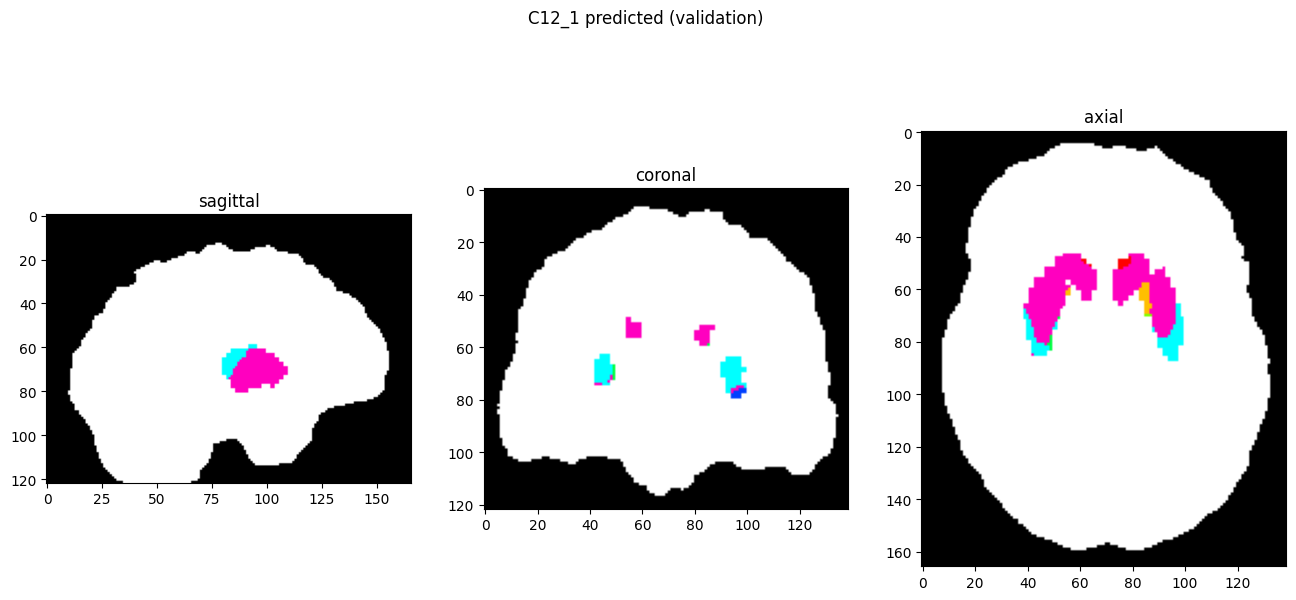

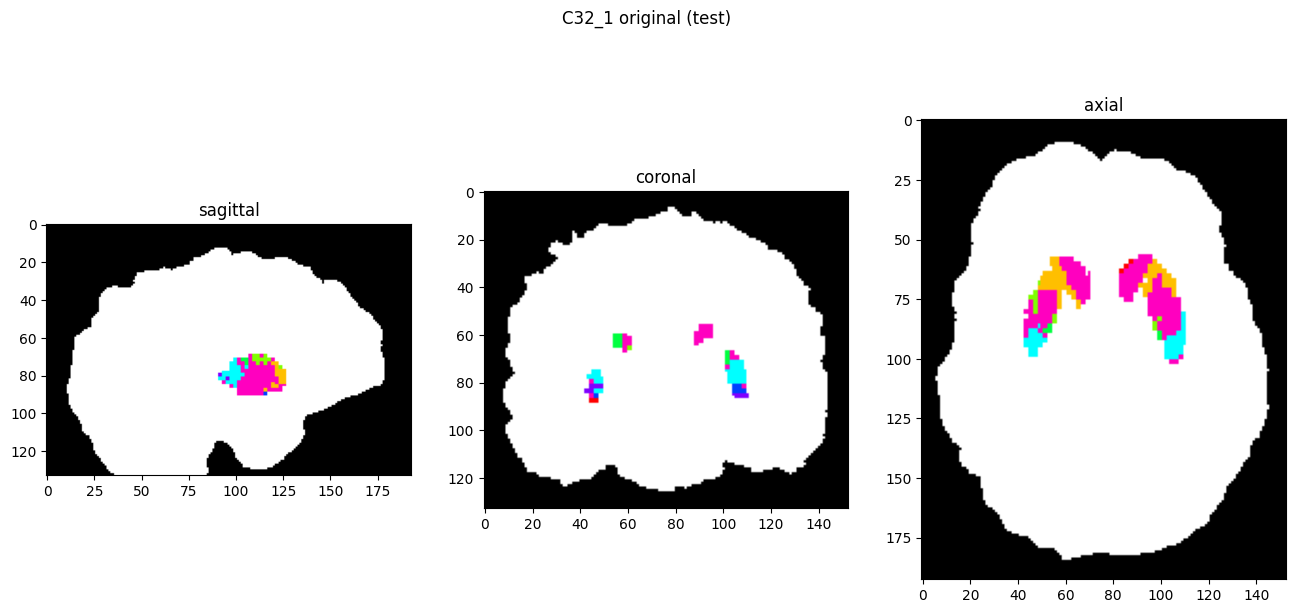

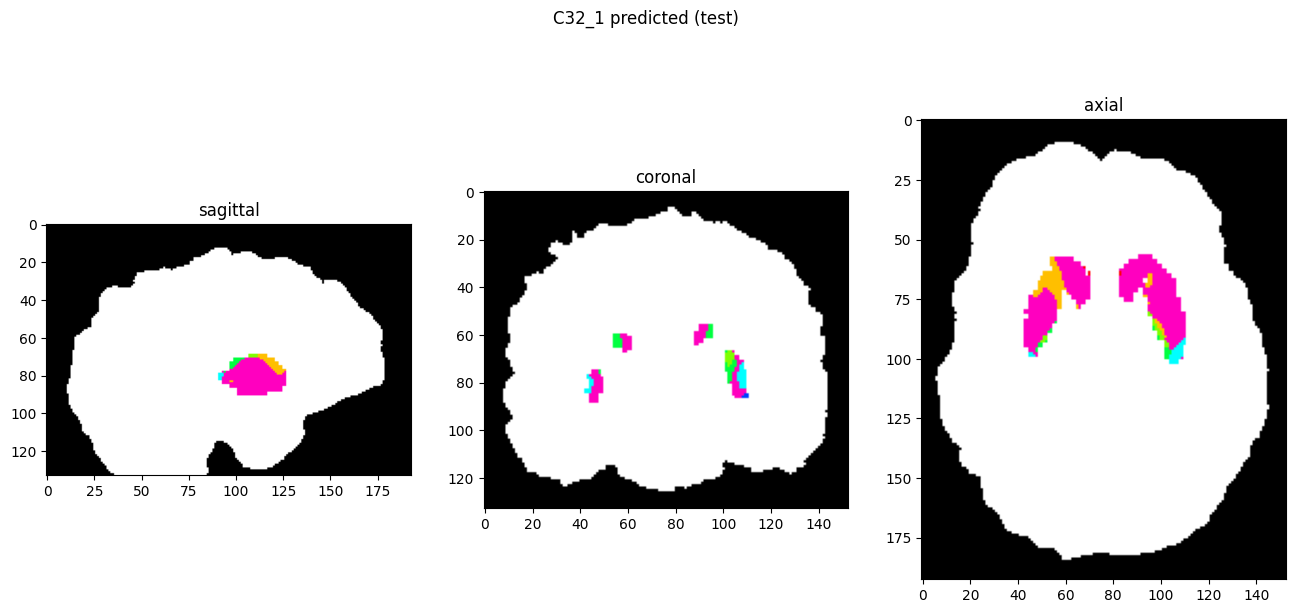

In [10]:
showResults(model, gen, threshold=0)